## Cross-Analyzing Voter Turnout & Party Traits in Alaska & Washington D.C.

### PSTAT 135: Group Assignment 1
### Group 1: Aliaksei Lenski, Carly Greutert, Hanying Feng, Tyler Vu

We are exploring voter traits, such as gender, gun ownership, marital status, etc, to see if there is any correlation between registered voter party and these attributes. We hope this wiil help enhance our understanding of the voter demographics in Alaska and Washington, as well as how these populations compare and differ. Furthermore, we hope to also implement a variety of models in order to classify their registered party and see which qualities were important in prediction.

In [154]:
# Starting a spark session

In [155]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
.master("local[1]") \
.appName("MySparkApp") \
.config("spark.some.config.option", "some-value") \
.getOrCreate()

In [156]:
# Loading in the data frames for Alaska and Washington DC

In [157]:
df_AK = spark.read\
.format("csv")\
.option("header", "true")\
.option("nullValue", "NA")\
.option("delimiter", "\t")\
.option("inferSchema", "true")\
.load('gs://final-proj-135/notebooks/jupyter/VM2Uniform--AK--2021-02-03.tab')

In [158]:
df_DC = spark.read\
.format("csv")\
.option("header", "true")\
.option("nullValue", "NA")\
.option("delimiter", "\t")\
.option("inferSchema", "true")\
.load('gs://final-proj-135/notebooks/jupyter/VM2Uniform--DC--2021-01-30.tab')

In [159]:
# importing packages

In [160]:
from pyspark.sql.functions import *
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 
from pyspark.ml import Pipeline
from pyspark.ml.feature import RFormula, StringIndexer, OneHotEncoder, Imputer, VectorAssembler, StandardScaler, Bucketizer
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression, NaiveBayes
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import regexp_replace, col
from pyspark.sql.types import LongType

### Cleaning the Data

In [161]:
# Taking a subset of the columns and updating the data frames

In [162]:
df_AK = df_AK.select(['Voters_Gender', 'Voters_Age', 'Voters_BirthDate', 'Parties_Description', 'Ethnic_Description',\
'Religions_Description', 'MilitaryStatus_Description', 'MaritalStatus_Description', 'CommercialDataLL_Gun_Owner',\
'CommercialDataLL_Home_Owner_Or_Renter', 'CommercialDataLL_Interest_in_Electronic_Gaming_In_Household', 'PresidentialPrimary_2020',\
'Voters_VotingPerformanceEvenYearPrimary', 'CommercialDataLL_Interest_in_Shooting_In_Household'])

In [163]:
df_DC = df_DC.select(['Voters_Gender', 'Voters_Age', 'Voters_BirthDate', 'Parties_Description', 'Ethnic_Description',\
'Religions_Description', 'MilitaryStatus_Description', 'MaritalStatus_Description', 'CommercialDataLL_Gun_Owner',\
'CommercialDataLL_Home_Owner_Or_Renter', 'CommercialDataLL_Interest_in_Electronic_Gaming_In_Household', 'PresidentialPrimary_2020',\
'Voters_VotingPerformanceEvenYearPrimary', 'CommercialDataLL_Interest_in_Shooting_In_Household'])

In [164]:
# Caching our data frames

In [165]:
df_AK = df_AK.cache()

23/03/22 23:27:40 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


In [166]:
df_DC = df_DC.cache()

23/03/22 23:27:40 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


In [167]:
# Renaming Columns

In [168]:
df_AK = df_AK.withColumnRenamed("Voters_Gender", "Gender")\
       .withColumnRenamed("Voters_Age", "Age")\
       .withColumnRenamed("Voters_BirthDate", "Birthdate")\
       .withColumnRenamed("Parties_Description", "Party")\
       .withColumnRenamed("Ethnic_Description", "Ethnicity")\
       .withColumnRenamed("Religions_Description", "Religion")\
       .withColumnRenamed("MilitaryStatus_Description", "Military_Status")\
       .withColumnRenamed("MaritalStatus_Description", "Marital_Status")\
       .withColumnRenamed("CommercialDataLL_Gun_Owner", "Gun_Owner")\
       .withColumnRenamed("CommercialDataLL_Home_Owner_Or_Renter", "Home_Owner_Or_Renter")\
       .withColumnRenamed("CommercialDataLL_Interest_in_Electronic_Gaming_In_Household", "EGame_Interest")\
       .withColumnRenamed("PresidentialPrimary_2020", "Primary2020")\
       .withColumnRenamed("Voters_VotingPerformanceEvenYearPrimary", "Primary_Proportion_Voted")\
       .withColumnRenamed("CommercialDataLL_Interest_in_Shooting_In_Household", "Interest_in_shooting")


In [169]:
df_DC = df_DC.withColumnRenamed("Voters_Gender", "Gender")\
       .withColumnRenamed("Voters_Age", "Age")\
       .withColumnRenamed("Voters_BirthDate", "Birthdate")\
       .withColumnRenamed("Parties_Description", "Party")\
       .withColumnRenamed("Ethnic_Description", "Ethnicity")\
       .withColumnRenamed("Religions_Description", "Religion")\
       .withColumnRenamed("MilitaryStatus_Description", "Military_Status")\
       .withColumnRenamed("MaritalStatus_Description", "Marital_Status")\
       .withColumnRenamed("CommercialDataLL_Gun_Owner", "Gun_Owner")\
       .withColumnRenamed("CommercialDataLL_Home_Owner_Or_Renter", "Home_Owner_Or_Renter")\
       .withColumnRenamed("CommercialDataLL_Interest_in_Electronic_Gaming_In_Household", "EGame_Interest")\
       .withColumnRenamed("PresidentialPrimary_2020", "Primary2020")\
       .withColumnRenamed("Voters_VotingPerformanceEvenYearPrimary", "Primary_Proportion_Voted")\
       .withColumnRenamed("CommercialDataLL_Interest_in_Shooting_In_Household", "Interest_in_shooting") 

In [170]:
# In the data frames, some column's null values were intended to be a "No". We modify this below.

In [171]:
df_AK = df_AK.na.fill(value = 'No', subset = 'Gun_Owner')

In [172]:
df_DC = df_DC.na.fill(value = 'No', subset = 'Gun_Owner')

In [173]:
df_AK = df_AK.na.fill(value = 'No', subset = 'EGame_Interest')

In [174]:
df_DC = df_DC.na.fill(value = 'No', subset = 'EGame_Interest')

In [175]:
df_AK = df_AK.na.fill(value = 'Not Married', subset = 'Marital_Status')

In [176]:
df_DC = df_DC.na.fill(value = 'Not Married', subset = 'Marital_Status')

In [177]:
df_AK = df_AK.na.fill(value = 'No', subset = 'Interest_in_shooting')

In [178]:
df_DC = df_DC.na.fill(value = 'No', subset = 'Interest_in_shooting')

In [179]:
# Counting the number of rows

In [180]:
df_AK.count()

548259

In [181]:
df_DC.count()

473913

In [182]:
# Counting missing values in each column after modifying columns

In [183]:
df_AK.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df_AK.columns)).collect()

[Row(Gender=66, Age=215368, Birthdate=215368, Party=0, Ethnicity=71026, Religion=388240, Military_Status=548259, Marital_Status=0, Gun_Owner=0, Home_Owner_Or_Renter=198182, EGame_Interest=0, Primary2020=548259, Primary_Proportion_Voted=0, Interest_in_shooting=0)]

In [184]:
df_DC.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df_DC.columns)).collect()

[Row(Gender=19601, Age=193536, Birthdate=193536, Party=0, Ethnicity=37325, Religion=329504, Military_Status=473913, Marital_Status=0, Gun_Owner=0, Home_Owner_Or_Renter=71185, EGame_Interest=0, Primary2020=365971, Primary_Proportion_Voted=0, Interest_in_shooting=0)]

df_AK has 548,259 rows and 12 columns and df_DC has 473,913 rows and 12 columns. The schemas are shown below.

In [185]:
df_AK.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Birthdate: string (nullable = true)
 |-- Party: string (nullable = true)
 |-- Ethnicity: string (nullable = true)
 |-- Religion: string (nullable = true)
 |-- Military_Status: string (nullable = true)
 |-- Marital_Status: string (nullable = false)
 |-- Gun_Owner: string (nullable = false)
 |-- Home_Owner_Or_Renter: string (nullable = true)
 |-- EGame_Interest: string (nullable = false)
 |-- Primary2020: string (nullable = true)
 |-- Primary_Proportion_Voted: string (nullable = true)
 |-- Interest_in_shooting: string (nullable = false)



In [186]:
df_DC.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Birthdate: string (nullable = true)
 |-- Party: string (nullable = true)
 |-- Ethnicity: string (nullable = true)
 |-- Religion: string (nullable = true)
 |-- Military_Status: string (nullable = true)
 |-- Marital_Status: string (nullable = false)
 |-- Gun_Owner: string (nullable = false)
 |-- Home_Owner_Or_Renter: string (nullable = true)
 |-- EGame_Interest: string (nullable = false)
 |-- Primary2020: string (nullable = true)
 |-- Primary_Proportion_Voted: string (nullable = true)
 |-- Interest_in_shooting: string (nullable = false)



### Exploratory Data Analysis

We will first explore the gender, age, ethnicity, religion, and party data in DC and Alaska.

In [187]:
df_DC_new = df_DC
df_AK_new = df_AK

DC_Gender = df_DC_new.select('Gender', 'Party').groupby(df_DC_new.Gender).count().sort('count', ascending=False)
DC_Gender = DC_Gender.toPandas()
DC_Gender.fillna("No Information",inplace=True)

AK_Gender = df_AK_new.select('Gender', 'Party').groupby(df_AK_new.Gender).count().sort('count', ascending=False)
AK_Gender = AK_Gender.toPandas()
AK_Gender.fillna("No Information",inplace=True)

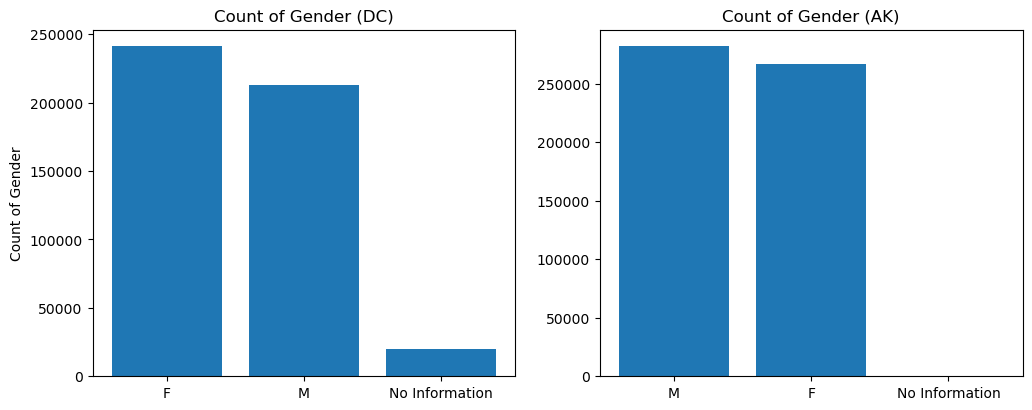

In [188]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4.5)
ax[0].bar(DC_Gender['Gender'], DC_Gender['count'])
ax[0].set_ylabel('Count of Gender')
ax[0].set_title('Count of Gender (DC)')
ax[1].bar(AK_Gender['Gender'], AK_Gender['count'])
ax[1].set_title('Count of Gender (AK)')
plt.show()

We can see that there are more female registered voters in DC, while there are more male registered voters in Alaska. There are around 25000 unknown gender voters in DC, while the gender of most of the voters in Alaska are known.

In [189]:
DC_Age = df_DC_new.select('Age').toPandas()
DC_Age.fillna("",inplace=True)
DC_Age['Age'] = pd.to_numeric(DC_Age['Age'])

AK_Age = df_AK_new.select('Age').toPandas()
AK_Age.fillna("",inplace=True)
AK_Age['Age'] = pd.to_numeric(AK_Age['Age'])

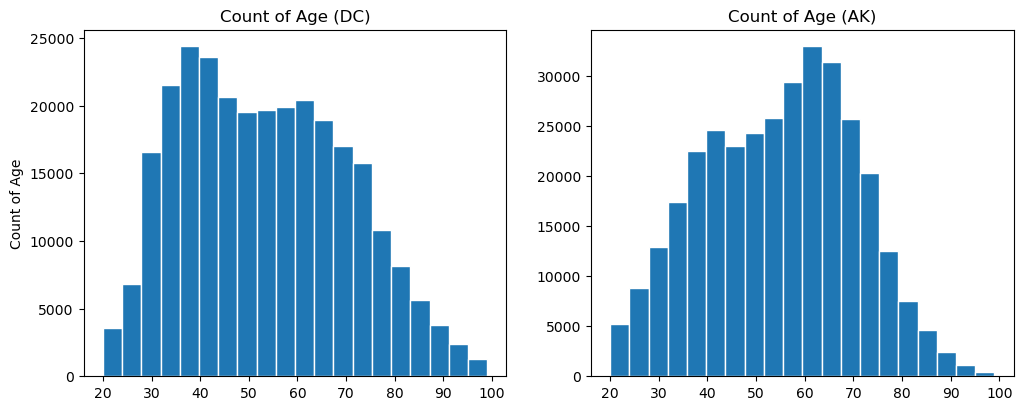

In [190]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4.5)
ax[0].hist(x=DC_Age['Age'], bins=20, edgecolor="white")
ax[0].set_ylabel('Count of Age')
ax[0].set_title('Count of Age (DC)')
ax[1].hist(x=AK_Age['Age'], bins=20, edgecolor="white")
ax[1].set_title('Count of Age (AK)')
plt.show()

The voters in DC seem to generally younger than the voters in Alaska. The voters' age in DC concentrate between 30 and 50 years old, while the voters' age in Alaska concentrate between 50 and 70 years old.

In [191]:
DC_Ethnicity = df_DC_new.select('Ethnicity', 'Party').groupby(df_DC_new.Ethnicity).count().sort("count", ascending=False)
DC_Ethnicity = DC_Ethnicity.toPandas()
DC_Ethnicity.fillna("No Information",inplace=True)

AK_Ethnicity = df_AK_new.select('Ethnicity', 'Party').groupby(df_AK_new.Ethnicity).count().sort("count", ascending=False)
AK_Ethnicity = AK_Ethnicity.toPandas()
AK_Ethnicity.fillna("No Information",inplace=True)

In [192]:
E = [['DC Ethnicity', DC_Ethnicity['Ethnicity'].count()-1], ['AK Ethnicity', AK_Ethnicity['Ethnicity'].count()-1]]
pd.DataFrame(E)

,0,1
0,DC Ethnicity,81
1,AK Ethnicity,77


There are 81 known different ethnicities among the voters in DC, and there are 77 known different ethnicities among the voters in Alaska. We will show the top 15 largest ethnicities in DC and Alaska.

In [193]:
Ethnicity = pd.concat([DC_Ethnicity[:15],AK_Ethnicity[:15]],axis=1,join='outer')
Ethnicity.columns = ['Ethnicity (DC)', 'count (DC)', 'Ethnicity (AK)', 'count (AK)']
Ethnicity

,Ethnicity (DC),count (DC),Ethnicity (AK),count (AK)
0,Likely Af-Am (Modeled),237598,English/Welsh,225110
1,English/Welsh,62936,No Information,71026
2,No Information,37325,German,43022
3,Hispanic,27268,Irish,37277
4,German,22272,Scots,34721
5,Irish,18878,Hispanic,31260
6,Italian,11621,French,13850
7,Scots,9562,Swedish,12833
8,Arab,6054,Italian,10471
9,French,5131,Dutch (Netherlands),10178


The ethnicity with the largest population in DC is Likely Af-Am (Modeled), and the second largest ethnicity is English/Welsh. The ethnicity with the largest population in Alaska is English/Welsh, and the second largest ethnicity is German (we ignore the unknown ethnicities here). 

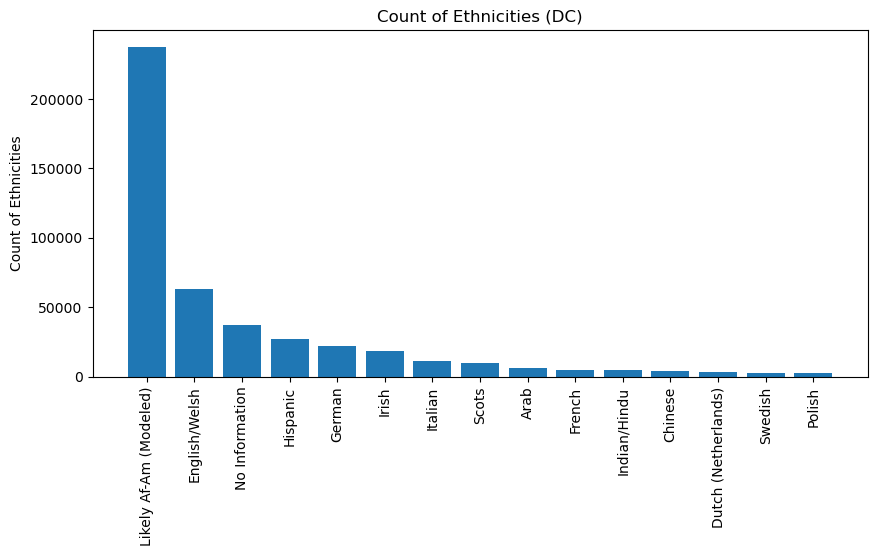

In [194]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 4.5)
ax.bar(DC_Ethnicity['Ethnicity'].iloc[:15], DC_Ethnicity['count'].iloc[:15])
ax.set_xticklabels(DC_Ethnicity['Ethnicity'], rotation=90)
ax.set_ylabel('Count of Ethnicities')
ax.set_title('Count of Ethnicities (DC)')
plt.show()

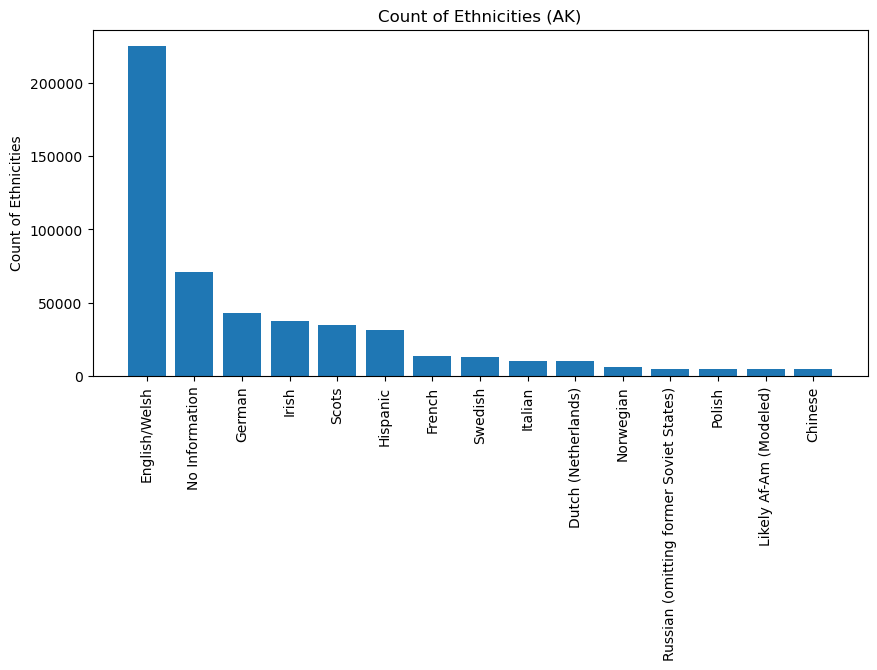

In [195]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 4.5)
ax.bar(AK_Ethnicity['Ethnicity'].iloc[:15], AK_Ethnicity['count'].iloc[:15])
ax.set_xticklabels(AK_Ethnicity['Ethnicity'], rotation=90)
ax.set_ylabel('Count of Ethnicities')
ax.set_title('Count of Ethnicities (AK)')
plt.show()

In [196]:
DC_Religion = df_DC_new.select('Religion', 'Party').groupby(df_DC_new.Religion).count().sort("count", ascending=False)
DC_Religion = DC_Religion.toPandas()
DC_Religion.fillna("No Information",inplace=True)

AK_Religion = df_AK_new.select('Religion', 'Party').groupby(df_AK_new.Religion).count().sort("count", ascending=False)
AK_Religion = AK_Religion.toPandas()
AK_Religion.fillna("No Information",inplace=True)

In [197]:
R = [['DC Religion', DC_Religion['Religion'].count()-1], ['AK Religion', AK_Religion['Religion'].count()-1]]
pd.DataFrame(R)

,0,1
0,DC Religion,13
1,AK Religion,13


We can see that there are 13 known religions among the voters in both DC and Alaska.

In [198]:
Religion = pd.concat([DC_Religion,AK_Religion],axis=1,join='outer')
Religion.columns = ['Religion (DC)', 'count (DC)', 'Religion (AK)', 'count (AK)']
Religion

,Religion (DC),count (DC),Religion (AK),count (AK)
0,No Information,329504,No Information,388240
1,Protestant,98184,Protestant,101995
2,Jewish,23266,Catholic,31117
3,Catholic,16190,Jewish,19677
4,Islamic,2641,Eastern Orthodox,2184
5,Buddhist,1087,Christian,1614
6,Eastern Orthodox,944,Buddhist,1570
7,Hindu,856,Shinto,606
8,Christian,440,Islamic,443
9,Greek Orthodox,386,Greek Orthodox,338


Most of the voters do not have the information of their religions. In both DC and Alaska, the known religion with the largest population is Protestant. In DC, the second largest religion is Jewish, and the third largest religion is Catholic. In Alaska, the second largest religion is Catholic, and the third largest religion is Jewish.

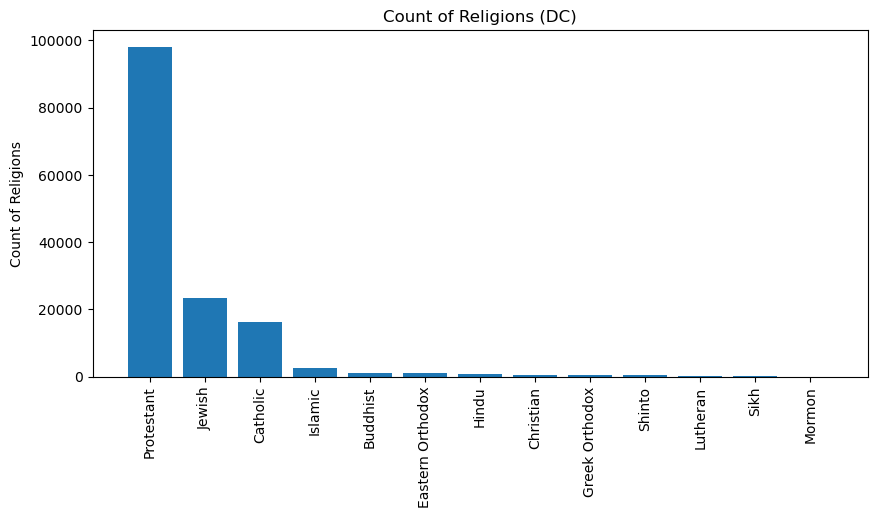

In [199]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 4.5)
ax.bar(DC_Religion['Religion'][1:], DC_Religion['count'][1:])
ax.set_xticklabels(DC_Religion['Religion'][1:], rotation=90)
ax.set_ylabel('Count of Religions')
ax.set_title('Count of Religions (DC)')
plt.show()

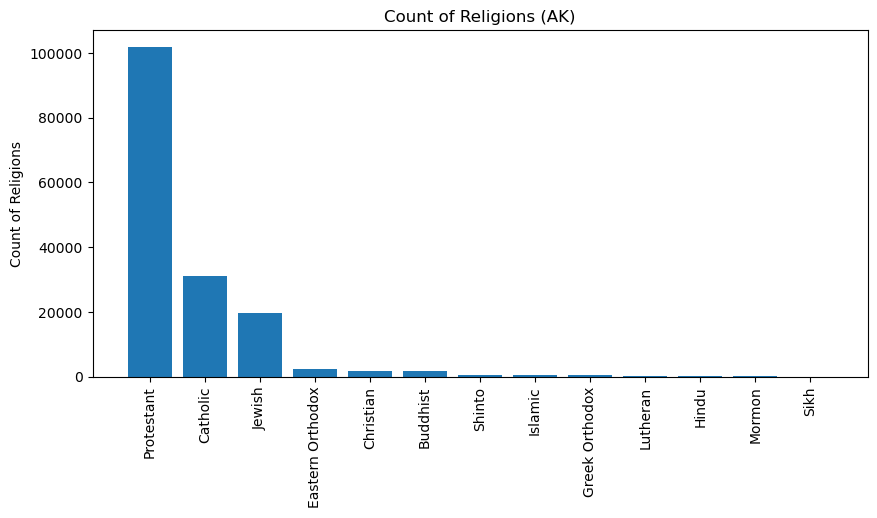

In [200]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 4.5)
ax.bar(AK_Religion['Religion'][1:], AK_Religion['count'][1:])
ax.set_xticklabels(AK_Religion['Religion'][1:], rotation=90)
ax.set_ylabel('Count of Religions')
ax.set_title('Count of Religions (AK)')
plt.show()

In [201]:
DC_Parties = df_DC_new.select('Party', 'Party').groupby(df_DC_new.Party).count().sort("count", ascending=False)
DC_Parties = DC_Parties.toPandas()
DC_Parties.fillna("No Information",inplace=True)

AK_Parties = df_AK_new.select('Party', 'Party').groupby(df_AK_new.Party).count().sort("count", ascending=False)
AK_Parties = AK_Parties.toPandas()
AK_Parties.fillna("No Information",inplace=True)

In [202]:
Party = pd.concat([DC_Parties,AK_Parties],axis=1,join='outer')
Party.columns = ['Party (DC)', 'count (DC)', 'Party (AK)', 'count (AK)']
Party

,Party (DC),count (DC),Party (AK),count (AK)
0,Democratic,365463.0,Unknown,237742
1,Non-Partisan,75549.0,Republican,133370
2,Republican,26063.0,Non-Partisan,75520
3,Green,3506.0,Democratic,73994
4,Libertarian,1884.0,Independence,17667
5,Other,1448.0,Libertarian,6202
6,NaN,NaN,Other,1765
7,NaN,NaN,Green Libertarian,1406
8,NaN,NaN,Constitution,593


In DC, most voters registered for Democratic. In Alaska, most voters registered for Unknown parties. The known party with the most voters in Alaska is Republican.

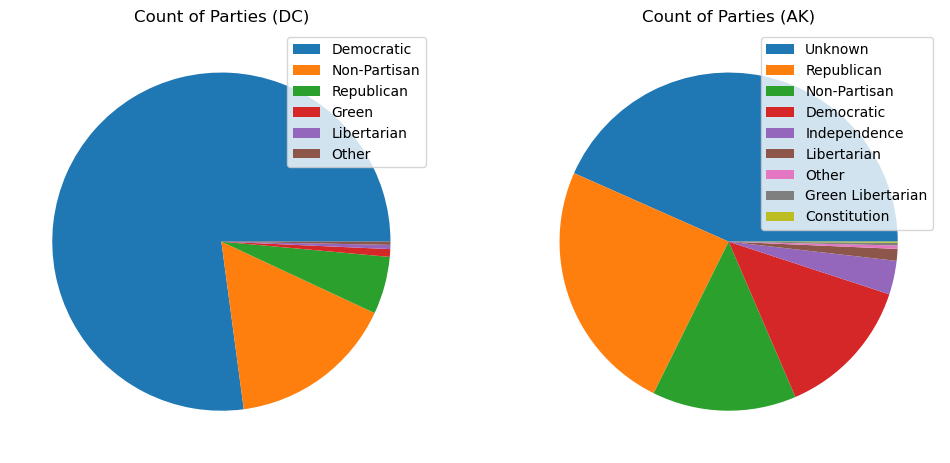

In [203]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5.5)
ax[0].pie(DC_Parties['count'])
ax[0].set_title('Count of Parties (DC)')
ax[0].legend(DC_Parties['Party'])
ax[1].pie(AK_Parties['count'])
ax[1].set_title('Count of Parties (AK)')
ax[1].legend(AK_Parties['Party'])
plt.show()

We will then start to explore how gender, ethnicity, and religion will influence the voters' parties preference.

In [204]:
DC_P_G = df_DC_new.groupby(['Party', 'Gender']).count().sort(['Party', 'Gender'], ascending=[True, False])
DC_P_G = DC_P_G.toPandas()
DC_P_G.fillna("No Information",inplace=True)

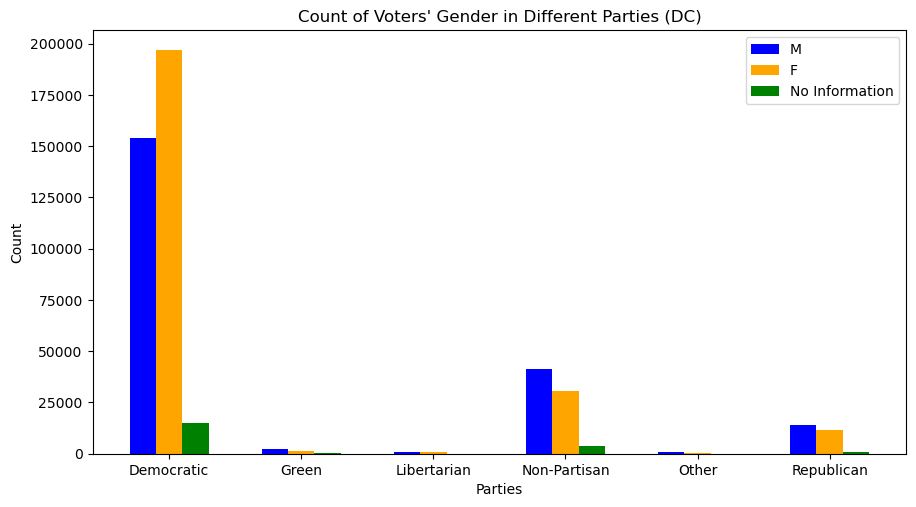

In [205]:
x = np.arange(6)
width = 0.2
  
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 5.5)
ax.bar(x-0.2, np.array(DC_P_G[DC_P_G.Gender=='M']['count']), width, color='blue')
ax.bar(x, np.array(DC_P_G[DC_P_G.Gender=='F']['count']), width, color='orange')
ax.bar(x+0.2, np.array(DC_P_G[DC_P_G.Gender=='No Information']['count']), width, color='green')
ax.set_title("Count of Voters' Gender in Different Parties (DC)")
plt.xticks(x, np.array(DC_P_G['Party'].unique()))
plt.xlabel("Parties")
plt.ylabel("Count")
plt.legend(["M", "F", "No Information"])
plt.show()

In DC, more female voters support Democratic than male voters, while more male voters support Non-Partisan and Republican than female voters.

In [206]:
AK_P_G = df_AK_new.groupby(['Party', 'Gender']).count().sort(['Party', 'Gender'], ascending=[True, False])
AK_P_G = AK_P_G.toPandas()
AK_P_G.fillna("No Information",inplace=True)

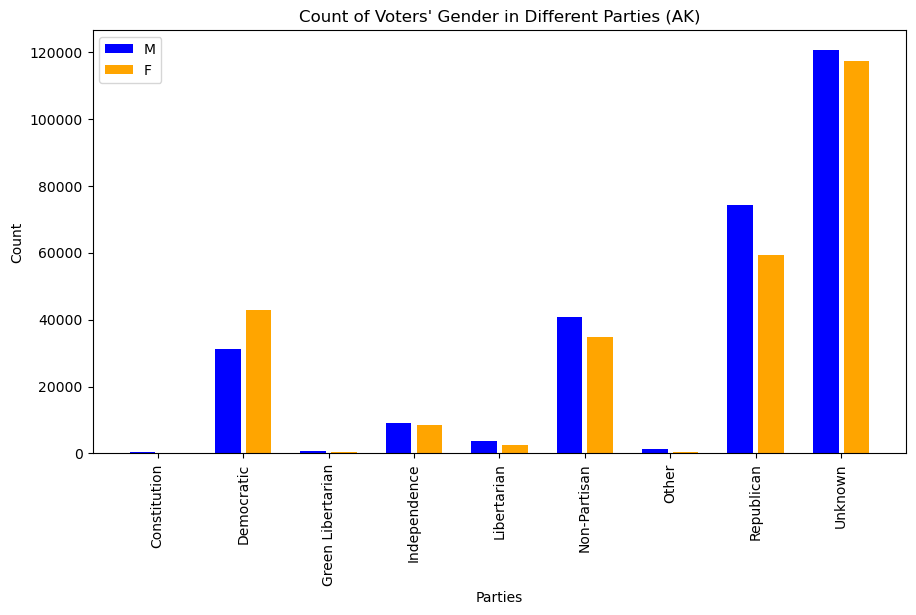

In [207]:
x = np.arange(9)
width = 0.3
  
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 5.5)
ax.bar(x-0.18, np.array(AK_P_G[AK_P_G.Gender=='M']['count']), width, color='blue')
ax.bar(x+0.18, np.array(AK_P_G[AK_P_G.Gender=='F']['count']), width, color='orange')
ax.set_title("Count of Voters' Gender in Different Parties (AK)")
plt.xticks(x, np.array(AK_P_G['Party'].unique()), rotation=90)
plt.xlabel("Parties")
plt.ylabel("Count")
plt.legend(["M", "F", "No Information"])
plt.show()

In Alaska, more male voters registered for unknown party than female voters. More male voters support Non-Partisan and Republican than female voters, while more female voters support Democratic than male voters. From the data of these states, it seems like female voters are more likely to support Democratic than male voters.

In [208]:
DC_tmp = df_DC_new.filter((df_DC_new.Ethnicity == 'Likely Af-Am (Modeled)') | \
                          (df_DC_new.Ethnicity == 'English/Welsh') | \
                          (df_DC_new.Ethnicity == 'Hispanic') | \
                          (df_DC_new.Ethnicity == 'German') | \
                          (df_DC_new.Ethnicity == 'Irish'))
DC_P_E = DC_tmp.groupby(['Party', 'Ethnicity']).count().sort(['Party', 'Ethnicity'])
DC_P_E = DC_P_E.toPandas()

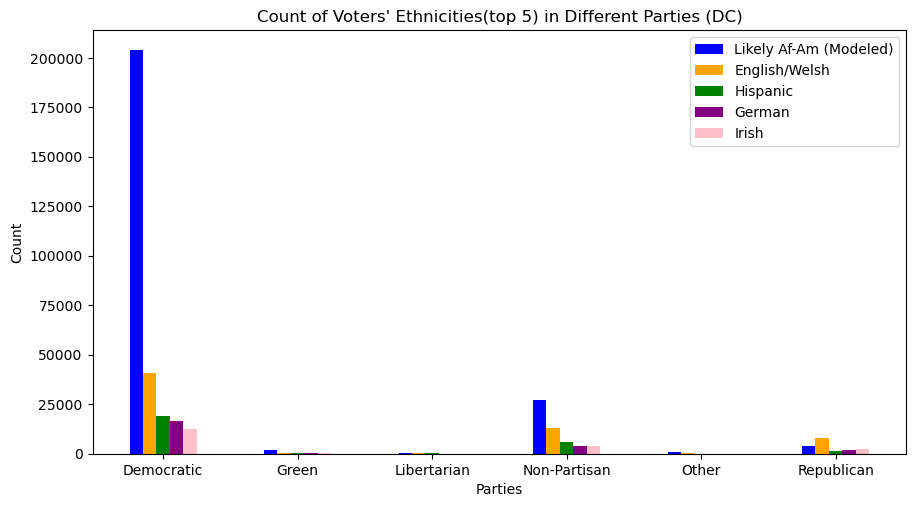

In [209]:
x = np.arange(6)
width = 0.1
  
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 5.5)
ax.bar(x-0.2, np.array(DC_P_E[DC_P_E.Ethnicity=='Likely Af-Am (Modeled)']['count']), width, color='blue')
ax.bar(x-0.1, np.array(DC_P_E[DC_P_E.Ethnicity=='English/Welsh']['count']), width, color='orange')
ax.bar(x, np.array(DC_P_E[DC_P_E.Ethnicity=='Hispanic']['count']), width, color='green')
ax.bar(x+0.1, np.array(DC_P_E[DC_P_E.Ethnicity=='German']['count']), width, color='purple')
ax.bar(x+0.2, np.array(DC_P_E[DC_P_E.Ethnicity=='Irish']['count']), width, color='pink')
ax.set_title("Count of Voters' Ethnicities(top 5) in Different Parties (DC)")
plt.xticks(x, np.array(DC_P_E['Party'].unique()))
plt.xlabel("Parties")
plt.ylabel("Count")
plt.legend(['Likely Af-Am (Modeled)','English/Welsh','Hispanic','German','Irish'])
plt.show()

Generally, the ethnicity with larger population has more registered voters in each party. However, in DC, there are more English/Welsh voters support Republican, while Likely Af-Am (Modeled) has larger population.

In [210]:
AK_tmp = df_AK_new.filter((df_AK_new.Ethnicity == 'English/Welsh') | \
                          (df_AK_new.Ethnicity == 'German') | \
                          (df_AK_new.Ethnicity == 'Irish') | \
                          (df_AK_new.Ethnicity == 'Scots') | \
                          (df_AK_new.Ethnicity == 'Hispanic'))
AK_P_E = AK_tmp.groupby(['Party', 'Ethnicity']).count().sort(['Party', 'Ethnicity'])
AK_P_E = AK_P_E.toPandas()

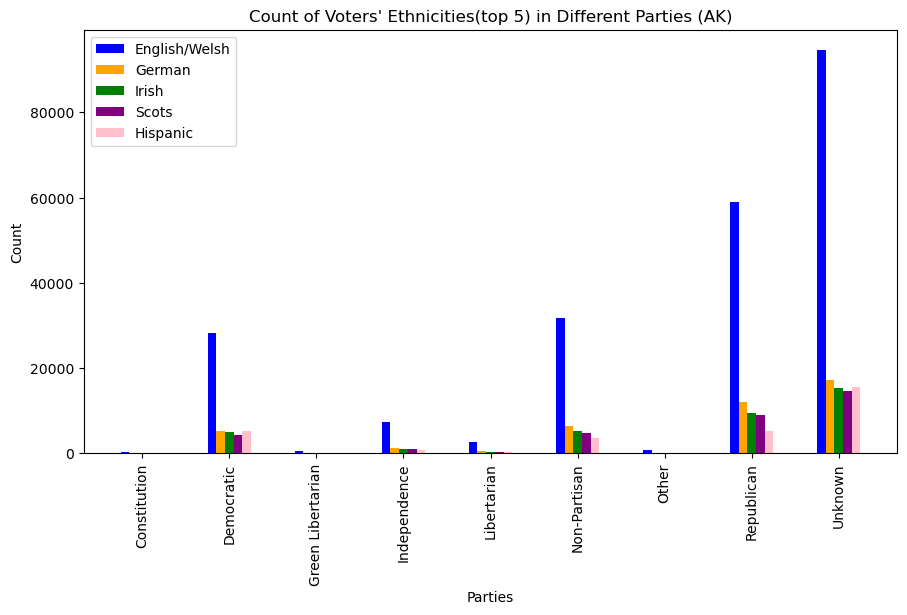

In [211]:
x = np.arange(9)
width = 0.1
  
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 5.5)
ax.bar(x-0.2, np.array(AK_P_E[AK_P_E.Ethnicity=='English/Welsh']['count']), width, color='blue')
ax.bar(x-0.1, np.array(AK_P_E[AK_P_E.Ethnicity=='German']['count']), width, color='orange')
ax.bar(x, np.array(AK_P_E[AK_P_E.Ethnicity=='Irish']['count']), width, color='green')
ax.bar(x+0.1, np.array(AK_P_E[AK_P_E.Ethnicity=='Scots']['count']), width, color='purple')
ax.bar(x+0.2, np.array(AK_P_E[AK_P_E.Ethnicity=='Hispanic']['count']), width, color='pink')
ax.set_title("Count of Voters' Ethnicities(top 5) in Different Parties (AK)")
plt.xticks(x, np.array(AK_P_E['Party'].unique()), rotation=90)
plt.xlabel("Parties")
plt.ylabel("Count")
plt.legend(['English/Welsh','German','Irish','Scots','Hispanic'])
plt.show()

In Alaska, Hispanic voters are more likely to support Democratic and unknown parties. There are less Hispanic voters support Republican.

In [212]:
DC_tmp = df_DC_new.filter((df_DC_new.Religion == 'Protestant') | \
                          (df_DC_new.Religion == 'Jewish') | \
                          (df_DC_new.Religion == 'Catholic') | \
                          (df_DC_new.Religion == 'Islamic') | \
                          (df_DC_new.Religion == 'Buddhist'))
DC_P_R = DC_tmp.groupby(['Party', 'Religion']).count().sort(['Party', 'Religion'])
DC_P_R = DC_P_R.toPandas()

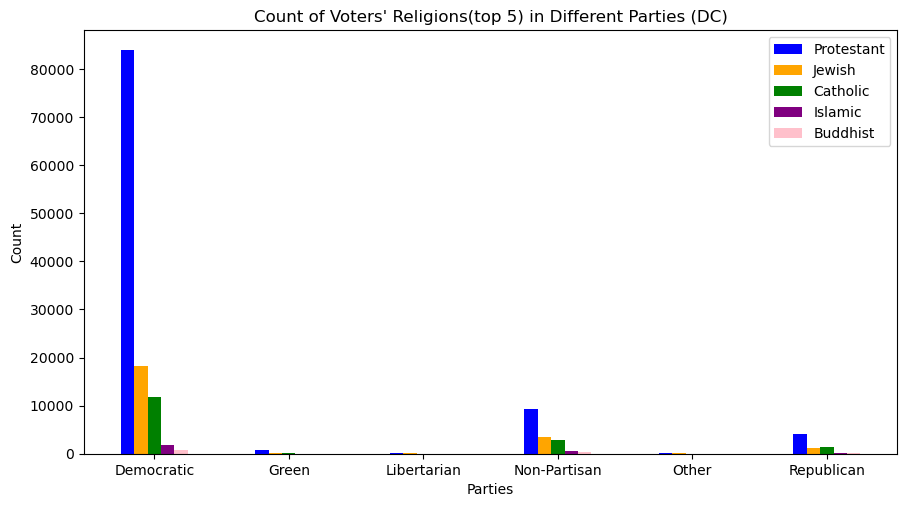

In [213]:
x = np.arange(6)
width = 0.1
  
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 5.5)
ax.bar(x-0.2, np.array(DC_P_R[DC_P_R.Religion=='Protestant']['count']), width, color='blue')
ax.bar(x-0.1, np.array(DC_P_R[DC_P_R.Religion=='Jewish']['count']), width, color='orange')
ax.bar(x, np.array(DC_P_R[DC_P_R.Religion=='Catholic']['count']), width, color='green')
ax.bar(x+0.1, np.array(DC_P_R[DC_P_R.Religion=='Islamic']['count']), width, color='purple')
ax.bar(x+0.2, np.array(DC_P_R[DC_P_R.Religion=='Buddhist']['count']), width, color='pink')
ax.set_title("Count of Voters' Religions(top 5) in Different Parties (DC)")
plt.xticks(x, np.array(DC_P_R['Party'].unique()))
plt.xlabel("Parties")
plt.ylabel("Count")
plt.legend(['Protestant','Jewish','Catholic','Islamic','Buddhist'])
plt.show()

In [214]:
AK_tmp = df_AK_new.filter((df_AK_new.Religion == 'Protestant') | \
                          (df_AK_new.Religion == 'Catholic') | \
                          (df_AK_new.Religion == 'Jewish') | \
                          (df_AK_new.Religion == 'Eastern Orthodox') | \
                          (df_AK_new.Religion == 'Christian'))
AK_P_R = AK_tmp.groupby(['Party', 'Religion']).count().sort(['Party', 'Religion'])
AK_P_R = AK_P_R.toPandas()

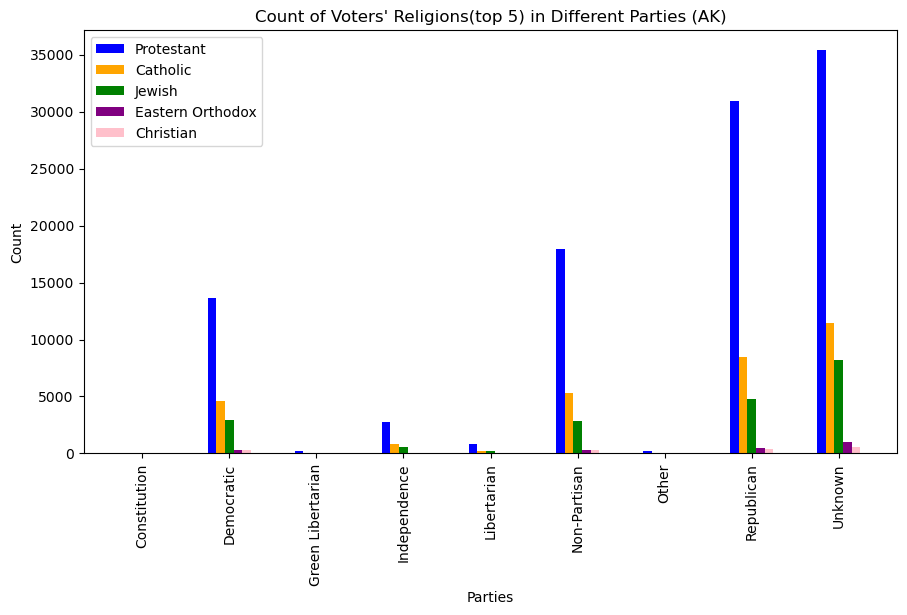

In [215]:
x = np.arange(9)
width = 0.1
  
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 5.5)
ax.bar(x-0.2, np.array(AK_P_R[AK_P_R.Religion=='Protestant']['count']), width, color='blue')
ax.bar(x-0.1, np.array(AK_P_R[AK_P_R.Religion=='Catholic']['count']), width, color='orange')
ax.bar(x, np.array(AK_P_R[AK_P_R.Religion=='Jewish']['count']), width, color='green')
ax.bar(x+0.1, np.array(AK_P_R[AK_P_R.Religion=='Eastern Orthodox']['count']), width, color='purple')
ax.bar(x+0.2, np.array(AK_P_R[AK_P_R.Religion=='Christian']['count']), width, color='pink')
ax.set_title("Count of Voters' Religions(top 5) in Different Parties (AK)")
plt.xticks(x, np.array(AK_P_R['Party'].unique()), rotation=90)
plt.xlabel("Parties")
plt.ylabel("Count")
plt.legend(['Protestant','Catholic','Jewish','Eastern Orthodox','Christian'])
plt.show()

Generally, the religion with larger population has more registered voters in each party in both DC and Alaska.

In [216]:
df_AK_copy = df_AK.groupby(['Party', 'Gun_Owner']).count().sort(['Party', 'Gun_Owner'])
df_AK_copy = df_AK_copy.toPandas()
df_DC_copy = df_DC.groupby(['Party', 'Gun_Owner']).count().sort(['Party', 'Gun_Owner'])
df_DC_copy = df_DC_copy.toPandas()

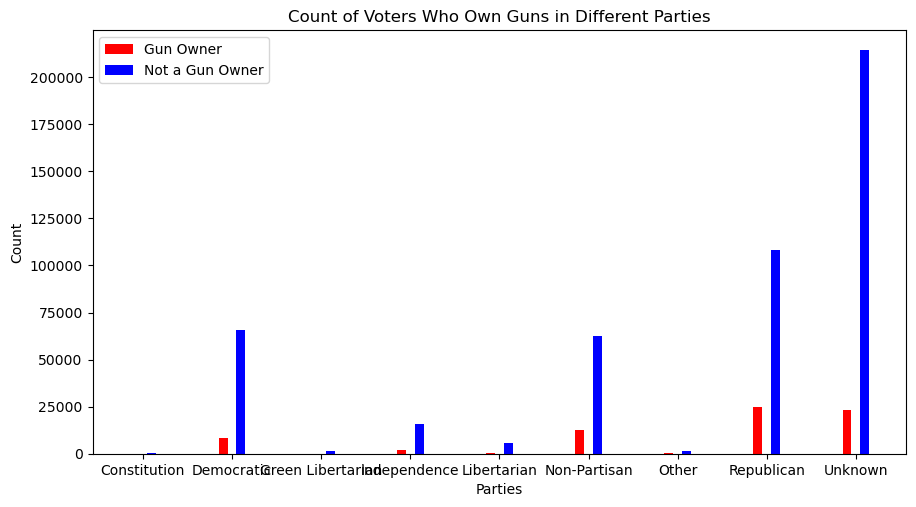

In [217]:
x = np.arange(9)
width = 0.1
  
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 5.5)
ax.bar(x-0.1, np.array(df_AK_copy[df_AK_copy['Gun_Owner']=='Yes']['count']), width, color='red')
ax.bar(x+0.1, np.array(df_AK_copy[df_AK_copy['Gun_Owner']=='No']['count']), width, color='blue')
ax.set_title("Count of Voters Who Own Guns in Different Parties")
plt.xticks(x, np.array(df_AK_copy['Party'].unique()))
plt.xlabel("Parties")
plt.ylabel("Count")
plt.legend(['Gun Owner', 'Not a Gun Owner'])
plt.show()

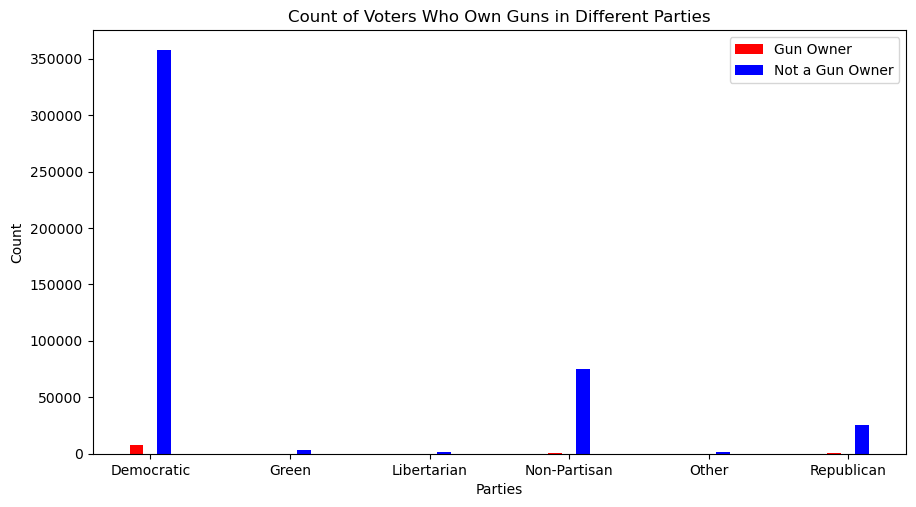

In [218]:
x = np.arange(6)
width = 0.1
  
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 5.5)
ax.bar(x-0.1, np.array(df_DC_copy[df_DC_copy['Gun_Owner']=='Yes']['count']), width, color='red')
ax.bar(x+0.1, np.array(df_DC_copy[df_DC_copy['Gun_Owner']=='No']['count']), width, color='blue')
ax.set_title("Count of Voters Who Own Guns in Different Parties")
plt.xticks(x, np.array(df_DC_copy['Party'].unique()))
plt.xlabel("Parties")
plt.ylabel("Count")
plt.legend(['Gun Owner', 'Not a Gun Owner'])
plt.show()

We first notice when comparing gun ownership in Alaska and DC that DC does not have voters registered for the Constitution, Independent, or Unknown party. We also notice that there is a vastly larger count of Democrats in DC than Alaska. Across states, there are more people that are not gun owners. Finally, Alaska has a higher count of gun owners than DC across parties.

### Gamers && Shooting

1) Making a graph on the correlation between being a gamer and party affiliation

2) Making a graph on the correlation between being a shooting enthusiast and party affiliation

In [219]:
ak = df_AK.select(['Birthdate', 'Party', 'Gun_Owner',
                      'EGame_Interest', 'Interest_in_shooting', 
                      'Primary_Proportion_Voted'])

dc = df_DC.select(['Birthdate', 'Party', 'Gun_Owner',
                      'EGame_Interest', 'Interest_in_shooting', 
                      'Primary_Proportion_Voted'])

In [220]:
ak.count()

548259

In [221]:
dc.count()

473913

In [222]:
ak.printSchema()

root
 |-- Birthdate: string (nullable = true)
 |-- Party: string (nullable = true)
 |-- Gun_Owner: string (nullable = false)
 |-- EGame_Interest: string (nullable = false)
 |-- Interest_in_shooting: string (nullable = false)
 |-- Primary_Proportion_Voted: string (nullable = true)



In [223]:
dc.printSchema()

root
 |-- Birthdate: string (nullable = true)
 |-- Party: string (nullable = true)
 |-- Gun_Owner: string (nullable = false)
 |-- EGame_Interest: string (nullable = false)
 |-- Interest_in_shooting: string (nullable = false)
 |-- Primary_Proportion_Voted: string (nullable = true)



In [224]:
ak = ak.cache()
dc = dc.cache()

23/03/22 23:27:59 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.
23/03/22 23:27:59 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


In [225]:
alaskans_gamers = ak.filter(ak.EGame_Interest == "Yes")\
.groupby("Party").count().sort('count', ascending=False)


alaskans_shooting = ak.filter(ak.Interest_in_shooting == "Yes")\
.groupby("Party").count().sort('count', ascending=False)

In [226]:
alaskans_gamers.show()

+-----------------+-----+
|            Party|count|
+-----------------+-----+
|          Unknown| 3573|
|       Republican| 2213|
|     Non-Partisan| 1399|
|       Democratic| 1181|
|     Independence|  274|
|      Libertarian|   90|
|            Other|   25|
|Green Libertarian|   13|
|     Constitution|    9|
+-----------------+-----+



In [227]:
alaskans_shooting.show()

+-----------------+-----+
|            Party|count|
+-----------------+-----+
|          Unknown|59092|
|       Republican|41730|
|     Non-Partisan|21653|
|       Democratic|16458|
|     Independence| 4645|
|      Libertarian| 1383|
|            Other|  348|
|Green Libertarian|  302|
|     Constitution|  133|
+-----------------+-----+



In [228]:
dc_gamers = dc.filter(dc.EGame_Interest == "Yes")\
.groupby("Party").count().sort('count', ascending=False)

dc_shooting = dc.filter(dc.Interest_in_shooting == "Yes")\
.groupby("Party").count().sort('count', ascending=False)

In [229]:
dc_gamers.show()

+------------+-----+
|       Party|count|
+------------+-----+
|  Democratic| 3993|
|Non-Partisan|  545|
|  Republican|  246|
|       Green|   35|
|       Other|    8|
| Libertarian|    5|
+------------+-----+



In [230]:
dc_shooting.show()

+------------+-----+
|       Party|count|
+------------+-----+
|  Democratic|13591|
|Non-Partisan| 1899|
|  Republican| 1241|
|       Green|  101|
|       Other|   33|
| Libertarian|   31|
+------------+-----+



In [231]:
alaskans_gamers = alaskans_gamers.toPandas()
alaskans_shooting = alaskans_shooting.toPandas()

dc_gamers = dc_gamers.toPandas()
dc_shooting = dc_shooting.toPandas()

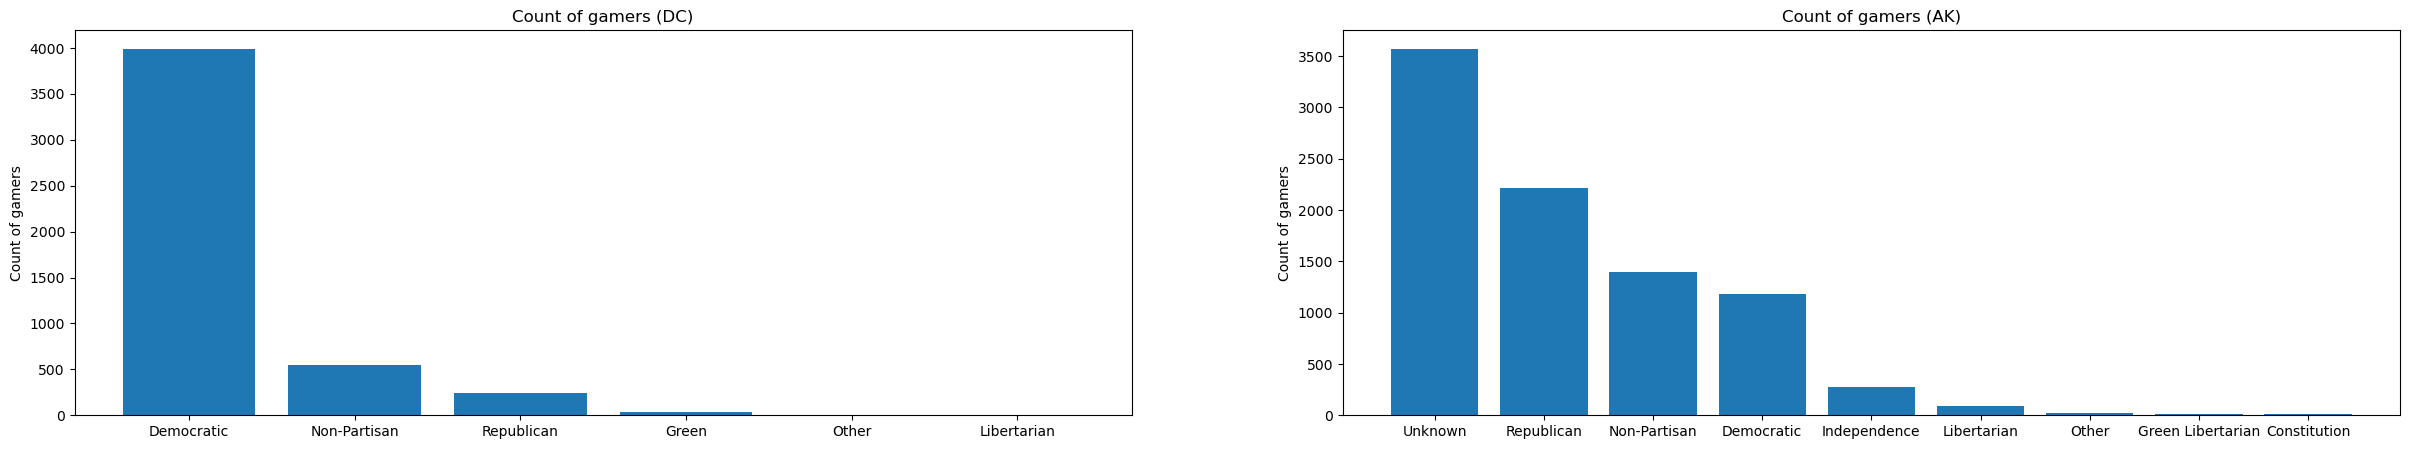

In [232]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(30, 5)
ax[0].bar(dc_gamers['Party'], dc_gamers['count'])
ax[0].set_ylabel('Count of gamers')
ax[0].set_title('Count of gamers (DC)')
ax[1].bar(alaskans_gamers['Party'], alaskans_gamers['count'])
ax[1].set_ylabel('Count of gamers')
ax[1].set_title('Count of gamers (AK)')
plt.show()

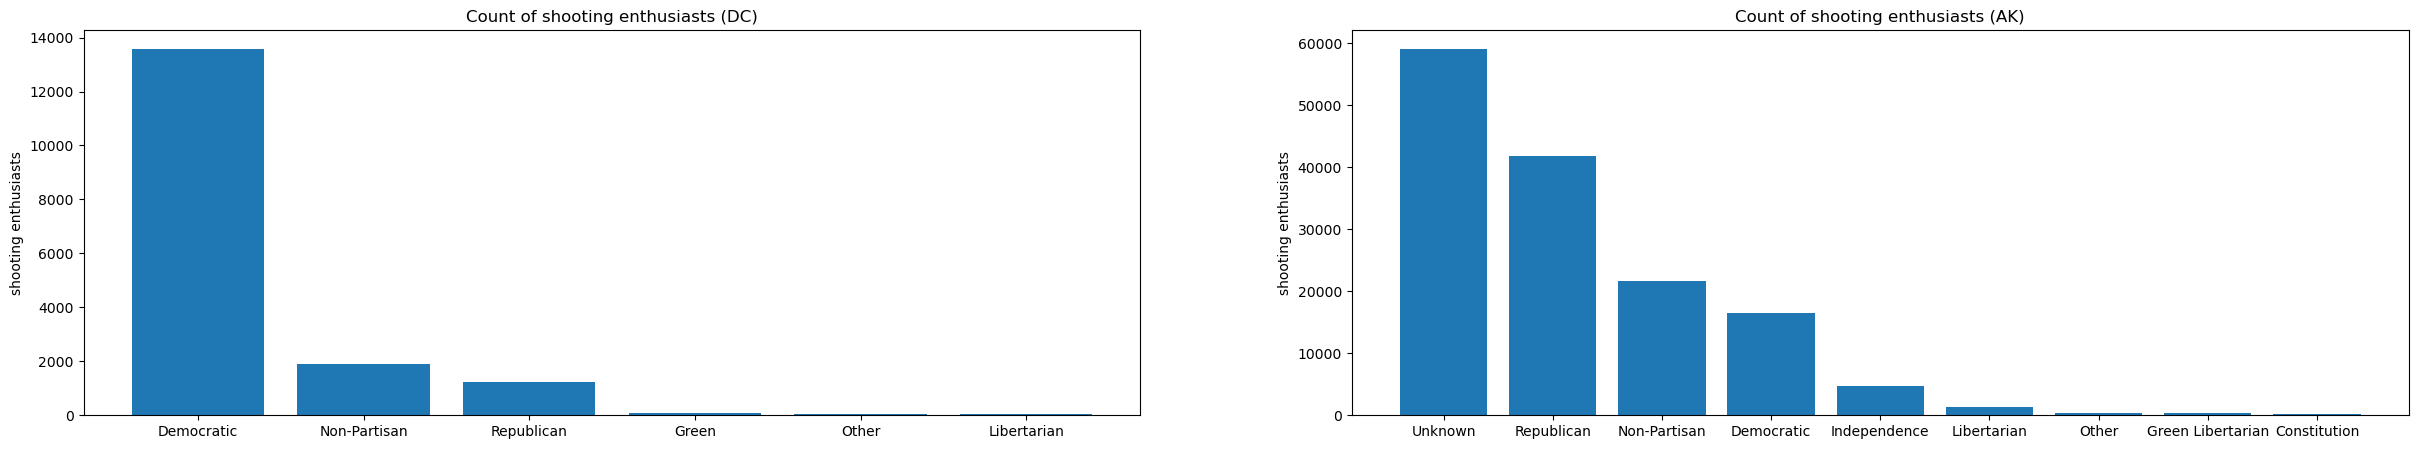

In [233]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(30, 5)
ax[0].bar(dc_shooting['Party'], dc_shooting['count'])
ax[0].set_ylabel('shooting enthusiasts')
ax[0].set_title('Count of shooting enthusiasts (DC)')
ax[1].bar(alaskans_shooting['Party'], alaskans_shooting['count'])
ax[1].set_ylabel('shooting enthusiasts')
ax[1].set_title('Count of shooting enthusiasts (AK)')
plt.show()

1) Comparing the proportion of gamers who are more likely to vote between DC and Alaska

2) Comparing the proportion of shooting enthusiasts who are more likely to vote between DC and Alaska

In [234]:
alaskans_gamers1 = ak.filter(ak.EGame_Interest == "Yes")\
.groupby("Primary_Proportion_Voted").count()

alaskans_shooting1 = ak.filter(ak.Interest_in_shooting == "Yes")\
.groupby("Primary_Proportion_Voted").count()

In [235]:
alaskans_gamers1.show()

+------------------------+-----+
|Primary_Proportion_Voted|count|
+------------------------+-----+
|                     33%|  113|
|                     66%|   34|
|                     83%|   12|
|                      0%| 3374|
|                     85%|  576|
|                     57%|  625|
|                     71%|  564|
|                    100%|  735|
|                     20%|   64|
|                     80%|   17|
|                     16%|   80|
|                     60%|   20|
|                     25%|  116|
|                     75%|   24|
|                     42%|  615|
|                     28%|  673|
|                     50%|  152|
|                     14%|  856|
|            Not Eligible|   76|
|                     40%|   51|
+------------------------+-----+



In [236]:
alaskans_shooting1.show()

+------------------------+-----+
|Primary_Proportion_Voted|count|
+------------------------+-----+
|                     33%| 1982|
|                     66%|  740|
|                     83%|  196|
|                      0%|55065|
|                     85%| 9316|
|                     57%|10502|
|                     71%| 9930|
|                    100%|11022|
|                     20%| 1367|
|                     80%|  251|
|                     16%| 1450|
|                     60%|  411|
|                     25%| 1954|
|                     75%|  370|
|                     42%|11165|
|                     28%|11642|
|                     50%| 2645|
|                     14%|13600|
|            Not Eligible| 1426|
|                     40%|  710|
+------------------------+-----+



In [237]:
alaskans_gamers1 = alaskans_gamers1.select(regexp_replace(col("Primary_Proportion_Voted"), "%", "")
                                         .alias("Primary_Proportion_Voted"),col("count"))
alaskans_gamers1 = alaskans_gamers1.withColumn("Primary_Proportion_Voted", col("Primary_Proportion_Voted").cast(LongType()))
alaskans_gamers_vote = alaskans_gamers1.filter(alaskans_gamers1.Primary_Proportion_Voted>50)
alaskans_gamers_vote = alaskans_gamers_vote.withColumnRenamed("count", "gamers")

The number of gamers who have a high probability to vote

In [238]:
alaskans_gamers_vote.agg({"gamers": "sum"}).show()

+-----------+
|sum(gamers)|
+-----------+
|       2607|
+-----------+



Total number of gamers

In [239]:
alaskans_gamers1.agg({"count": "sum"}).show()

+----------+
|sum(count)|
+----------+
|      8777|
+----------+



The percentage of gamers who are likely to vote

In [240]:
2607/8777

0.29702631878774066

In [241]:
alaskans_shooting1 = alaskans_shooting1.select(regexp_replace(col("Primary_Proportion_Voted"), "%", "")
                                         .alias("Primary_Proportion_Voted"),col("count"))
alaskans_shooting1 = alaskans_shooting1.withColumn("Primary_Proportion_Voted", col("Primary_Proportion_Voted").cast(LongType()))
alaskans_shooting_voters = alaskans_shooting1.filter(alaskans_shooting1.Primary_Proportion_Voted>50)
alaskans_shooting_voters = alaskans_shooting_voters.withColumnRenamed("count", "shooters")

In [242]:
alaskans_shooting1.show()

+------------------------+-----+
|Primary_Proportion_Voted|count|
+------------------------+-----+
|                      33| 1982|
|                      66|  740|
|                      83|  196|
|                       0|55065|
|                      85| 9316|
|                      57|10502|
|                      71| 9930|
|                     100|11022|
|                      20| 1367|
|                      80|  251|
|                      16| 1450|
|                      60|  411|
|                      25| 1954|
|                      75|  370|
|                      42|11165|
|                      28|11642|
|                      50| 2645|
|                      14|13600|
|                    null| 1426|
|                      40|  710|
+------------------------+-----+



In [243]:
alaskans_shooting_voters.show()

+------------------------+--------+
|Primary_Proportion_Voted|shooters|
+------------------------+--------+
|                      66|     740|
|                      83|     196|
|                      85|    9316|
|                      57|   10502|
|                      71|    9930|
|                     100|   11022|
|                      80|     251|
|                      60|     411|
|                      75|     370|
+------------------------+--------+



Finding the amount of alaskans who are interested in shooting and are more likely to vote

In [244]:
alaskans_shooting_voters.agg({"shooters": "sum"}).show()

+-------------+
|sum(shooters)|
+-------------+
|        42738|
+-------------+



Total amount of alaskans interested in shooting

In [245]:
alaskans_shooting1.agg({"count": "sum"}).show()

+----------+
|sum(count)|
+----------+
|    145744|
+----------+



The percentage of alaskans interested in shooting who are likely to vote

In [246]:
42738/145744

0.2932402019980239

In [247]:
dc_gamers1 = dc.filter(dc.EGame_Interest == "Yes")\
.groupby("Primary_Proportion_Voted").count()

dc_shooting1 = dc.filter(dc.Interest_in_shooting == "Yes")\
.groupby("Primary_Proportion_Voted").count()

In [248]:
dc_gamers1.show()

+------------------------+-----+
|Primary_Proportion_Voted|count|
+------------------------+-----+
|                     33%|   65|
|                     66%|   31|
|                     83%|    9|
|                      0%| 2054|
|                     85%|  269|
|                     57%|  278|
|                     71%|  271|
|                    100%|  318|
|                     20%|   25|
|                     16%|   56|
|                     60%|    7|
|                     25%|   41|
|                     75%|   16|
|                     42%|  322|
|                     28%|  371|
|                     50%|   69|
|                     14%|  519|
|            Not Eligible|   87|
|                     40%|   14|
|                     80%|   10|
+------------------------+-----+



In [249]:
dc_shooting1.show()

+------------------------+-----+
|Primary_Proportion_Voted|count|
+------------------------+-----+
|                     33%|  373|
|                     66%|  188|
|                     83%|   32|
|                      0%| 5960|
|                     85%| 1147|
|                     57%| 1148|
|                     71%| 1185|
|                    100%| 1296|
|                     20%|  117|
|                     80%|   30|
|                     16%|  163|
|                     60%|   50|
|                     25%|  230|
|                     75%|   98|
|                     42%| 1193|
|                     28%| 1322|
|                     50%|  417|
|                     14%| 1600|
|            Not Eligible|  287|
|                     40%|   60|
+------------------------+-----+



Finding the amount of dc citizens who are interested in gaming and are more likely to vote

The percentage of dc citizens interested in shooting who are likely to vote

In [250]:
dc_shooting1 = dc_shooting1.select(regexp_replace(col("Primary_Proportion_Voted"), "%", "")
                                         .alias("Primary_Proportion_Voted"),col("count"))
dc_shooting1 = dc_shooting1.withColumn("Primary_Proportion_Voted", col("Primary_Proportion_Voted").cast(LongType()))
dc_shooting_vote = dc_shooting1.filter(dc_shooting1.Primary_Proportion_Voted>50)
dc_shooting_vote = dc_shooting_vote.withColumnRenamed("count", "shooters")

Finding the amount of dc citizens who are interested in shooting and are more likely to vote

In [251]:
dc_shooting_vote.agg({"shooters": "sum"}).show()

+-------------+
|sum(shooters)|
+-------------+
|         5174|
+-------------+



Total amount of alaskans interested in shooting

So the percentage of both gamers and shooting enthusiasts who are more likely to vote in the presidential elections are relatively the same, around 30% in Alaska and slightly different in DC where only 25% of gamers are interested in voting in comparisson to 30% of shooters.

In both DC and Alaska the same percentage of shooting enthusiasts have a high likelyhood of voting.
Meanwhile there are less gamers in DC who are interested in voting than in Alaska

### MARITAL STATUS AND PARTY AFFILIATION

In [252]:
df_AK1 = spark.read\
.format("csv")\
.option("header", "true")\
.option("nullValue", "NA")\
.option("delimiter", "\t")\
.option("inferSchema", "true")\
.load('gs://final-proj-135/notebooks/jupyter/VM2Uniform--AK--2021-02-03.tab')

df_DC1 = spark.read\
.format("csv")\
.option("header", "true")\
.option("nullValue", "NA")\
.option("delimiter", "\t")\
.option("inferSchema", "true")\
.load('gs://final-proj-135/notebooks/jupyter/VM2Uniform--DC--2021-01-30.tab')

akdf = df_AK1.select(['Voters_Gender', 'Voters_Age', 'Parties_Description',
                      'Ethnic_Description', "MaritalStatus_Description", "CommercialDataLL_Home_Owner_Or_Renter", 'Voters_VotingPerformanceEvenYearPrimary'])
dcdf = df_DC1.select(['Voters_Gender', 'Voters_Age', 'Parties_Description',
                      'Ethnic_Description', "MaritalStatus_Description", "CommercialDataLL_Home_Owner_Or_Renter", 'Voters_VotingPerformanceEvenYearPrimary'])

akrenamed = akdf.withColumnRenamed("Voters_Gender", "Gender")\
            .withColumnRenamed("Voters_Age", "Age")\
            .withColumnRenamed("Parties_Description", "Party")\
            .withColumnRenamed("Ethnic_Description", "Ethnicity")\
            .withColumnRenamed("MaritalStatus_Description", "MaritalStatus")\
            .withColumnRenamed("CommercialDataLL_Home_Owner_Or_Renter", "HomeOwnerorRenter")\
            .withColumnRenamed("Voters_VotingPerformanceEvenYearPrimary", "Primary Vote")
        
dcrenamed = dcdf.withColumnRenamed("Voters_Gender", "Gender")\
            .withColumnRenamed("Voters_Age", "Age")\
            .withColumnRenamed("Parties_Description", "Party")\
            .withColumnRenamed("Ethnic_Description", "Ethnicity")\
            .withColumnRenamed("MaritalStatus_Description", "MaritalStatus")\
            .withColumnRenamed("CommercialDataLL_Home_Owner_Or_Renter", "HomeOwnerorRenter")\
            .withColumnRenamed("Voters_VotingPerformanceEvenYearPrimary", "Primary Vote")

In [253]:
DCMarried = dcrenamed.select('MaritalStatus', 'Party').groupby(dcrenamed.MaritalStatus).count().sort("count", ascending=False)
DCMarried = DCMarried.toPandas()
DCMarried.fillna("Unknown",inplace=True)

AKMarried = akrenamed.select('MaritalStatus', 'Party').groupby(akrenamed.MaritalStatus).count().sort("count", ascending=False)
AKMarried = AKMarried.toPandas()
AKMarried.fillna("Unknown",inplace=True)

DCMarried
AKMarried

,MaritalStatus,count
0,Unknown,451313
1,Married,79352
2,Non-Traditional,17594


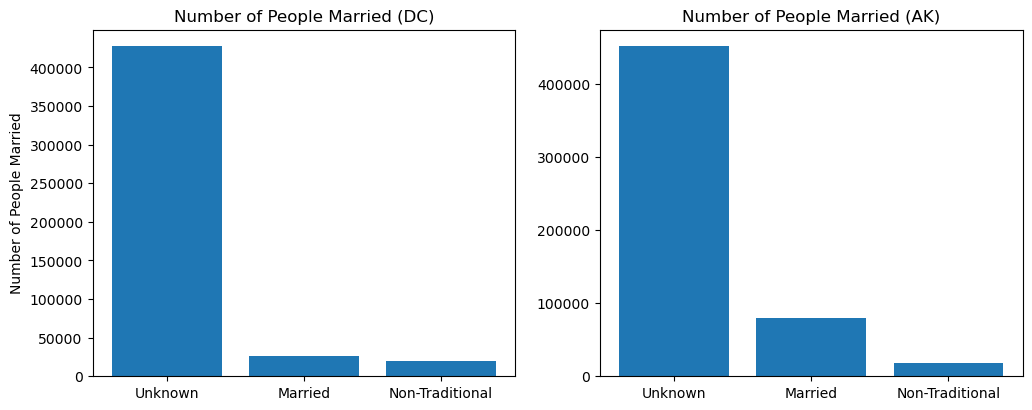

In [254]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4.5)
ax[0].bar(DCMarried['MaritalStatus'], DCMarried['count'])
ax[0].set_ylabel('Number of People Married')
ax[0].set_title('Number of People Married (DC)')
ax[1].bar(AKMarried['MaritalStatus'], AKMarried['count'])
ax[1].set_title('Number of People Married (AK)')
plt.show()

In [255]:
DCMarriage = dcrenamed.select('Party', 'MaritalStatus').groupby(dcrenamed.Party).count().sort("count", ascending=False)
DCMarriage = DCMarriage.toPandas()
DCMarriage.fillna("Unknown",inplace=True)

AKMarriage = akrenamed.select('Party', 'MaritalStatus').groupby(akrenamed.Party).count().sort("count", ascending=False)
AKMarriage = AKMarriage.toPandas()
AKMarriage.fillna("Unknown",inplace=True)

In [256]:
akrenamed.select('Party').where('Party == "Unknown"').count()

237742

+------------+-----+
|       Party|count|
+------------+-----+
|  Republican| 2103|
|       Other|   37|
| Libertarian|   42|
|       Green|  129|
|  Democratic|21119|
|Non-Partisan| 3132|
+------------+-----+



+-----------------+-----+
|            Party|count|
+-----------------+-----+
|     Constitution|   46|
|       Republican|28545|
|     Independence| 1965|
|          Unknown|25436|
|            Other|  136|
|      Libertarian|  569|
|Green Libertarian|   83|
|       Democratic| 8861|
|     Non-Partisan|13711|
+-----------------+-----+



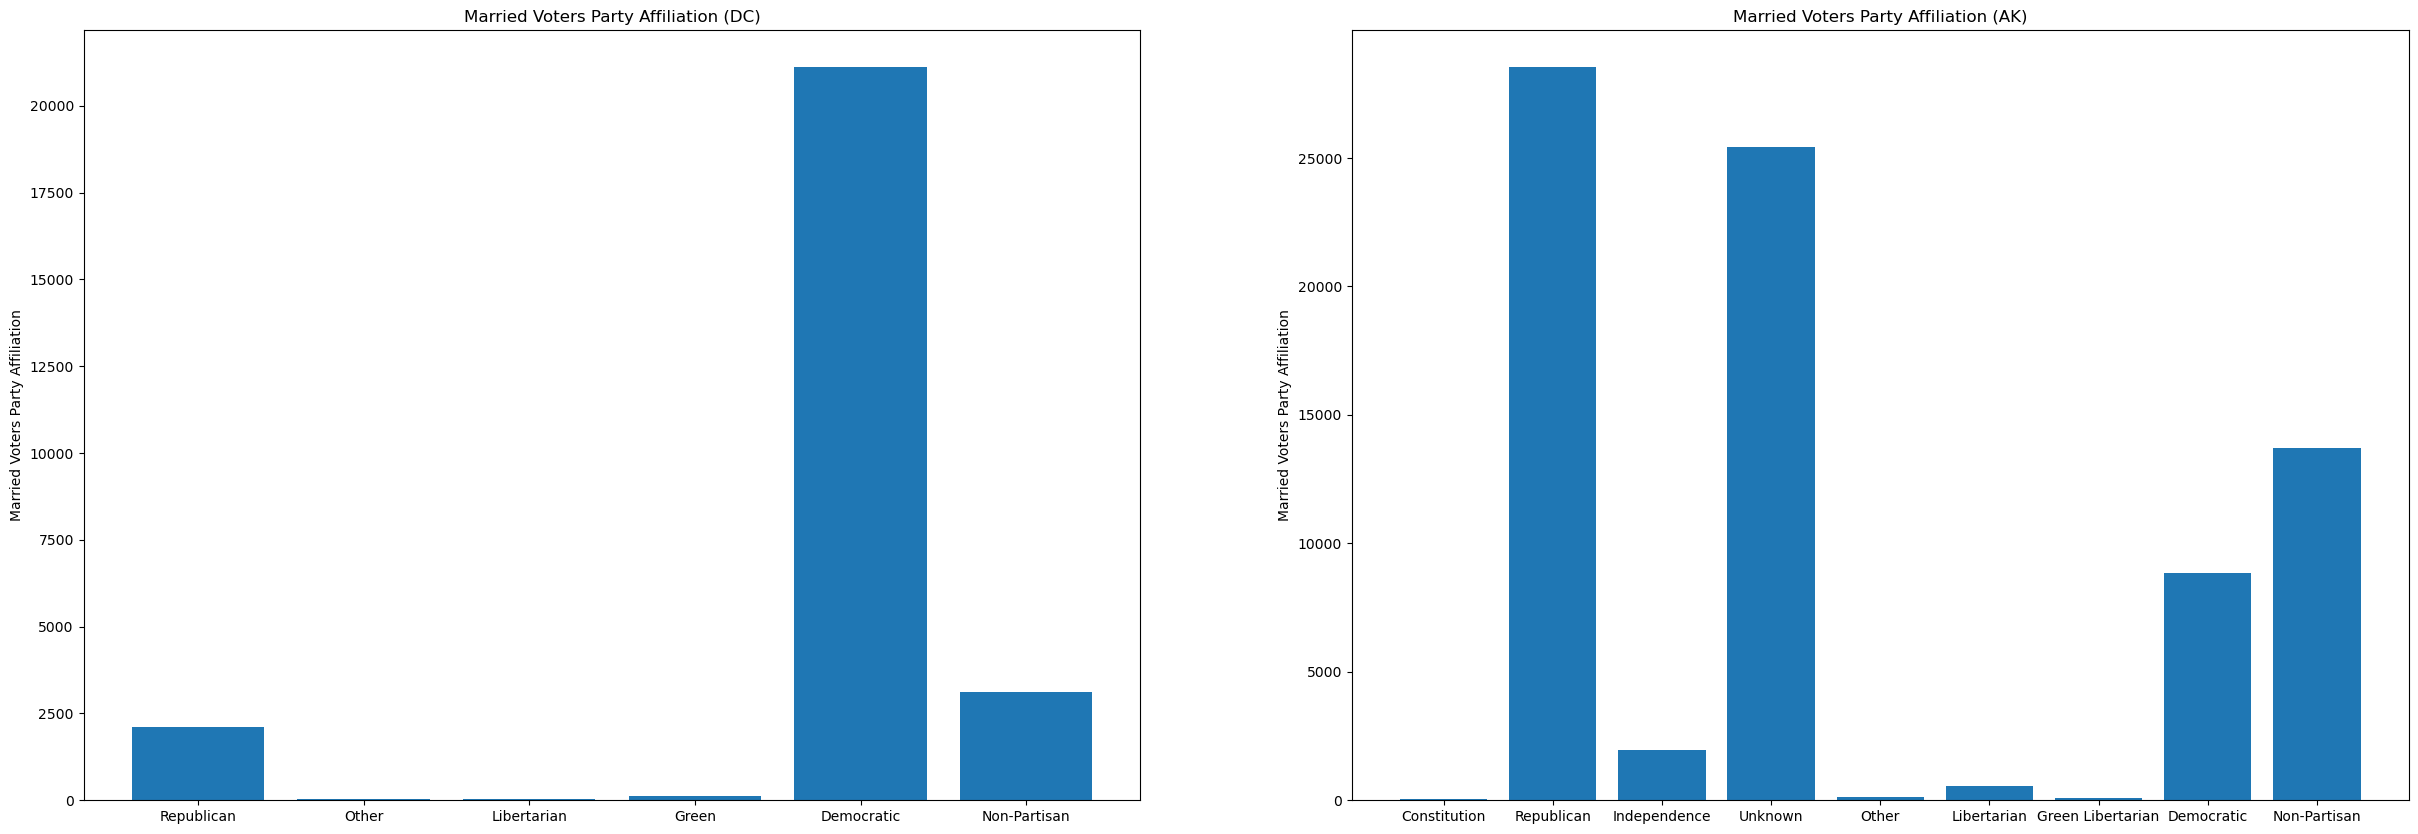

In [257]:
DCMarriagefilter = dcrenamed.filter(dcrenamed.MaritalStatus == "Married").groupby("Party").count()

AKMarriagefilter = akrenamed.filter(akrenamed.MaritalStatus == "Married").groupby("Party").count()

DCMarriagefilter.show()
AKMarriagefilter.show()

DCMarriagefilter = DCMarriagefilter.toPandas()
AKMarriagefilter = AKMarriagefilter.toPandas()

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(30, 10)
ax[0].bar(DCMarriagefilter['Party'], DCMarriagefilter['count'])
ax[0].set_ylabel('Married Voters Party Affiliation')
ax[0].set_title('Married Voters Party Affiliation (DC)')
ax[1].bar(AKMarriagefilter['Party'], AKMarriagefilter['count'])
ax[1].set_ylabel('Married Voters Party Affiliation')
ax[1].set_title('Married Voters Party Affiliation (AK)')
plt.show()

Voters who are married in DC tend to be Democratic whereas voters in AK tend to be Republican. However, AK has a lot of Unknown values which could be Democratic. ue to AK being a red state, it is unlikely.

+------------+-----+
|       Party|count|
+------------+-----+
|  Republican|  843|
|       Other|   27|
| Libertarian|   43|
|       Green|  139|
|  Democratic|16132|
|Non-Partisan| 2698|
+------------+-----+



+-----------------+-----+
|            Party|count|
+-----------------+-----+
|       Republican| 3396|
|     Independence|  507|
|          Unknown| 6464|
|            Other|   42|
|      Libertarian|  161|
|Green Libertarian|   66|
|       Democratic| 3569|
|     Non-Partisan| 3384|
|     Constitution|    5|
+-----------------+-----+



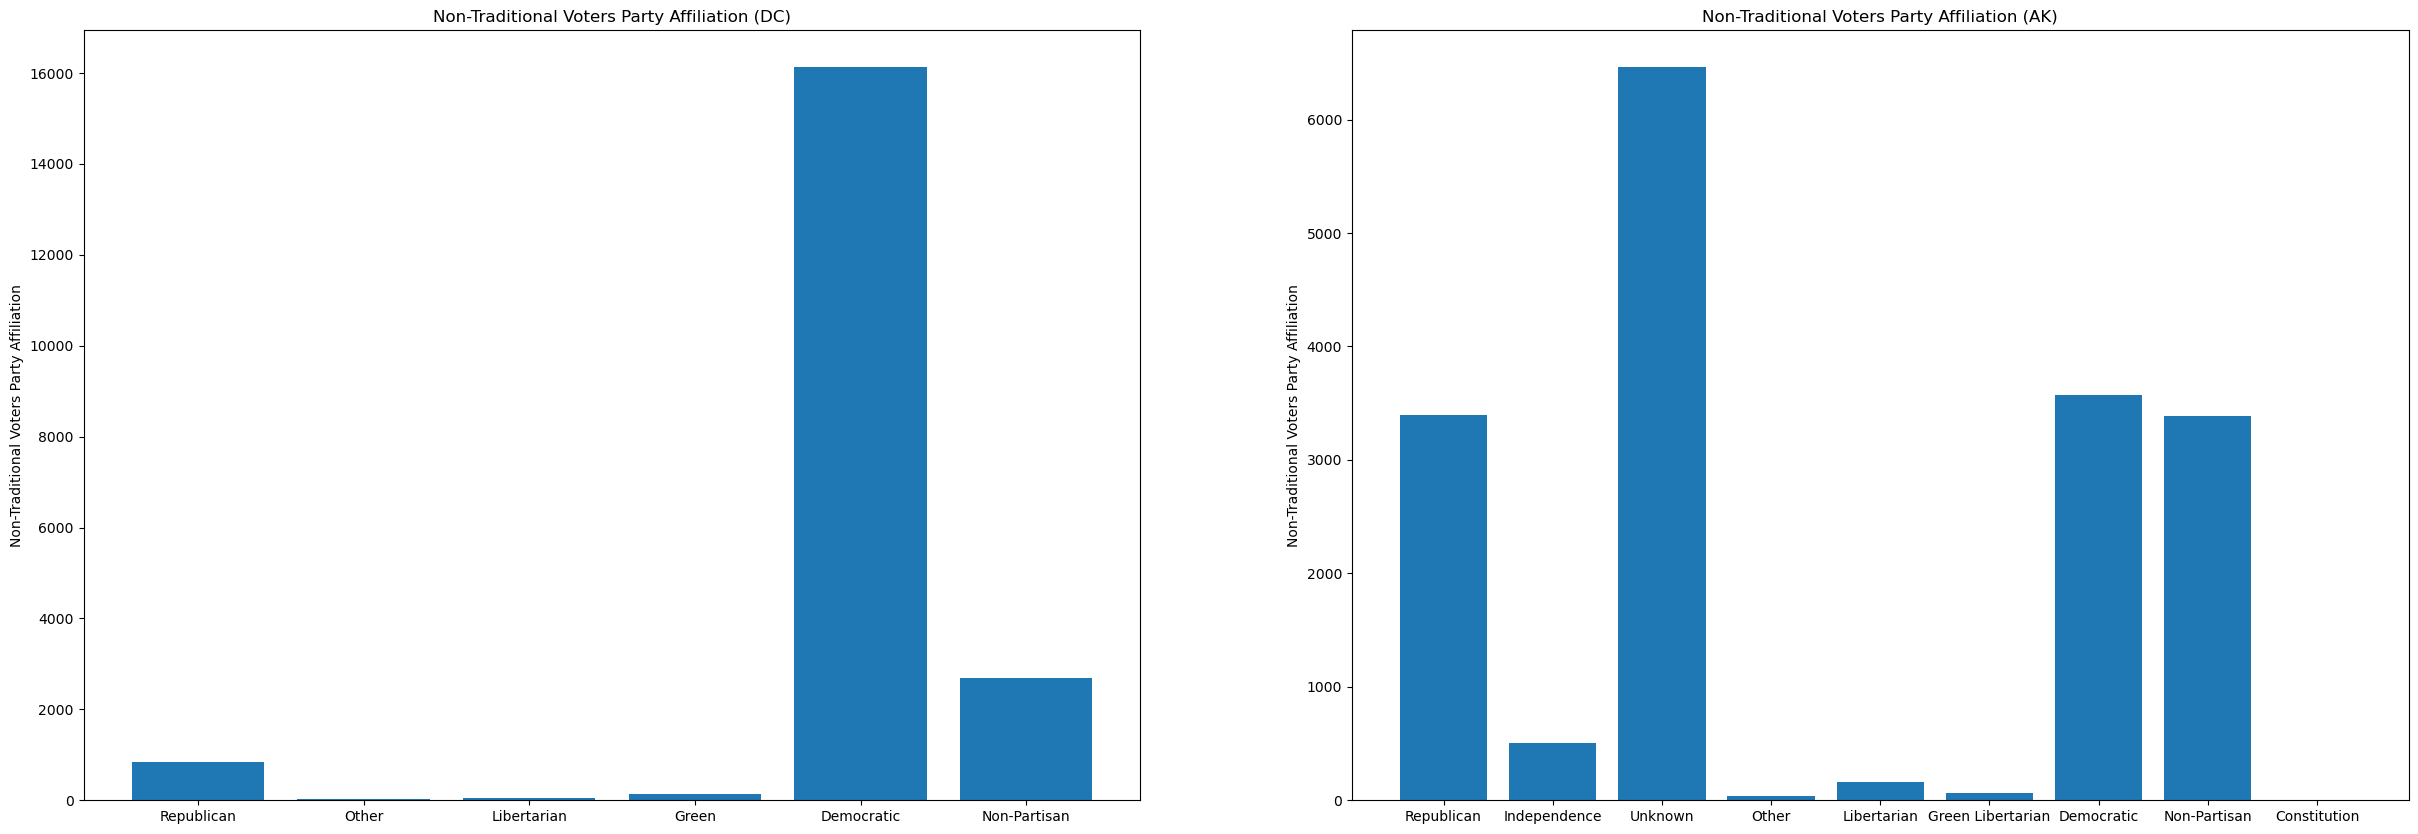

In [258]:
DCNonTradfilter = dcrenamed.filter(dcrenamed.MaritalStatus == "Non-Traditional").groupby("Party").count()

AKNonTradfilter = akrenamed.filter(akrenamed.MaritalStatus == "Non-Traditional").groupby("Party").count()

DCNonTradfilter.show()
AKNonTradfilter.show()

DCNonTradfilter = DCNonTradfilter.toPandas()
AKNonTradfilter = AKNonTradfilter.toPandas()

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(30, 10)
ax[0].bar(DCNonTradfilter['Party'], DCNonTradfilter['count'])
ax[0].set_ylabel('Non-Traditional Voters Party Affiliation')
ax[0].set_title('Non-Traditional Voters Party Affiliation (DC)')
ax[1].bar(AKNonTradfilter['Party'], AKNonTradfilter['count'])
ax[1].set_ylabel('Non-Traditional Voters Party Affiliation')
ax[1].set_title('Non-Traditional Voters Party Affiliation (AK)')
plt.show()

Non-Traditional Voters in DC lean towards Democratic in DC. In AK, Democratic party actually is higher than Republican by a small amount.

### HOMEOWNERS AND PARTY AFFILIATION

In [259]:
dcrenamed.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dcrenamed.columns]).show()
akrenamed.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in akrenamed.columns]).show()

+------+------+-----+---------+-------------+-----------------+------------+
|Gender|   Age|Party|Ethnicity|MaritalStatus|HomeOwnerorRenter|Primary Vote|
+------+------+-----+---------+-------------+-----------------+------------+
| 19601|193536|    0|    37325|       427469|            71185|           0|
+------+------+-----+---------+-------------+-----------------+------------+



+------+------+-----+---------+-------------+-----------------+------------+
|Gender|   Age|Party|Ethnicity|MaritalStatus|HomeOwnerorRenter|Primary Vote|
+------+------+-----+---------+-------------+-----------------+------------+
|    66|215368|    0|    71026|       451313|           198182|           0|
+------+------+-----+---------+-------------+-----------------+------------+



In [260]:
DCOwner = dcrenamed.select('HomeOwnerorRenter', 'Party').groupby(dcrenamed.HomeOwnerorRenter).count().sort("count", ascending=False)
DCOwner = DCOwner.toPandas()
DCOwner.fillna("Unknown",inplace=True)

AKOwner = akrenamed.select('HomeOwnerorRenter', 'Party').groupby(akrenamed.HomeOwnerorRenter).count().sort("count", ascending=False)
AKOwner = AKOwner.toPandas()
AKOwner.fillna("Unknown",inplace=True)

DCOwner
AKOwner

,HomeOwnerorRenter,count
0,Unknown,198182
1,Likely Renter,179858
2,Likely Homeowner,170219


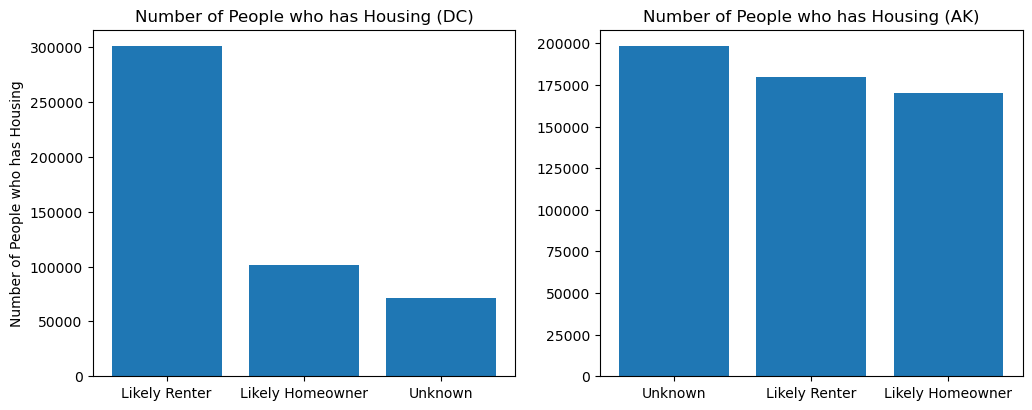

In [261]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4.5)
ax[0].bar(DCOwner['HomeOwnerorRenter'], DCOwner['count'])
ax[0].set_ylabel('Number of People who has Housing')
ax[0].set_title('Number of People who has Housing (DC)')
ax[1].bar(AKOwner['HomeOwnerorRenter'], AKOwner['count'])
ax[1].set_title('Number of People who has Housing (AK)')
plt.show()

+------------+-----+
|       Party|count|
+------------+-----+
|  Republican| 6109|
|       Other|  179|
| Libertarian|  242|
|       Green|  585|
|  Democratic|81777|
|Non-Partisan|12958|
+------------+-----+



+-----------------+-----+
|            Party|count|
+-----------------+-----+
|     Constitution|   86|
|       Republican|49623|
|     Independence| 4534|
|          Unknown|63526|
|            Other|  367|
|      Libertarian| 1474|
|Green Libertarian|  312|
|       Democratic|22280|
|     Non-Partisan|28017|
+-----------------+-----+



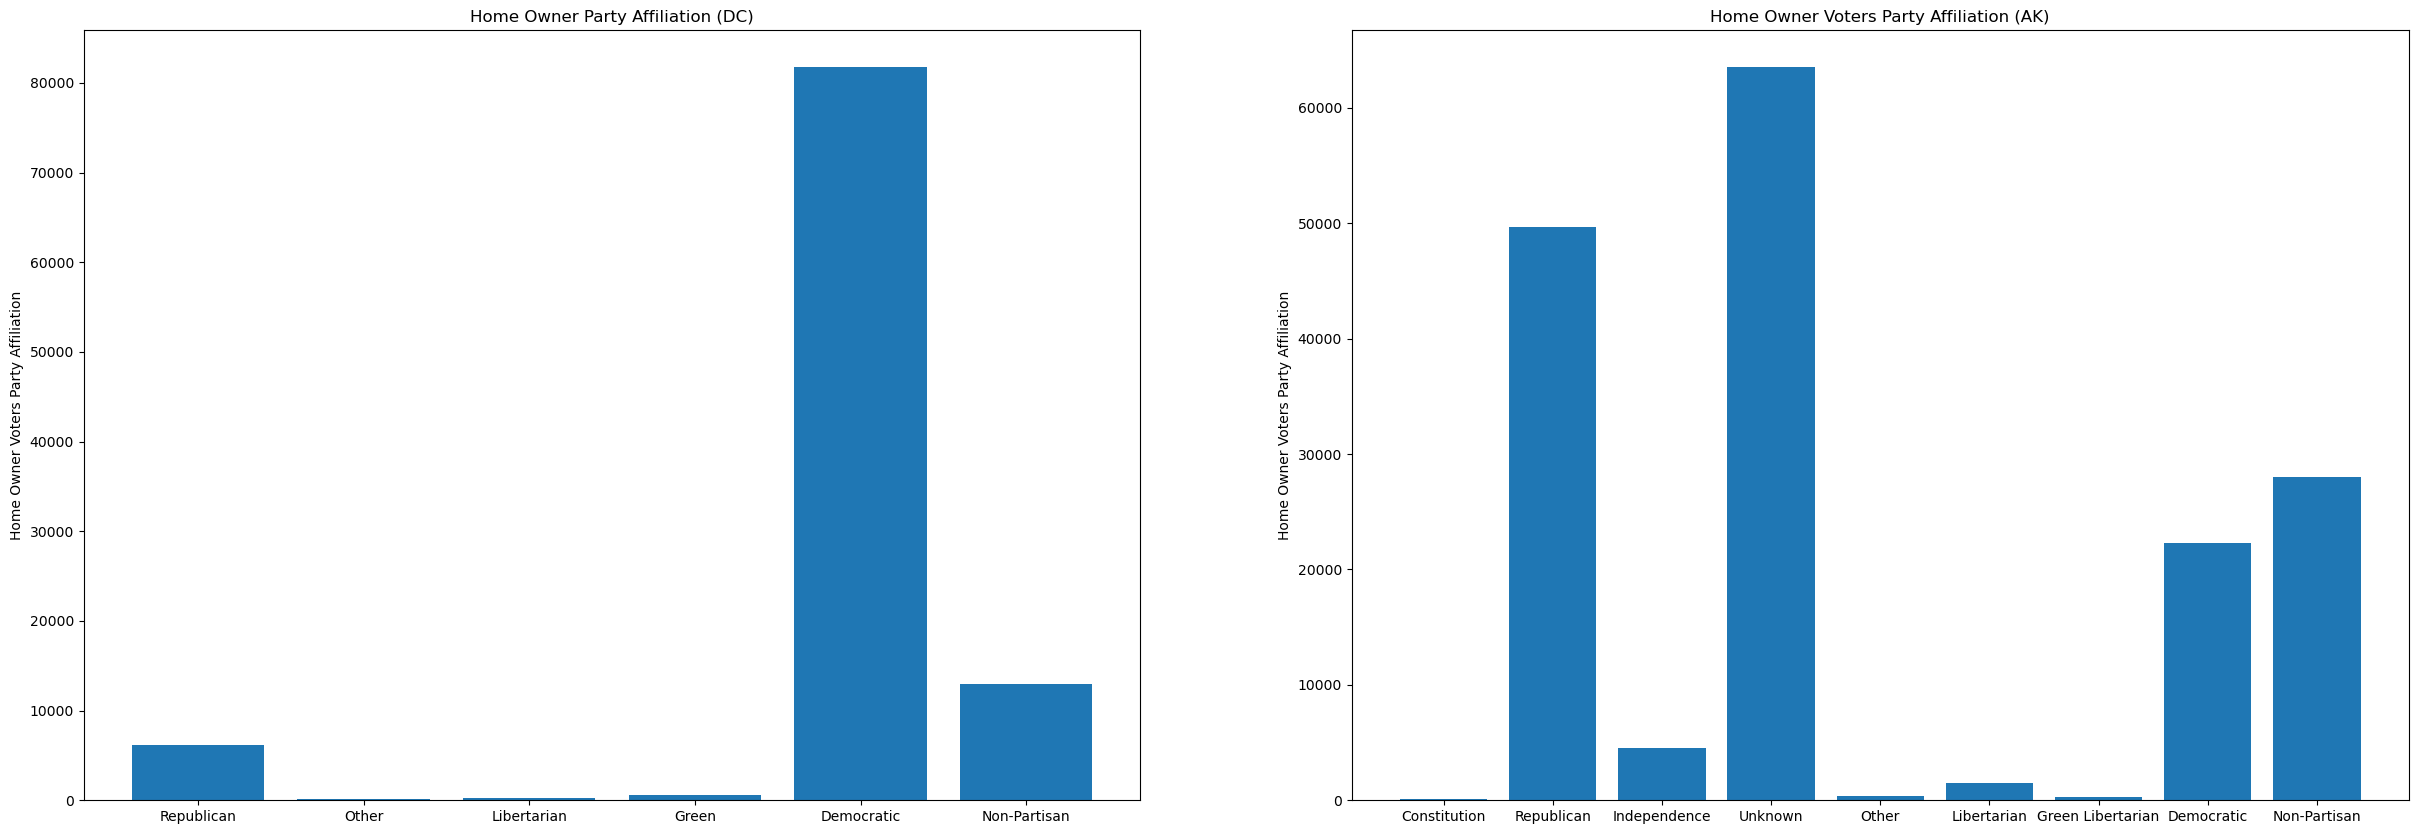

In [262]:
DCHomeOwner = dcrenamed.filter(dcrenamed.HomeOwnerorRenter == "Likely Homeowner").groupby("Party").count()

AKHomeOwner = akrenamed.filter(akrenamed.HomeOwnerorRenter == "Likely Homeowner").groupby("Party").count()

DCHomeOwner.show()
AKHomeOwner.show()

DCHomeOwner = DCHomeOwner.toPandas()
AKHomeOwner = AKHomeOwner.toPandas()

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(30, 10)
ax[0].bar(DCHomeOwner['Party'], DCHomeOwner['count'])
ax[0].set_ylabel('Home Owner Voters Party Affiliation')
ax[0].set_title('Home Owner Party Affiliation (DC)')
ax[1].bar(AKHomeOwner['Party'], AKHomeOwner['count'])
ax[1].set_ylabel('Home Owner Voters Party Affiliation')
ax[1].set_title('Home Owner Voters Party Affiliation (AK)')
plt.show()

Home Owners in DC are more Democratic but Home Owners in AK are more Republican.

+------------+------+
|       Party| count|
+------------+------+
|  Republican| 16024|
|       Other|  1044|
| Libertarian|  1329|
|       Green|  2382|
|  Democratic|229504|
|Non-Partisan| 50595|
+------------+------+



+-----------------+-----+
|            Party|count|
+-----------------+-----+
|     Constitution|  257|
|       Republican|34999|
|     Independence| 6189|
|          Unknown|86216|
|            Other|  762|
|      Libertarian| 2434|
|Green Libertarian|  530|
|       Democratic|26453|
|     Non-Partisan|22018|
+-----------------+-----+



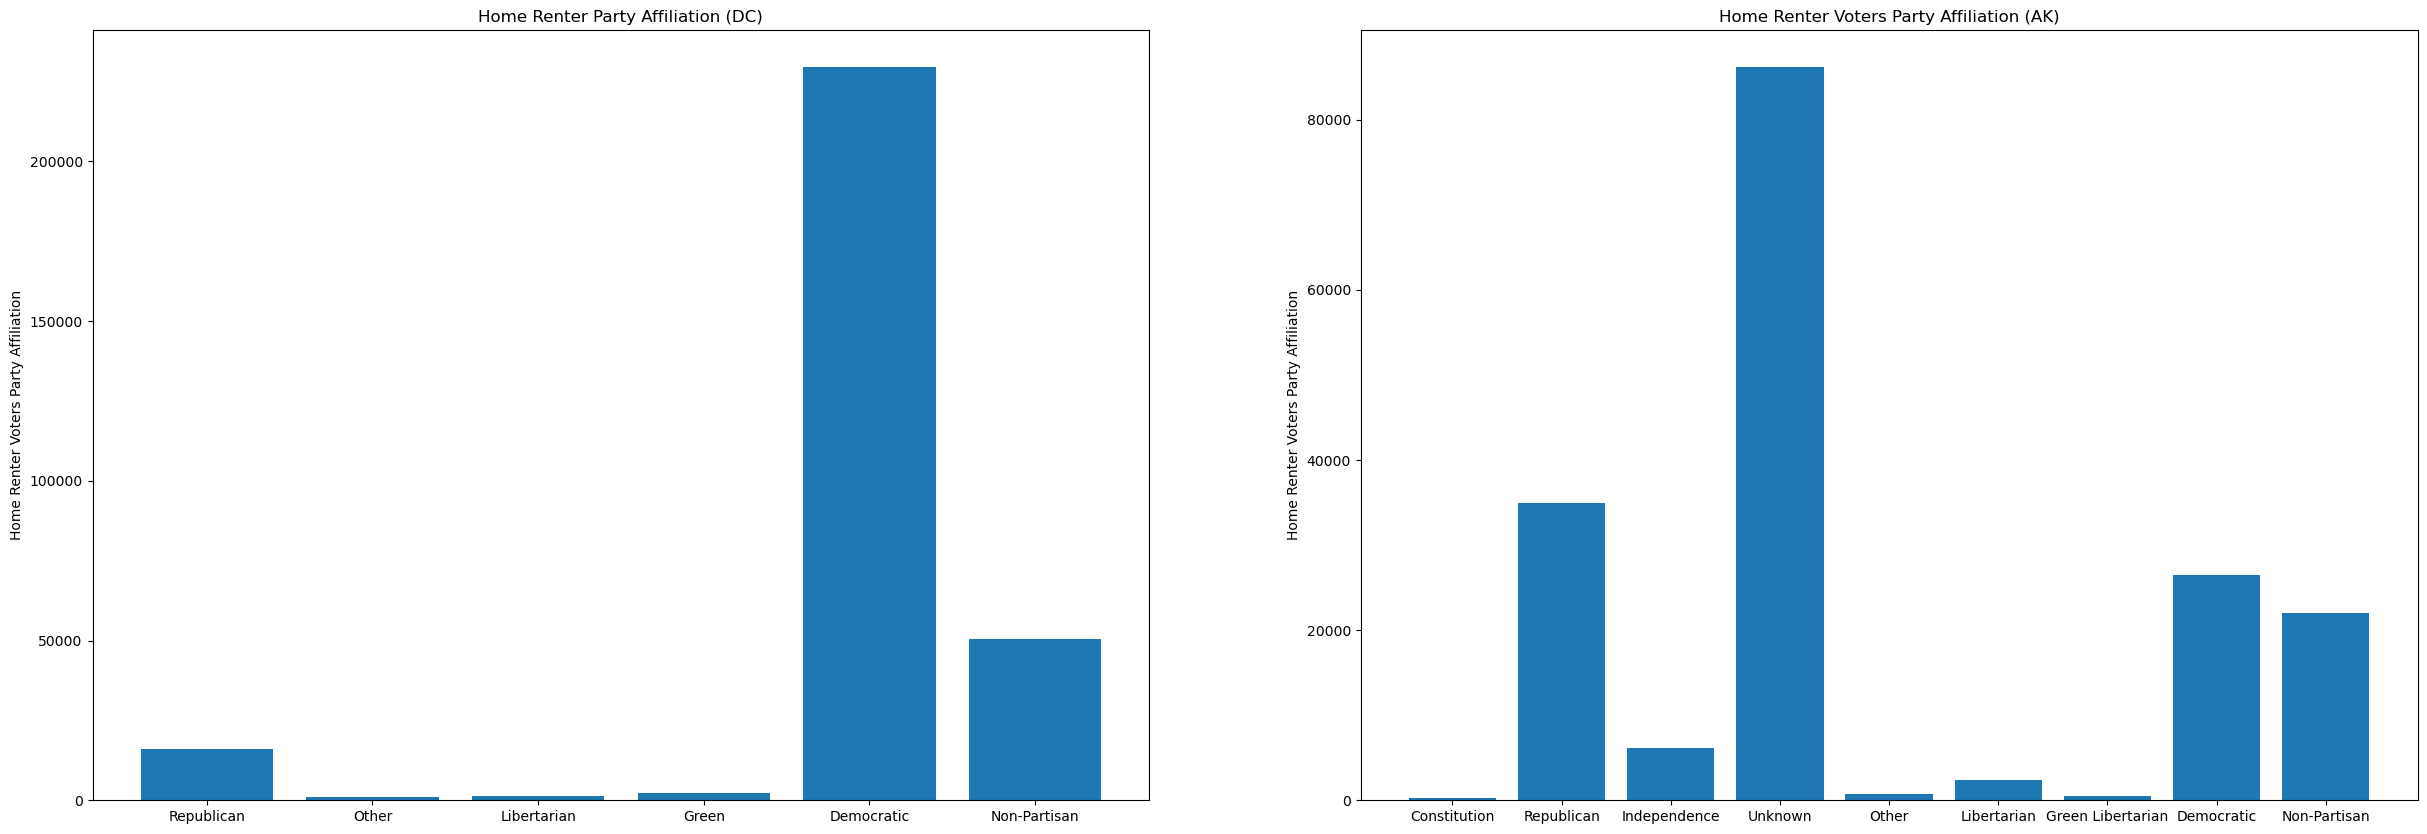

In [263]:
DCHomeRenter = dcrenamed.filter(dcrenamed.HomeOwnerorRenter == "Likely Renter").groupby("Party").count()

AKHomeRenter = akrenamed.filter(akrenamed.HomeOwnerorRenter == "Likely Renter").groupby("Party").count()

DCHomeRenter.show()
AKHomeRenter.show()

DCHomeRenter = DCHomeRenter.toPandas()
AKHomeRenter = AKHomeRenter.toPandas()

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(30, 10)
ax[0].bar(DCHomeRenter['Party'], DCHomeRenter['count'])
ax[0].set_ylabel('Home Renter Voters Party Affiliation')
ax[0].set_title('Home Renter Party Affiliation (DC)')
ax[1].bar(AKHomeRenter['Party'], AKHomeRenter['count'])
ax[1].set_ylabel('Home Renter Voters Party Affiliation')
ax[1].set_title('Home Renter Voters Party Affiliation (AK)')
plt.show()

Home Renters are more Democratic in DC but there is a smaller gap between the Republican Party and Democratic Party in AK.

## First Attempt At Fitting Models

We decided to keep all the columns we have selected for EDA. For the sake of efficiency and accuracy, we have decided to drop all rows that do not have values for Age, Gender, Ethnicity, and Religion as we believe these will be important for classification. We have also decided to filter ethnicity and religion to contain only the top five of both and label all the other ethnicity and religion as "Other" so we can minimize computation time for the models.

In [264]:
df_DC = df_DC.drop('Birthdate', 'Military_Status', 'Primary2020', 'Primary_Proportion_Voted')
df_AK = df_AK.drop('Birthdate', 'Military_Status', 'Primary2020', 'Primary_Proportion_Voted')
df_DC = df_DC.na.fill(value = 'Unknown', subset = 'Home_Owner_Or_Renter')
df_AK = df_AK.na.fill(value = 'Unknown', subset = 'Home_Owner_Or_Renter')
df_DC = df_DC.dropna(subset=['Age', 'Gender', 'Ethnicity', 'Religion'])
df_AK = df_AK.dropna(subset=['Age', 'Gender', 'Ethnicity', 'Religion'])
df_DC = df_DC.withColumn("Ethnicity", when(df_DC.Ethnicity == 'Likely Af-Am (Modeled)', 'Likely Af-Am (Modeled)') \
                          .when(df_DC.Ethnicity == 'English/Welsh', 'English/Welsh') \
                          .when(df_DC.Ethnicity == 'Hispanic', 'Hispanic') \
                          .when(df_DC.Ethnicity == 'German', 'German') \
                          .when(df_DC.Ethnicity == 'Irish', 'Irish') \
                          .when(df_DC.Ethnicity == 'Unknown', 'Unknown') \
                          .otherwise('Other'))   
df_AK = df_AK.withColumn("Ethnicity", when(df_AK.Ethnicity == 'English/Welsh', 'English/Welsh') \
                          .when(df_AK.Ethnicity == 'German', 'German') \
                          .when(df_AK.Ethnicity == 'Irish', 'Irish') \
                          .when(df_AK.Ethnicity == 'Hispanic', 'Hispanic') \
                          .when(df_AK.Ethnicity == 'Scots', 'Scots') \
                          .otherwise('Other'))
df_DC = df_DC.withColumn("Religion", when(df_DC.Religion == 'Protestant', 'Protestant') \
                          .when(df_DC.Religion == 'Jewish', 'Jewish') \
                          .when(df_DC.Religion == 'Catholic', 'Catholic') \
                          .when(df_DC.Religion == 'Islamic', 'Islamic') \
                          .when(df_DC.Religion == 'Buddhist', 'Buddhist') \
                          .when(df_DC.Religion == 'Unknown', 'Unknown') \
                          .otherwise('Other'))   
df_AK = df_AK.withColumn("Religion", when(df_AK.Religion == 'Protestant', 'Protestant') \
                          .when(df_AK.Religion == 'Jewish', 'Jewish') \
                          .when(df_AK.Religion == 'Catholic', 'Catholic') \
                          .when(df_AK.Religion == 'Eastern Orthodox', 'Eastern Orthodox') \
                          .when(df_AK.Religion == 'Christian', 'Christian') \
                          .otherwise('Other'))

In [265]:
df_AK.count()

139165

In [266]:
df_DC.count()

114306

### Logistic Regression

### DC Model

In [267]:
supervised = RFormula(formula="Party ~ .")
fittedRF_LDC = supervised.fit(df_DC)
preparedDF_LDC = fittedRF_LDC.transform(df_DC)
train2, test2 = preparedDF_LDC.randomSplit([0.7, 0.3], seed=333)
lrD = LogisticRegression(labelCol="label", featuresCol="features")
lrModelD = lrD.fit(train2)
fittedTest2 = lrModelD.transform(test2)
y_true = fittedTest2.select(['label']).collect()
y_pred = fittedTest2.select(['prediction']).collect()
confusion_matrix(y_true, y_pred)

array([[28327,     0,     0,     0,     0,     0],
       [ 3771,     0,     0,     0,     0,     0],
       [ 1635,     0,     0,     0,     0,     0],
       [  237,     0,     0,     0,     0,     0],
       [   63,     0,     0,     0,     0,     0],
       [   48,     0,     0,     0,     0,     0]])

In [268]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91     28327
         1.0       0.00      0.00      0.00      3771
         2.0       0.00      0.00      0.00      1635
         3.0       0.00      0.00      0.00       237
         4.0       0.00      0.00      0.00        63
         5.0       0.00      0.00      0.00        48

    accuracy                           0.83     34081
   macro avg       0.14      0.17      0.15     34081
weighted avg       0.69      0.83      0.75     34081



### Alaska Model

In [269]:
supervised = RFormula(formula="Party ~ .")
fittedRF_LAK = supervised.fit(df_AK)
preparedDF_LAK = fittedRF_LAK.transform(df_AK)
train1, test1 = preparedDF_LAK.randomSplit([0.7, 0.3], seed=333)
lrA = LogisticRegression(labelCol="label", featuresCol="features")
lrModelA = lrA.fit(train1)
fittedTest1 = lrModelA.transform(test1)
y_true = fittedTest1.select(['label']).collect()
y_pred = fittedTest1.select(['prediction']).collect()
confusion_matrix(y_true, y_pred)

array([[10239,  4055,   104,   147,     0,     0,     0,     0,     0],
       [ 6863,  5132,    97,   120,     0,     0,     0,     0,     0],
       [ 4138,  2922,   104,   110,     0,     0,     0,     0,     0],
       [ 4005,  1666,    81,   139,     0,     0,     0,     0,     0],
       [  738,   333,    14,    20,     0,     0,     0,     0,     0],
       [  272,    62,     3,     1,     0,     0,     0,     0,     0],
       [   63,    12,     1,     0,     0,     0,     0,     0,     0],
       [   64,    17,     0,     0,     0,     0,     0,     0,     0],
       [   13,     6,     0,     0,     0,     0,     0,     0,     0]])

In [270]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.39      0.70      0.50     14545
         1.0       0.36      0.42      0.39     12212
         2.0       0.26      0.01      0.03      7274
         3.0       0.26      0.02      0.04      5891
         4.0       0.00      0.00      0.00      1105
         5.0       0.00      0.00      0.00       338
         6.0       0.00      0.00      0.00        76
         7.0       0.00      0.00      0.00        81
         8.0       0.00      0.00      0.00        19

    accuracy                           0.38     41541
   macro avg       0.14      0.13      0.11     41541
weighted avg       0.32      0.38      0.30     41541



However, after several simple experiments, we found that because the data is too unbalanced, our model will label most of the voters as the most popular party. Therefore, we decided to shorten the dataset and train the models with more balanced data.

# Shortening Dataset

We kept all the features that we have explored, and we decided to add a feature that can represent the location information of the voter since we found that this can improve both the accuracy and f1 score of our models. In DC, we add the column 'Residence_Addresses_Zip', and in Alaska, we add the column 'County'.

In [271]:
from pyspark.sql.functions import *
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from functools import reduce
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.feature import RFormula 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

### DC Data

In [272]:
# Read in DC Data
DC = spark.read\
.format("csv")\
.option("header", "true")\
.option("nullValue", "NA")\
.option("delimiter", "\t")\
.option("inferSchema", "true")\
.load('gs://final-proj-135/notebooks/jupyter/VM2Uniform--DC--2021-01-30.tab')

In [273]:
# Select feature columns
df_DC = DC.select(['Voters_Gender', 'Voters_Age', 'Parties_Description', 'Ethnic_Description',\
'Religions_Description', 'MaritalStatus_Description', 'CommercialDataLL_Gun_Owner',\
'CommercialDataLL_Home_Owner_Or_Renter', 'CommercialDataLL_Interest_in_Electronic_Gaming_In_Household', \
'CommercialDataLL_Interest_in_Shooting_In_Household', 'Residence_Addresses_Zip'])

In [274]:
df_DC = df_DC.cache()  # Cache the data

23/03/22 23:36:21 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


In [275]:
# Change the columns names
df_DC = df_DC.withColumnRenamed("Voters_Gender", "Gender")\
       .withColumnRenamed("Voters_Age", "Age")\
       .withColumnRenamed("Residence_Addresses_Zip", "Zip")\
       .withColumnRenamed("Ethnic_Description", "Ethnicity")\
       .withColumnRenamed("Religions_Description", "Religion")\
       .withColumnRenamed("MaritalStatus_Description", "Marital_Status")\
       .withColumnRenamed("CommercialDataLL_Gun_Owner", "Gun_Owner")\
       .withColumnRenamed("CommercialDataLL_Home_Owner_Or_Renter", "Home_Owner_Or_Renter")\
       .withColumnRenamed("CommercialDataLL_Interest_in_Electronic_Gaming_In_Household", "EGame_Interest")\
       .withColumnRenamed("CommercialDataLL_Interest_in_Shooting_In_Household", "Interest_in_shooting")\
       .withColumnRenamed("Parties_Description", "Party")

We convert the null values to "Unknown" or "No" for categorical data. We fill the mean of age in DC into the null value in "Age" column.

In [276]:
df_DC = df_DC.na.fill(value = 53.3853, subset = 'Age')  # mean age
df_DC = df_DC.na.fill(value = 'Unknown', subset = 'Gender')
df_DC = df_DC.na.fill(value = 'Unknown', subset = 'Ethnicity')
df_DC = df_DC.na.fill(value = 'Unknown', subset = 'Religion')
df_DC = df_DC.na.fill(value = 'No', subset = 'Gun_Owner')
df_DC = df_DC.na.fill(value = 'No', subset = 'EGame_Interest')
df_DC = df_DC.na.fill(value = 'Not Married', subset = 'Marital_Status')
df_DC = df_DC.na.fill(value = 'No', subset = 'Interest_in_shooting')
df_DC = df_DC.na.fill(value = 'Unknown', subset = 'Home_Owner_Or_Renter')
df_DC = df_DC.na.fill(value = 'Unknown', subset = 'Zip')

Since different Zip code implies the voters live in different regions, we believe that convert the Zip code into string and make it become categorical data will be more helpful for the models.

In [277]:
df_DC = df_DC.withColumn("Zip", df_DC.Zip.cast('string'))  # convert Zip to string

In [278]:
# Select top five ethnicities and religions and label the other as "Other"
df_DC = df_DC.withColumn("Ethnicity", when(df_DC.Ethnicity == 'Likely Af-Am (Modeled)', 'Likely Af-Am (Modeled)') \
                          .when(df_DC.Ethnicity == 'English/Welsh', 'English/Welsh') \
                          .when(df_DC.Ethnicity == 'Hispanic', 'Hispanic') \
                          .when(df_DC.Ethnicity == 'German', 'German') \
                          .when(df_DC.Ethnicity == 'Irish', 'Irish') \
                          .when(df_DC.Ethnicity == 'Unknown', 'Unknown') \
                          .otherwise('Other'))   
df_DC = df_DC.withColumn("Religion", when(df_DC.Religion == 'Protestant', 'Protestant') \
                          .when(df_DC.Religion == 'Jewish', 'Jewish') \
                          .when(df_DC.Religion == 'Catholic', 'Catholic') \
                          .when(df_DC.Religion == 'Islamic', 'Islamic') \
                          .when(df_DC.Religion == 'Buddhist', 'Buddhist') \
                          .when(df_DC.Religion == 'Unknown', 'Unknown') \
                          .otherwise('Other'))   

In [279]:
DC_Party = df_DC.select('Party', 'Party').groupby(df_DC.Party).count().sort("count", ascending=False)
DC_Party = DC_Party.toPandas()
DC_Party

,Party,count
0,Democratic,365463
1,Non-Partisan,75549
2,Republican,26063
3,Green,3506
4,Libertarian,1884
5,Other,1448


Since only 1448 voters in DC registered for "Other" and 1884 voters in DC registered for "Libertarian", we will use all of the data from these two parties. We slightly increase the number of data from other parties to make the data not completely balanced. We select 2500 voters from Democratic, 2300 voters from Non-Partisan, 2200 voters from Republican, 2000 voters from Green, 1884 voters from Libertarian, and 1448 voters from Other.

In [280]:
df_DC_1 = df_DC.filter(df_DC.Party == 'Democratic').limit(2500)
df_DC_2 = df_DC.filter(df_DC.Party == 'Non-Partisan').limit(2300)
df_DC_3 = df_DC.filter(df_DC.Party == 'Republican').limit(2200)
df_DC_4 = df_DC.filter(df_DC.Party == 'Green').limit(2000)
df_DC_5 = df_DC.filter(df_DC.Party == 'Libertarian').limit(1884)
df_DC_6 = df_DC.filter(df_DC.Party == 'Other').limit(1448)
dfs = [df_DC_1, df_DC_2, df_DC_3, df_DC_4, df_DC_5, df_DC_6]
df_DC = reduce(DataFrame.unionAll, dfs)

After shortening the dataset in DC, we will use 12332 data to train the model.

In [281]:
df_DC.count()

12332

Now, we use RFormula to generate labels and features for the dataset.

In [282]:
DC_supervised = RFormula(formula="Party ~ .")
DC_fittedRF = DC_supervised.fit(df_DC)
DC_preparedDF = DC_fittedRF.transform(df_DC)

We randomly split the dataset into training and testing dataset. We select 70% data as training set and 30% data as testing set.

In [283]:
DC_train, DC_test = DC_preparedDF.randomSplit([0.7, 0.3], seed=33)

The labels for different parties are displayed in the table below.

In [284]:
DC_preparedDF.select('Party', 'label').distinct().show()

+------------+-----+
|       Party|label|
+------------+-----+
|  Democratic|  0.0|
|Non-Partisan|  1.0|
|  Republican|  2.0|
|       Green|  3.0|
| Libertarian|  4.0|
|       Other|  5.0|
+------------+-----+



The followings are the features we will use when training models for DC.

In [285]:
DC_featureCols = pd.DataFrame(DC_preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
DC_preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")
DC_featureCols = DC_featureCols.set_index('idx')

In [286]:
print(np.array(DC_featureCols).transpose())

[['Gender_M' 'Gender_F' 'Age' 'Ethnicity_Likely Af-Am (Modeled)'
  'Ethnicity_Other' 'Ethnicity_English/Welsh' 'Ethnicity_Unknown'
  'Ethnicity_Hispanic' 'Ethnicity_German' 'Religion_Unknown'
  'Religion_Protestant' 'Religion_Jewish' 'Religion_Catholic'
  'Religion_Other' 'Religion_Islamic' 'Marital_Status_Not Married'
  'Marital_Status_Married' 'Gun_Owner_No'
  'Home_Owner_Or_Renter_Likely Renter' 'Home_Owner_Or_Renter_Unknown'
  'EGame_Interest_No' 'Interest_in_shooting_No' 'Zip_20001' 'Zip_20037'
  'Zip_20002' 'Zip_20007' 'Zip_20011' 'Zip_20009' 'Zip_20052' 'Zip_20010'
  'Zip_20019' 'Zip_20003' 'Zip_20020' 'Zip_20016' 'Zip_20017' 'Zip_20008'
  'Zip_20018' 'Zip_20032' 'Zip_20006' 'Zip_20012' 'Zip_20015' 'Zip_20036'
  'Zip_20024' 'Zip_20005' 'Zip_20057' 'Zip_20059' 'Zip_20004' 'Zip_20500'
  'Zip_20373' 'Zip_20422' 'Zip_20431']]


### Alaska Data

In [287]:
# Read in AK Data
AK = spark.read\
.format("csv")\
.option("header", "true")\
.option("nullValue", "NA")\
.option("delimiter", "\t")\
.option("inferSchema", "true")\
.load('gs://final-proj-135/notebooks/jupyter/VM2Uniform--AK--2021-02-03.tab')

In [288]:
# Select feature columns
df_AK = AK.select(['Voters_Gender', 'Voters_Age', 'Parties_Description', 'Ethnic_Description',\
'Religions_Description', 'MaritalStatus_Description', 'CommercialDataLL_Gun_Owner',\
'CommercialDataLL_Home_Owner_Or_Renter', 'CommercialDataLL_Interest_in_Electronic_Gaming_In_Household', \
'CommercialDataLL_Interest_in_Shooting_In_Household', 'County'])

In [289]:
df_AK = df_AK.cache()  # Cache the data

23/03/22 23:37:02 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


In [290]:
# Change the columns names
df_AK = df_AK.withColumnRenamed("Voters_Gender", "Gender")\
       .withColumnRenamed("Voters_Age", "Age")\
       .withColumnRenamed("Residence_Addresses_Zip", "Zip")\
       .withColumnRenamed("Ethnic_Description", "Ethnicity")\
       .withColumnRenamed("Religions_Description", "Religion")\
       .withColumnRenamed("MaritalStatus_Description", "Marital_Status")\
       .withColumnRenamed("CommercialDataLL_Gun_Owner", "Gun_Owner")\
       .withColumnRenamed("CommercialDataLL_Home_Owner_Or_Renter", "Home_Owner_Or_Renter")\
       .withColumnRenamed("CommercialDataLL_Interest_in_Electronic_Gaming_In_Household", "EGame_Interest")\
       .withColumnRenamed("CommercialDataLL_Interest_in_Shooting_In_Household", "Interest_in_shooting")\
       .withColumnRenamed("Parties_Description", "Party")

We convert the null values to "Unknown" or "No" for categorical data. We fill the mean of age in Alaska into the null value in "Age" column.

In [291]:
df_AK = df_AK.na.fill(value = 54.6339, subset = 'Age')
df_AK = df_AK.na.fill(value = 'Unknown', subset = 'Gender')
df_AK = df_AK.na.fill(value = 'Unknown', subset = 'Ethnicity')
df_AK = df_AK.na.fill(value = 'Unknown', subset = 'Religion')
df_AK = df_AK.na.fill(value = 'No', subset = 'Gun_Owner')
df_AK = df_AK.na.fill(value = 'No', subset = 'EGame_Interest')
df_AK = df_AK.na.fill(value = 'Not Married', subset = 'Marital_Status')
df_AK = df_AK.na.fill(value = 'No', subset = 'Interest_in_shooting')
df_AK = df_AK.na.fill(value = 'Unknown', subset = 'Home_Owner_Or_Renter')
df_AK = df_AK.na.fill(value = 'Unknown', subset = 'County')

In [292]:
# Select top five ethnicities and religions and label the other as "Other"
df_AK = df_AK.withColumn("Ethnicity", when(df_AK.Ethnicity == 'English/Welsh', 'English/Welsh') \
                          .when(df_AK.Ethnicity == 'German', 'German') \
                          .when(df_AK.Ethnicity == 'Irish', 'Irish') \
                          .when(df_AK.Ethnicity == 'Scots', 'Scots') \
                          .when(df_AK.Ethnicity == 'Hispanic', 'Hispanic') \
                          .when(df_AK.Ethnicity == 'Unknown', 'Unknown') \
                          .otherwise('Other'))   
df_AK = df_AK.withColumn("Religion", when(df_AK.Religion == 'Protestant', 'Protestant') \
                          .when(df_AK.Religion == 'Catholic', 'Catholic') \
                          .when(df_AK.Religion == 'Jewish', 'Jewish') \
                          .when(df_AK.Religion == 'Eastern Orthodox', 'Eastern Orthodox') \
                          .when(df_AK.Religion == 'Christian', 'Christian') \
                          .when(df_AK.Religion == 'Unknown', 'Unknown') \
                          .otherwise('Other'))  

In [293]:
AK_Party = df_AK.select('Party', 'Party').groupby(df_AK.Party).count().sort("count", ascending=False)
AK_Party = AK_Party.toPandas()
AK_Party

,Party,count
0,Unknown,237742
1,Republican,133370
2,Non-Partisan,75520
3,Democratic,73994
4,Independence,17667
5,Libertarian,6202
6,Other,1765
7,Green Libertarian,1406
8,Constitution,593


Since only 593 voters registered for Constitution, 1406 voters registered for Green Libertarian, and 1765 voters registered for Other, we will use all of the data from these three parties. We slightly increase the number of data from other parties to make the data not completely balanced. We select 2500 voters from Unknown, 2400 voters from Republican, 2300 voters from Non-Partisan, 2200 voters from Democratic, 2100 voters from Independence, and 2000 voters from Libertarian.

In [294]:
df_AK_1 = df_AK.filter(df_AK.Party == 'Unknown').limit(2500)
df_AK_2 = df_AK.filter(df_AK.Party == 'Republican').limit(2400)
df_AK_3 = df_AK.filter(df_AK.Party == 'Non-Partisan').limit(2300)
df_AK_4 = df_AK.filter(df_AK.Party == 'Democratic').limit(2200)
df_AK_5 = df_AK.filter(df_AK.Party == 'Independence').limit(2100)
df_AK_6 = df_AK.filter(df_AK.Party == 'Libertarian').limit(2000)
df_AK_7 = df_AK.filter(df_AK.Party == 'Other').limit(1765)
df_AK_8 = df_AK.filter(df_AK.Party == 'Green Libertarian').limit(1406)
df_AK_9 = df_AK.filter(df_AK.Party == 'Constitution').limit(593)
dfs = [df_AK_1, df_AK_2, df_AK_3, df_AK_4, df_AK_5, df_AK_6, df_AK_7, df_AK_8, df_AK_9]
df_AK = reduce(DataFrame.unionAll, dfs)

After shortening the dataset in Alaska, we will use 17264 data to train the model.

In [295]:
df_AK.count()

17264

Now, we use RFormula to generate labels and features for the dataset.

In [296]:
AK_supervised = RFormula(formula="Party ~ .")
AK_fittedRF = AK_supervised.fit(df_AK)
AK_preparedDF = AK_fittedRF.transform(df_AK)

We randomly split the dataset into training and testing dataset. We select 70% data as training set and 30% data as testing set.

In [297]:
AK_train, AK_test = AK_preparedDF.randomSplit([0.7, 0.3], seed=33)

The labels for different parties are displayed in the table below.

In [298]:
AK_preparedDF.select('Party', 'label').distinct().show()

+-----------------+-----+
|            Party|label|
+-----------------+-----+
|          Unknown|  0.0|
|       Republican|  1.0|
|     Non-Partisan|  2.0|
|       Democratic|  3.0|
|     Independence|  4.0|
|      Libertarian|  5.0|
|            Other|  6.0|
|Green Libertarian|  7.0|
|     Constitution|  8.0|
+-----------------+-----+



The followings are the features we will use when training models for Alaska.

In [299]:
AK_featureCols = pd.DataFrame(AK_preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
AK_preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")
AK_featureCols = AK_featureCols.set_index('idx')

In [300]:
print(np.array(AK_featureCols).transpose())

[['Gender_M' 'Gender_F' 'Age' 'Ethnicity_English/Welsh' 'Ethnicity_Other'
  'Ethnicity_Unknown' 'Ethnicity_Hispanic' 'Ethnicity_German'
  'Ethnicity_Irish' 'Religion_Unknown' 'Religion_Protestant'
  'Religion_Catholic' 'Religion_Jewish' 'Religion_Eastern Orthodox'
  'Religion_Other' 'Marital_Status_Not Married' 'Marital_Status_Married'
  'Gun_Owner_No' 'Home_Owner_Or_Renter_Likely Renter'
  'Home_Owner_Or_Renter_Unknown' 'EGame_Interest_No'
  'Interest_in_shooting_No' 'County_ANCHORAGE' 'County_ALEUTIANS WEST'
  'County_ALEUTIANS EAST' 'County_MATANUSKA SUSITNA'
  'County_FAIRBANKS NORTH STAR' 'County_KENAI PENINSULA' 'County_JUNEAU'
  'County_BETHEL' 'County_KETCHIKAN GATEWAY' 'County_VALDEZ CORDOVA'
  'County_KODIAK ISLAND' 'County_SITKA' 'County_SOUTHEAST FAIRBANKS'
  'County_NOME' 'County_KUSILVAK' 'County_NORTHWEST ARCTIC'
  'County_PRINCE OF WALES HYDER' 'County_NORTH SLOPE' 'County_HAINES'
  'County_YUKON KOYUKUK' 'County_DENALI' 'County_PETERSBURG'
  'County_SKAGWAY' 'County_HO

# Construct Models

We want to classify the voters' registered parties based on features such as gender, age, ethnicity, religion, location, and so on. There are 6 parties in DC and 9 parties in Alaska, so this is a multiclass classification problem. We will construct 4 models to solve the problem: logistic regression, decision tree, random forest, and naive bayes. We want to find what features that are important in the classification. We will use f1 score as the metric when we do the cross validation.

In [148]:
evaluator = MulticlassClassificationEvaluator(metricName='f1')

In [149]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes

In [150]:
lr = LogisticRegression(labelCol="label", featuresCol="features")
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
nb = NaiveBayes(labelCol = 'label', featuresCol = 'features')

## Logistic Regression

In the logistic regression, we will tune elasticNetParam with values 0, 0.5, 1, and regParam with values 0, 0.1, 0.5.

### DC

In [151]:
# build ParamGrid
lr_params = ParamGridBuilder() \
  .addGrid(lr.elasticNetParam, [0, 0.5, 1]) \
  .addGrid(lr.regParam, [0, 0.1, 0.5]) \
  .build()
# build cross validator model
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_params, evaluator=evaluator, numFolds=3, seed=33)

In [ ]:
DC_lr_cv = lr_cv.fit(DC_train)   # fit the model on the training set

In [ ]:
DC_lr_cv.save('gs://final-proj-135/notebooks/jupyter/DC_lr_cv')   # save the model

In [455]:
lr_model = CrossValidatorModel.load('gs://final-proj-135/notebooks/jupyter/DC_lr_cv')  # load the model

23/03/23 02:30:55 WARN org.apache.hadoop.util.concurrent.ExecutorHelper: Thread (Thread[GetFileInfo #1,5,main]) interrupted: 
java.lang.InterruptedException
	at com.google.common.util.concurrent.AbstractFuture.get(AbstractFuture.java:510)
	at com.google.common.util.concurrent.FluentFuture$TrustedFuture.get(FluentFuture.java:88)
	at org.apache.hadoop.util.concurrent.ExecutorHelper.logThrowableFromAfterExecute(ExecutorHelper.java:48)
	at org.apache.hadoop.util.concurrent.HadoopThreadPoolExecutor.afterExecute(HadoopThreadPoolExecutor.java:90)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1157)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)


In [411]:
fittedTest = lr_model.transform(DC_test)  # fit the model on testing set

In [412]:
print('accuracy: '+ str(evaluator.evaluate(fittedTest, {evaluator.metricName: "accuracy"})))
print('f1: '+ str(evaluator.evaluate(fittedTest, {evaluator.metricName: "f1"})))

accuracy: 0.5422591896968071


f1: 0.5267126721200518


After cross validation, the best f1 score for logistic regression in DC is around 0.5267 and the accuracy is around 0.5423. Now we plot the confusion matrix.

In [413]:
y_true = fittedTest.select(['label']).collect()
y_pred = fittedTest.select(['prediction']).collect()

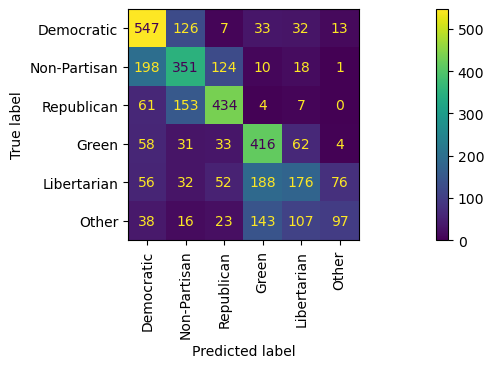

In [414]:
DC_party_names = ['Democratic','Non-Partisan','Republican','Green','Libertarian','Other']
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DC_party_names)
disp.plot(xticks_rotation='vertical')

From the confusion matrix, we can notice that the number on the diagonal is the largest in each column, which implies the model is doing the classification.

In [415]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.57      0.72      0.64       758
         1.0       0.50      0.50      0.50       702
         2.0       0.64      0.66      0.65       659
         3.0       0.52      0.69      0.60       604
         4.0       0.44      0.30      0.36       580
         5.0       0.51      0.23      0.32       424

    accuracy                           0.54      3727
   macro avg       0.53      0.52      0.51      3727
weighted avg       0.53      0.54      0.53      3727



We can see that the f1 scores for Democratic and Republican are the highest, which means the model can classify these two parties better. The f1 scores for Libertarian and Other are relatively low. This is probobaly because the data from these two parties that are used to train the model is less than those of the other parties.

In [416]:
print(lr_model.bestModel.explainParams().split('\n')[1]) # elasticNetParam
print(lr_model.bestModel.explainParams().split('\n')[13]) # regParam

elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.0)
regParam: regularization parameter (>= 0). (default: 0.0, current: 0.0)


After cross validation, the best model has elasticNetParam=0 and regParam=0.

Now, we are going to analyze the feature importance in this logistic regression model.

In [417]:
coefsArray = lr_model.bestModel.coefficientMatrix.toArray() # convert to np.array 
coefsDF = pd.DataFrame(coefsArray.transpose(), columns=DC_party_names) # to pandas
coefsDF = coefsDF.merge(DC_featureCols, left_index=True, right_index=True)

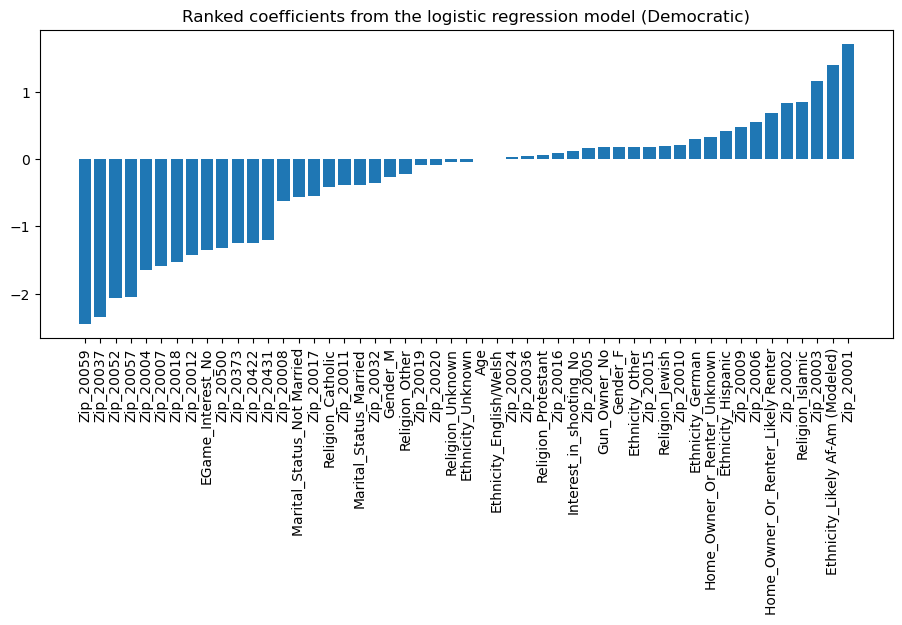

In [418]:
plt.rcParams["figure.figsize"] = (11,4)
coefsDF.sort_values('Democratic', inplace=True)
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF['Democratic'])
plt.title('Ranked coefficients from the logistic regression model (Democratic)')
plt.show()

We can see that people who live in the area with zip code 20001, 20003, and with ethnicity Likely Af-Am (Modeled) are more likely to register for Democratic. People who live in the area with zip code 20059, 20037, and have no interest in EGame are less likely to register for Democratic.

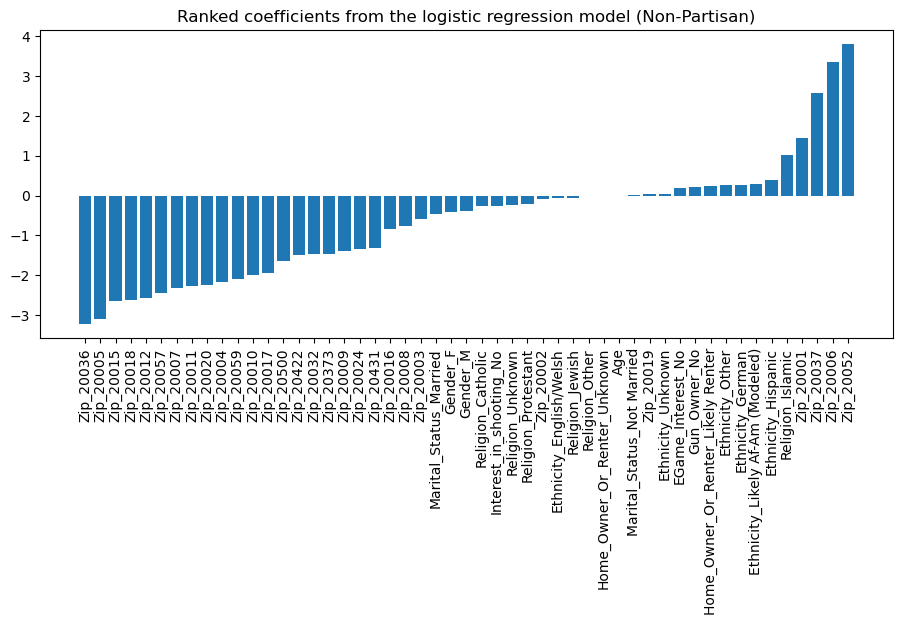

In [419]:
plt.rcParams["figure.figsize"] = (11,4)
coefsDF.sort_values('Non-Partisan', inplace=True)
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF['Non-Partisan'])
plt.title('Ranked coefficients from the logistic regression model (Non-Partisan)')
plt.show()

We can see that people who live in the area with zip code 20052, 20006, and with religion Islamic are more likely to register for Non-Partisan. People who live in the area with zip code 20036, 20005, and with married marital status are less likely to register for Non-Partisan.

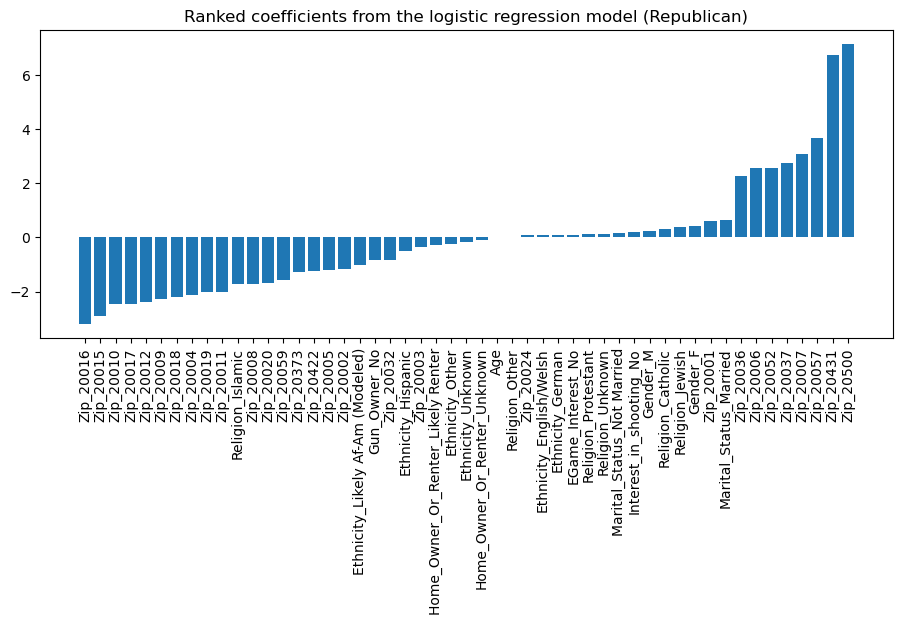

In [420]:
plt.rcParams["figure.figsize"] = (11,4)
coefsDF.sort_values('Republican', inplace=True)
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF['Republican'])
plt.title('Ranked coefficients from the logistic regression model (Republican)')
plt.show()

We can see that people who live in the area with zip code 20500, 20431, and with married marial status are more likely to register for Republican. People who live in the area with zip code 20016, 20015, and with religion Islamic are less likely to register for Republican.

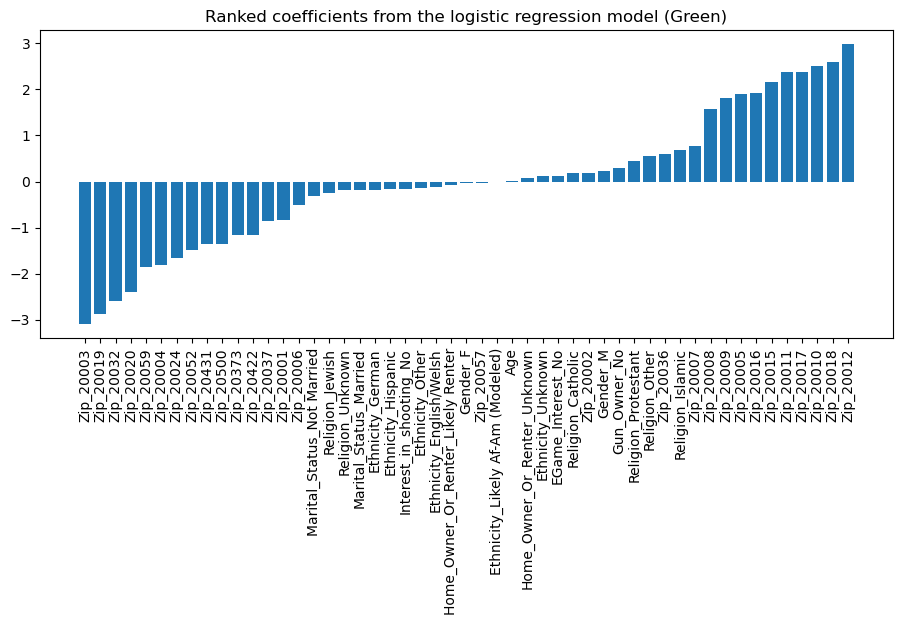

In [421]:
plt.rcParams["figure.figsize"] = (11,4)
coefsDF.sort_values('Green', inplace=True)
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF['Green'])
plt.title('Ranked coefficients from the logistic regression model (Green)')
plt.show()

We can see that people who live in the area with zip code 20012, 20018, and with religion Islamic are more likely to register for Green. People who live in the area with zip code 20003, 20019, and with not married marital status are less likely to register for Green.

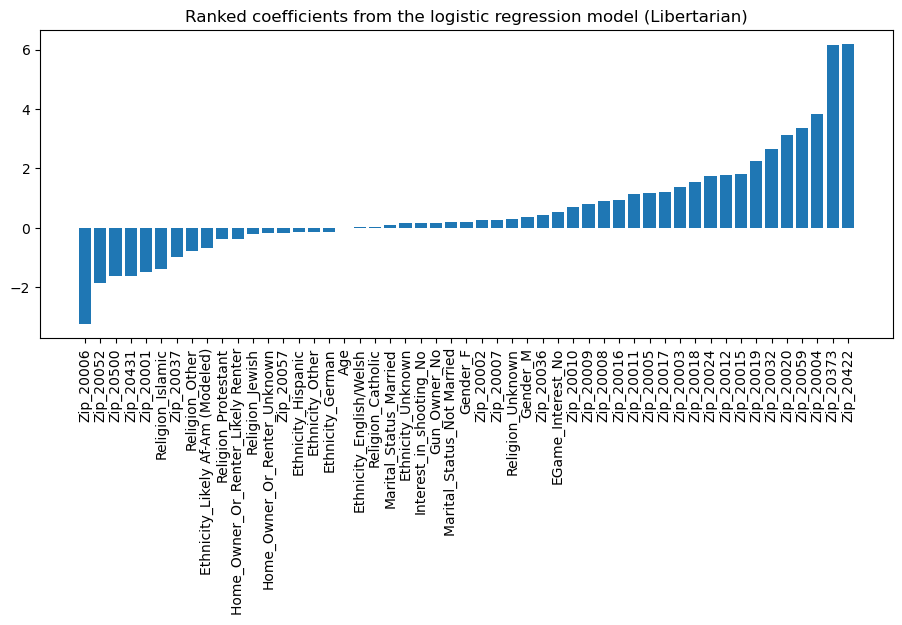

In [422]:
plt.rcParams["figure.figsize"] = (11,4)
coefsDF.sort_values('Libertarian', inplace=True)
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF['Libertarian'])
plt.title('Ranked coefficients from the logistic regression model (Libertarian)')
plt.show()

We can see that people who live in the area with zip code 20422, 20373, and 20004 are more likely to register for Libertarian. People who live in the area with zip code 20006, 20052, and with religion Islamic are less likely to register for Libertarian.

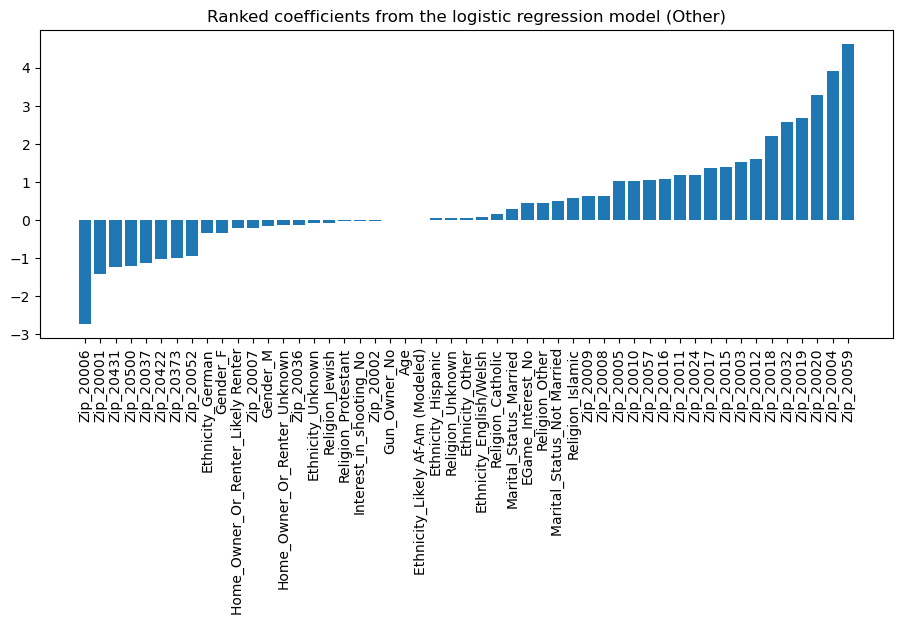

In [423]:
plt.rcParams["figure.figsize"] = (11,4)
coefsDF.sort_values('Other', inplace=True)
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF['Other'])
plt.title('Ranked coefficients from the logistic regression model (Other)')
plt.show()

We can see that people who live in the area with zip code 20059, 20004, and 20020 are more likely to register for Other. People who live in the area with zip code 20006, 20001, and with ethnicity German are less likely to register for Other.

We now list the feature importance for different parties into table.

In [424]:
DC_tmp = []
for i in DC_party_names:
    coefsDF.sort_values(i, ascending=False, inplace=True)
    DC_tmp.append(np.array(coefsDF.name))

In [425]:
DC_tmp = pd.DataFrame(np.transpose(DC_tmp))
DC_tmp.columns = DC_party_names
DC_tmp.head()

,Democratic,Non-Partisan,Republican,Green,Libertarian,Other
0,Zip_20001,Zip_20052,Zip_20500,Zip_20012,Zip_20422,Zip_20059
1,Ethnicity_Likely Af-Am (Modeled),Zip_20006,Zip_20431,Zip_20018,Zip_20373,Zip_20004
2,Zip_20003,Zip_20037,Zip_20057,Zip_20010,Zip_20004,Zip_20020
3,Religion_Islamic,Zip_20001,Zip_20007,Zip_20017,Zip_20059,Zip_20019
4,Zip_20002,Religion_Islamic,Zip_20037,Zip_20011,Zip_20020,Zip_20032


In [426]:
DC_tmp.tail()

,Democratic,Non-Partisan,Republican,Green,Libertarian,Other
46,Zip_20004,Zip_20012,Zip_20012,Zip_20059,Zip_20001,Zip_20037
47,Zip_20057,Zip_20018,Zip_20017,Zip_20020,Zip_20431,Zip_20500
48,Zip_20052,Zip_20015,Zip_20010,Zip_20032,Zip_20500,Zip_20431
49,Zip_20037,Zip_20005,Zip_20015,Zip_20019,Zip_20052,Zip_20001
50,Zip_20059,Zip_20036,Zip_20016,Zip_20003,Zip_20006,Zip_20006


We can see that most of the important features are zip code. We can notice that people live in area with zip code 20003 are more likely to register for Democratic and less likely to register for Green. People live in area with zip code 20006 are more likely to register for Non-Partisan and less likely to register for Libertarian or Other. People live in area with zip code 20003 are more likely to register for Democratic and less likely to register for Green. People live in area with zip code 20059 are more likely to register for Libertarian and Other and less likely to register for Democratic.

Different parties can do more propaganda in area with different zip code shown above.

Although location seems to play an important role, we also want to explore how important the other features are.

In [427]:
DC_tmp_1 = []
for i in DC_party_names:
    coefsDF.sort_values(i, ascending=False, inplace=True)
    tmp = []
    for j in np.array(coefsDF.name):
        if 'Zip' not in j:
            tmp.append(j)
    DC_tmp_1.append(tmp)

In [428]:
DC_tmp_1 = pd.DataFrame(np.transpose(DC_tmp_1))
DC_tmp_1.columns = DC_party_names
DC_tmp_1.head()

,Democratic,Non-Partisan,Republican,Green,Libertarian,Other
0,Ethnicity_Likely Af-Am (Modeled),Religion_Islamic,Marital_Status_Married,Religion_Islamic,EGame_Interest_No,Religion_Islamic
1,Religion_Islamic,Ethnicity_Hispanic,Gender_F,Religion_Other,Gender_M,Marital_Status_Not Married
2,Home_Owner_Or_Renter_Likely Renter,Ethnicity_Likely Af-Am (Modeled),Religion_Jewish,Religion_Protestant,Religion_Unknown,Religion_Other
3,Ethnicity_Hispanic,Ethnicity_German,Religion_Catholic,Gun_Owner_No,Gender_F,EGame_Interest_No
4,Home_Owner_Or_Renter_Unknown,Ethnicity_Other,Gender_M,Gender_M,Marital_Status_Not Married,Marital_Status_Married


In [429]:
DC_tmp_1.tail(5)

,Democratic,Non-Partisan,Republican,Green,Libertarian,Other
17,Gender_M,Interest_in_shooting_No,Home_Owner_Or_Renter_Likely Renter,Ethnicity_German,Home_Owner_Or_Renter_Likely Renter,Home_Owner_Or_Renter_Unknown
18,Marital_Status_Married,Religion_Catholic,Ethnicity_Hispanic,Marital_Status_Married,Religion_Protestant,Gender_M
19,Religion_Catholic,Gender_M,Gun_Owner_No,Religion_Unknown,Ethnicity_Likely Af-Am (Modeled),Home_Owner_Or_Renter_Likely Renter
20,Marital_Status_Not Married,Gender_F,Ethnicity_Likely Af-Am (Modeled),Religion_Jewish,Religion_Other,Gender_F
21,EGame_Interest_No,Marital_Status_Married,Religion_Islamic,Marital_Status_Not Married,Religion_Islamic,Ethnicity_German


After dropping all the location information, we can notice that people with religion Islamic are more likely to register for Democratic, Non-Partisan, Green, and Other, and they are less likely to register for Republican and Libertarian. People with ethnicity Hispanic are more likely to register for Non-Partisan and less likely to register for Republican. Married people are more likely to register for Republican and less likely to register for Non-Partisan. 

From the above result, the party Democratic should do more propaganda to people who are not interested in EGame, who are not married, and with religion Catholic. The party Non-Partisan should do more propaganda to people who are married and with religion Catholic. The party Republican should do more propaganda to people with religion Islamic, with ethnicity Likely Af-Am (Modeled), and who do not have a gun. The party Green should do more propaganda to people who are not married, with religion Jewish, and unknown religion. The party Libertarian should do more propaganda to people with religion Islamicm, ethnicity Likely Af-Am (Modeled), and with protestant. Other parties should do more propaganda to people with ethnicity German, female, and are likely to be a renter.

### Alaska

In the logistic regression, we will tune elasticNetParam with values 0, 0.5, 1, and regParam with values 0, 0.1, 0.5.

In [430]:
# build ParamGrid
lr_params = ParamGridBuilder() \
  .addGrid(lr.elasticNetParam, [0, 0.5, 1]) \
  .addGrid(lr.regParam, [0, 0.1, 0.5]) \
  .build()
# build cross validator model
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_params, evaluator=evaluator, numFolds=3, seed=23)

In [ ]:
AK_lr_cv = lr_cv.fit(AK_train)  # fit the model on the training set

In [ ]:
AK_lr_cv.save('gs://final-proj-135/notebooks/jupyter/AK_lr_cv')   # save the model

In [456]:
lr_model = CrossValidatorModel.load('gs://final-proj-135/notebooks/jupyter/AK_lr_cv')  # load the model

In [433]:
fittedTest = lr_model.transform(AK_test)  # fit the model on testing set

In [434]:
print('accuracy: '+ str(evaluator.evaluate(fittedTest, {evaluator.metricName: "accuracy"})))
print('f1: '+ str(evaluator.evaluate(fittedTest, {evaluator.metricName: "f1"})))

accuracy: 0.3399460708782743


f1: 0.3181541008790671


After cross validation, the best f1 score for logistic regression in Alaska is around 0.3182 and the accuracy is around 0.3399. This is not that bad since we are classifying 9 parties. Now we plot the confusion matrix.

In [435]:
y_true = fittedTest.select(['label']).collect()
y_pred = fittedTest.select(['prediction']).collect()

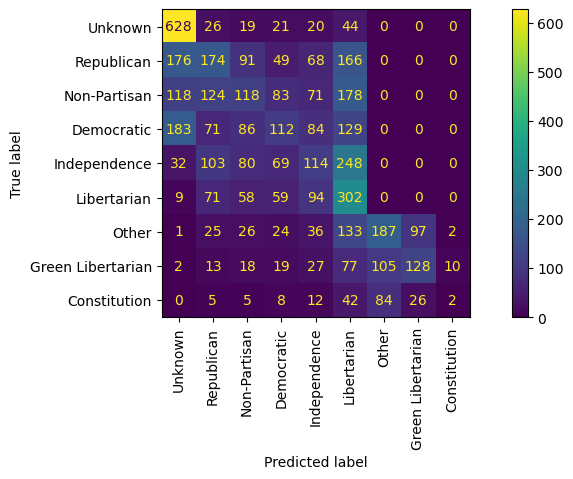

In [436]:
AK_party_names = ['Unknown','Republican','Non-Partisan','Democratic','Independence','Libertarian','Other',
               'Green Libertarian','Constitution']
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=AK_party_names)
disp.plot(xticks_rotation='vertical')

From the confusion matrix, we can notice that the number on the diagonal is the largest in each column except for the party Constitution. This is probably because the training data for Constitution is much less than the other parties. But the model is still classifying between different parties.

In [437]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.55      0.83      0.66       758
         1.0       0.28      0.24      0.26       724
         2.0       0.24      0.17      0.20       692
         3.0       0.25      0.17      0.20       665
         4.0       0.22      0.18      0.19       646
         5.0       0.23      0.51      0.32       593
         6.0       0.50      0.35      0.41       531
         7.0       0.51      0.32      0.39       399
         8.0       0.14      0.01      0.02       184

    accuracy                           0.34      5192
   macro avg       0.32      0.31      0.30      5192
weighted avg       0.33      0.34      0.32      5192



We can see that the f1 scores for Unknown is the highest, and for Other and Green Libertarian are relatively high, which means the model can classify these three parties better. The f1 scores for Constitution is muche lower. This is probobaly because the data from this party that are used to train the model is less than those of the other parties.

In [438]:
print(lr_model.bestModel.explainParams().split('\n')[1]) # elasticNetParam
print(lr_model.bestModel.explainParams().split('\n')[13]) # regParam

elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.0)
regParam: regularization parameter (>= 0). (default: 0.0, current: 0.0)


After cross validation, the best model has elasticNetParam=0 and regParam=0.

Now, we are going to analyze the feature importance in this logistic regression model.

In [439]:
coefsArray = lr_model.bestModel.coefficientMatrix.toArray() # convert to np.array 
coefsDF = pd.DataFrame(coefsArray.transpose(), columns=AK_party_names) # to pandas
coefsDF = coefsDF.merge(AK_featureCols, left_index=True, right_index=True)

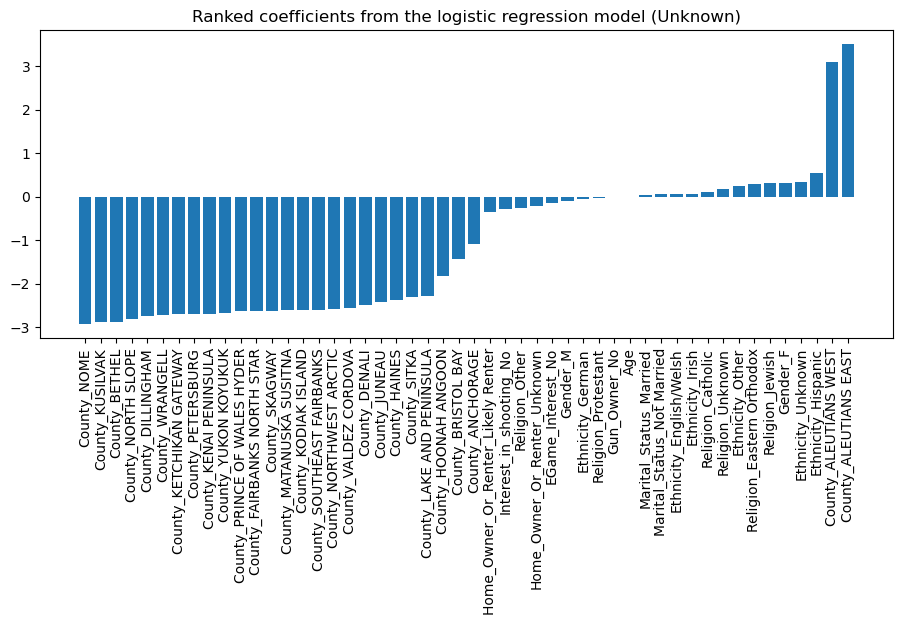

In [440]:
plt.rcParams["figure.figsize"] = (11,4)
coefsDF.sort_values('Unknown', inplace=True)
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF['Unknown'])
plt.title('Ranked coefficients from the logistic regression model (Unknown)')
plt.show()

We can see that people who live in the county Aleutians east, Aleutians west, and with ethnicity Hispanic are more likely to register for Unknown parties. People who live in the county Noma, Kusilvak, and Bethel are less likely to register for Unknown parties.

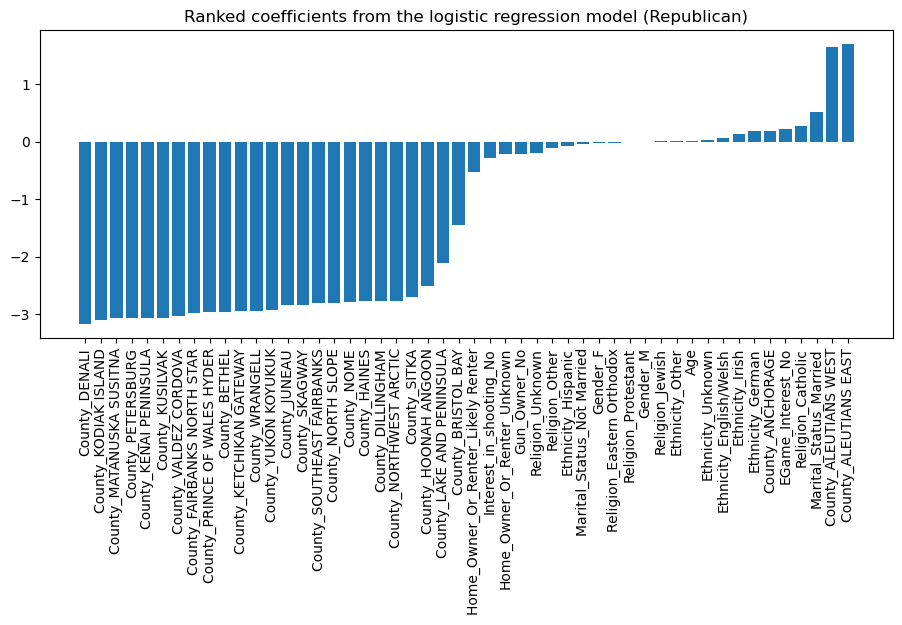

In [441]:
plt.rcParams["figure.figsize"] = (11,4)
coefsDF.sort_values('Republican', inplace=True)
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF['Republican'])
plt.title('Ranked coefficients from the logistic regression model (Republican)')
plt.show()

We can see that people who live in the county Aleutians east, Aleutians west, and with married marital status are more likely to register for Republican. People who live in the county Denali, Kodiak island, and Matanuska Susitna are less likely to register for Republican.

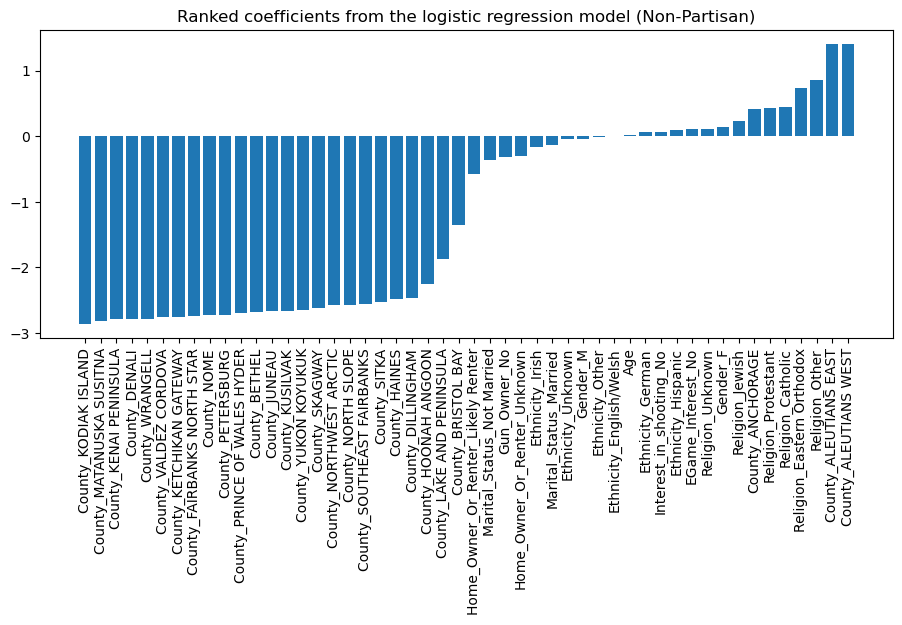

In [442]:
plt.rcParams["figure.figsize"] = (11,4)
coefsDF.sort_values('Non-Partisan', inplace=True)
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF['Non-Partisan'])
plt.title('Ranked coefficients from the logistic regression model (Non-Partisan)')
plt.show()

We can see that people who live in the county Aleutians east, Aleutians west, and with religion other than the top five religions in Alaska are more likely to register for Non-Partisan. People who live in the county Kodiak island, Matanuska susitna, and Kenal peninsula are less likely to register for Non-Partisan.

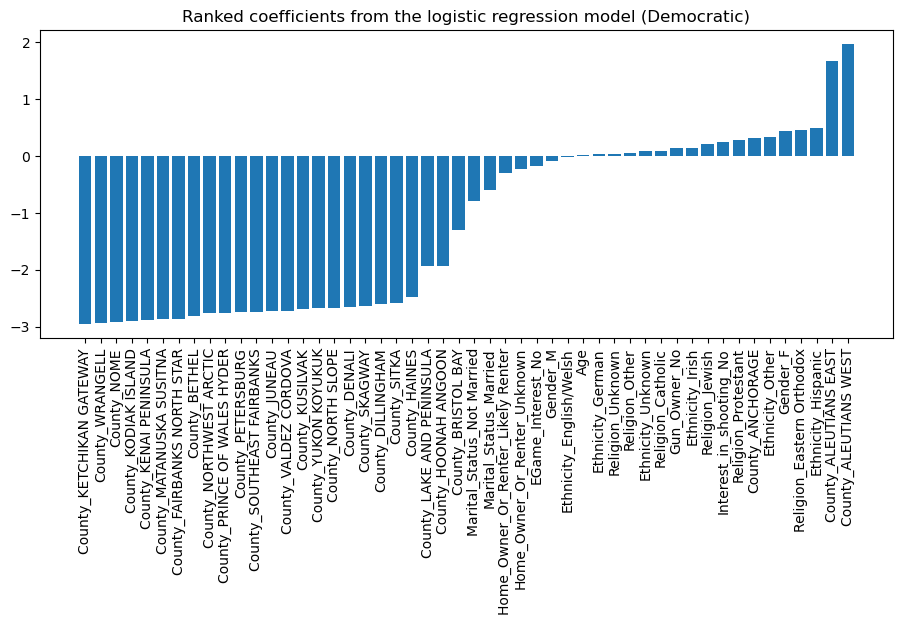

In [443]:
plt.rcParams["figure.figsize"] = (11,4)
coefsDF.sort_values('Democratic', inplace=True)
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF['Democratic'])
plt.title('Ranked coefficients from the logistic regression model (Democratic)')
plt.show()

We can see that people who live in the county Aleutians east, Aleutians west, and with ethnicity Hispanic are more likely to register for Democratic. People who live in the county Ketchikan gateway, Wrangell, and Nome are less likely to register for Democratic.

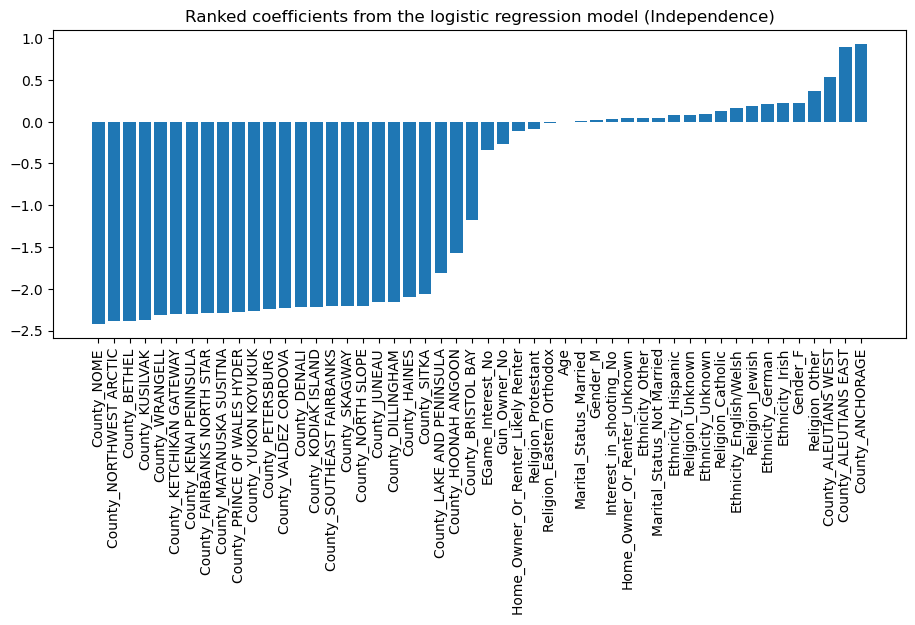

In [444]:
plt.rcParams["figure.figsize"] = (11,4)
coefsDF.sort_values('Independence', inplace=True)
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF['Independence'])
plt.title('Ranked coefficients from the logistic regression model (Independence)')
plt.show()

We can see that people who live in the county Anchorage, Aleutians west, and Aleutians east are more likely to register for Independence. People who live in the county Nome, Northwest arctic, and Bethel are less likely to register for Independence.

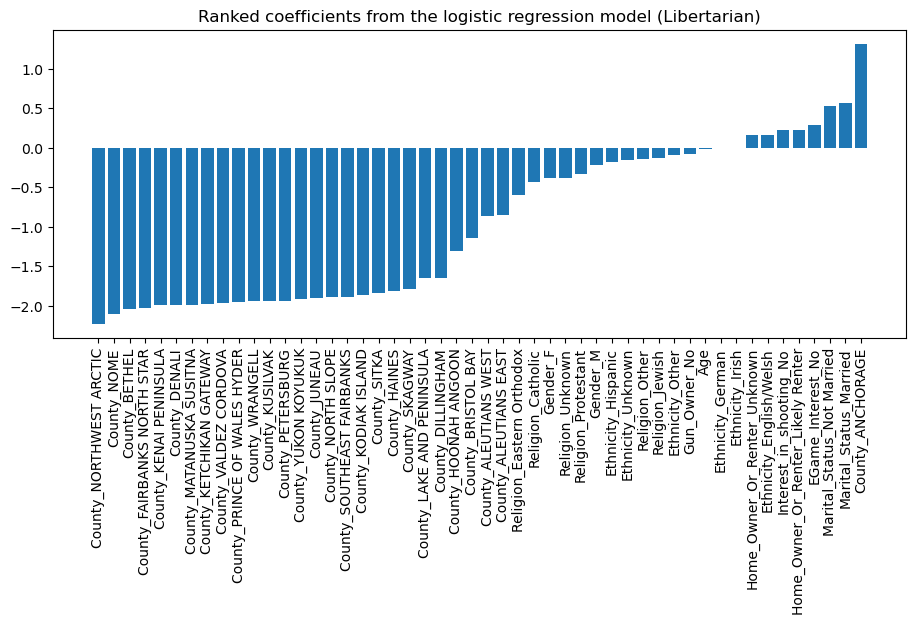

In [445]:
plt.rcParams["figure.figsize"] = (11,4)
coefsDF.sort_values('Libertarian', inplace=True)
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF['Libertarian'])
plt.title('Ranked coefficients from the logistic regression model (Libertarian)')
plt.show()

We can see that people who live in the county Anchorage, who are married, and who do not have interest in EGame are more likely to register for Libertarian. People who live in the county Northwest arctic, Nome, and Bethel are less likely to register for Libertarian.

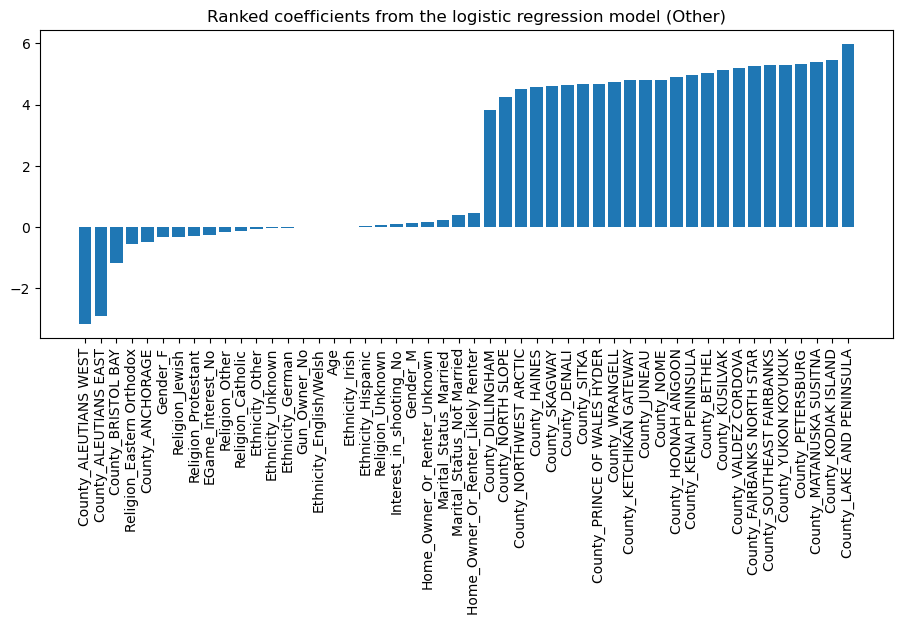

In [446]:
plt.rcParams["figure.figsize"] = (11,4)
coefsDF.sort_values('Other', inplace=True)
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF['Other'])
plt.title('Ranked coefficients from the logistic regression model (Other)')
plt.show()

We can see that people who live in the county Lake and peninsula, Kodiak island, and Matanuska susitna are more likely to register for Other. People who live in the county Aleutians west, Aleutians east, and Bristol bay are less likely to register for Other.

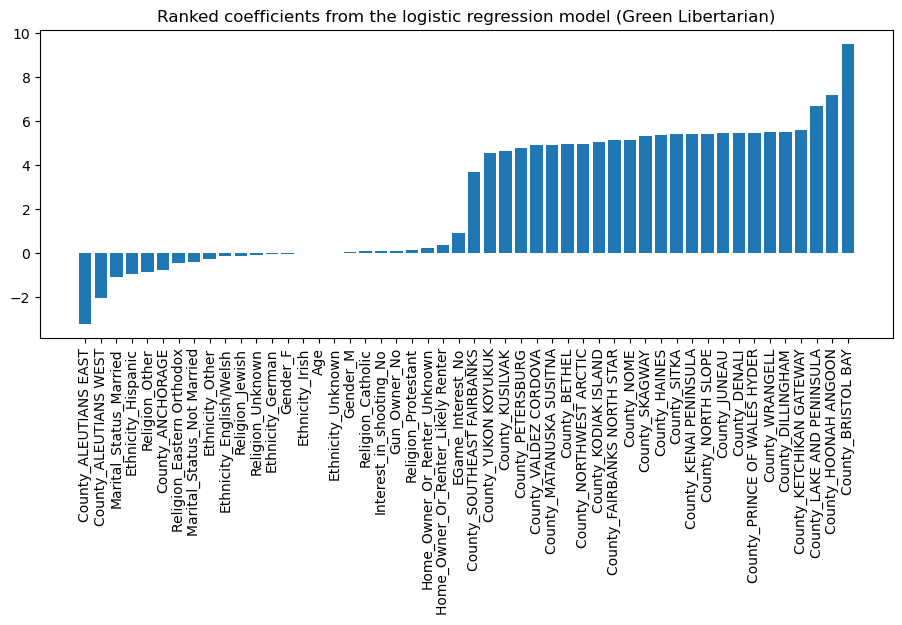

In [447]:
plt.rcParams["figure.figsize"] = (11,4)
coefsDF.sort_values('Green Libertarian', inplace=True)
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF['Green Libertarian'])
plt.title('Ranked coefficients from the logistic regression model (Green Libertarian)')
plt.show()

We can see that people who live in the county Bristol bay, Hoonah Angoon, and Lake and peninsula are more likely to register for Green Libertarian. People who live in the county Aleutians east, Aleutians west, and who are married are less likely to register for Green Libertarian.

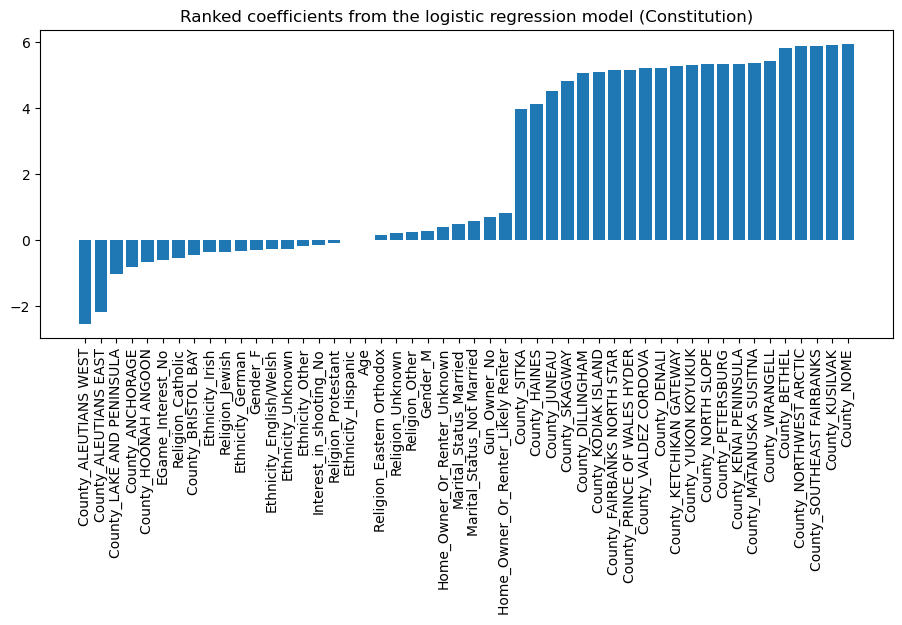

In [448]:
plt.rcParams["figure.figsize"] = (11,4)
coefsDF.sort_values('Constitution', inplace=True)
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF['Constitution'])
plt.title('Ranked coefficients from the logistic regression model (Constitution)')
plt.show()

We can see that people who live in the county Nome, Kusilvak, and Southerneast fairbanks are more likely to register for Constitution. People who live in the county Aleutians west, Aleutians east, and Lake and peninsula are less likely to register for Constitution.

We now list the feature importance for different parties into table.

In [449]:
AK_tmp = []
for i in AK_party_names:
    coefsDF.sort_values(i, ascending=False, inplace=True)
    AK_tmp.append(np.array(coefsDF.name))

In [450]:
AK_tmp = pd.DataFrame(np.transpose(AK_tmp))
AK_tmp.columns = AK_party_names
AK_tmp.head()

,Unknown,Republican,Non-Partisan,Democratic,Independence,Libertarian,Other,Green Libertarian,Constitution
0,County_ALEUTIANS EAST,County_ALEUTIANS EAST,County_ALEUTIANS WEST,County_ALEUTIANS WEST,County_ANCHORAGE,County_ANCHORAGE,County_LAKE AND PENINSULA,County_BRISTOL BAY,County_NOME
1,County_ALEUTIANS WEST,County_ALEUTIANS WEST,County_ALEUTIANS EAST,County_ALEUTIANS EAST,County_ALEUTIANS EAST,Marital_Status_Married,County_KODIAK ISLAND,County_HOONAH ANGOON,County_KUSILVAK
2,Ethnicity_Hispanic,Marital_Status_Married,Religion_Other,Ethnicity_Hispanic,County_ALEUTIANS WEST,Marital_Status_Not Married,County_MATANUSKA SUSITNA,County_LAKE AND PENINSULA,County_SOUTHEAST FAIRBANKS
3,Ethnicity_Unknown,Religion_Catholic,Religion_Eastern Orthodox,Religion_Eastern Orthodox,Religion_Other,EGame_Interest_No,County_PETERSBURG,County_KETCHIKAN GATEWAY,County_NORTHWEST ARCTIC
4,Gender_F,EGame_Interest_No,Religion_Catholic,Gender_F,Gender_F,Home_Owner_Or_Renter_Likely Renter,County_YUKON KOYUKUK,County_DILLINGHAM,County_BETHEL


In [451]:
AK_tmp.tail()

,Unknown,Republican,Non-Partisan,Democratic,Independence,Libertarian,Other,Green Libertarian,Constitution
45,County_DILLINGHAM,County_KENAI PENINSULA,County_WRANGELL,County_KENAI PENINSULA,County_WRANGELL,County_KENAI PENINSULA,County_ANCHORAGE,Religion_Other,County_HOONAH ANGOON
46,County_NORTH SLOPE,County_PETERSBURG,County_DENALI,County_KODIAK ISLAND,County_KUSILVAK,County_FAIRBANKS NORTH STAR,Religion_Eastern Orthodox,Ethnicity_Hispanic,County_ANCHORAGE
47,County_BETHEL,County_MATANUSKA SUSITNA,County_KENAI PENINSULA,County_NOME,County_BETHEL,County_BETHEL,County_BRISTOL BAY,Marital_Status_Married,County_LAKE AND PENINSULA
48,County_KUSILVAK,County_KODIAK ISLAND,County_MATANUSKA SUSITNA,County_WRANGELL,County_NORTHWEST ARCTIC,County_NOME,County_ALEUTIANS EAST,County_ALEUTIANS WEST,County_ALEUTIANS EAST
49,County_NOME,County_DENALI,County_KODIAK ISLAND,County_KETCHIKAN GATEWAY,County_NOME,County_NORTHWEST ARCTIC,County_ALEUTIANS WEST,County_ALEUTIANS EAST,County_ALEUTIANS WEST


We can see that most of the important features are information of County. We can notice that people who live in Aleutians east and Aleutians west are more likely to register for Unknown parties, Republican, Non-Partisan, Democratic, and Independence, and they are less likely to register for Other, Green Libertarian, and Constitution. People who live in the county Nome are more likely to register for Constitution, but they are less likely to register for Unknown parties, Independence, and Libertarian.

Different parties can do more propaganda in different counties shown above.

Although location seems to play an important role, we also want to explore how important the other features are.

In [452]:
AK_tmp_1 = []
for i in AK_party_names:
    coefsDF.sort_values(i, ascending=False, inplace=True)
    tmp = []
    for j in np.array(coefsDF.name):
        if 'County' not in j:
            tmp.append(j)
    AK_tmp_1.append(tmp)

In [453]:
AK_tmp_1 = pd.DataFrame(np.transpose(AK_tmp_1))
AK_tmp_1.columns = AK_party_names
AK_tmp_1.head()

,Unknown,Republican,Non-Partisan,Democratic,Independence,Libertarian,Other,Green Libertarian,Constitution
0,Ethnicity_Hispanic,Marital_Status_Married,Religion_Other,Ethnicity_Hispanic,Religion_Other,Marital_Status_Married,Home_Owner_Or_Renter_Likely Renter,EGame_Interest_No,Home_Owner_Or_Renter_Likely Renter
1,Ethnicity_Unknown,Religion_Catholic,Religion_Eastern Orthodox,Religion_Eastern Orthodox,Gender_F,Marital_Status_Not Married,Marital_Status_Not Married,Home_Owner_Or_Renter_Likely Renter,Gun_Owner_No
2,Gender_F,EGame_Interest_No,Religion_Catholic,Gender_F,Ethnicity_Irish,EGame_Interest_No,Marital_Status_Married,Home_Owner_Or_Renter_Unknown,Marital_Status_Not Married
3,Religion_Jewish,Ethnicity_German,Religion_Protestant,Ethnicity_Other,Ethnicity_German,Home_Owner_Or_Renter_Likely Renter,Home_Owner_Or_Renter_Unknown,Religion_Protestant,Marital_Status_Married
4,Religion_Eastern Orthodox,Ethnicity_Irish,Religion_Jewish,Religion_Protestant,Religion_Jewish,Interest_in_shooting_No,Gender_M,Gun_Owner_No,Home_Owner_Or_Renter_Unknown


In [454]:
AK_tmp_1.tail()

,Unknown,Republican,Non-Partisan,Democratic,Independence,Libertarian,Other,Green Libertarian,Constitution
17,EGame_Interest_No,Religion_Unknown,Ethnicity_Irish,EGame_Interest_No,Religion_Eastern Orthodox,Religion_Protestant,EGame_Interest_No,Marital_Status_Not Married,Ethnicity_German
18,Home_Owner_Or_Renter_Unknown,Gun_Owner_No,Home_Owner_Or_Renter_Unknown,Home_Owner_Or_Renter_Unknown,Religion_Protestant,Religion_Unknown,Religion_Protestant,Religion_Eastern Orthodox,Religion_Jewish
19,Religion_Other,Home_Owner_Or_Renter_Unknown,Gun_Owner_No,Home_Owner_Or_Renter_Likely Renter,Home_Owner_Or_Renter_Likely Renter,Gender_F,Religion_Jewish,Religion_Other,Ethnicity_Irish
20,Interest_in_shooting_No,Interest_in_shooting_No,Marital_Status_Not Married,Marital_Status_Married,Gun_Owner_No,Religion_Catholic,Gender_F,Ethnicity_Hispanic,Religion_Catholic
21,Home_Owner_Or_Renter_Likely Renter,Home_Owner_Or_Renter_Likely Renter,Home_Owner_Or_Renter_Likely Renter,Marital_Status_Not Married,EGame_Interest_No,Religion_Eastern Orthodox,Religion_Eastern Orthodox,Marital_Status_Married,EGame_Interest_No


After dropping all the location information, we can notice that people with ethnicity Hispanic are more likely to register for Unknown parties and Democratic, and they are less likely to register for Green Libertarian. People with religions other than the top five religions in Alaska are more likely to register for Non-Partisan and Independence, and they are less likely to register for Unknown parties and Green Libertarian. Female are more likely to register for Unknown parties, Democratic, and Independence, and they are less likely to register for Libertarian and Other. People with religion Catholic are more likely to register for Republican and Non-Partisan, and they are less likely to register for Libertarian and Constitution.

From the above result, the party Republican should do more propaganda to people who are likely to be a renter, who do not have interest in shooting, and who do not have a gun. The party Non-Partisan should do more propaganda to people who are likely to be a renter, who are not married, and with ethnicity Irish. The party Democratic should do more propaganda to people who are not married, who are likely to be a renter, and who do not have interest in EGame. The party Independence should do more propaganda to people who do not have interest in EGame or gun, who are likely to be a renter, and with religions Protestant and Eastern Orthodox. The party Libertarian should do more propaganda to people with religion Eastern Orthodox, Catholic, and Protestant, and female. The Other parties should do more propaganda to people with religion Eastern Orthodox, Jewish, and Protestant, and female. The party Green Libertarian should do more propaganda to people who are married, who with ethnicity Hispanic, and with religion other than top five religions in Alaska. The party Constitution should do more propaganda to people who do not have intterest in EGame, with religion Catholic and Jewish, and ethnicity Irish and German.

### Decision Tree

### WASHINGTON D.C.

In [301]:
dt_params = ParamGridBuilder() \
  .addGrid(dt.maxDepth, [5, 10, 15]) \
  .build()

dt_cv = CrossValidator(estimator=dt, estimatorParamMaps=dt_params, evaluator=evaluator, numFolds=3, seed=33)

In [302]:
DC_dt_cv = dt_cv.fit(DC_train)

In [303]:
fittedTest_dt_DC = DC_dt_cv.transform(DC_test)

In [304]:
print('accuracy: '+ str(evaluator.evaluate(fittedTest_dt_DC, {evaluator.metricName: "accuracy"})))
print('f1: '+ str(evaluator.evaluate(fittedTest_dt_DC, {evaluator.metricName: "f1"})))

accuracy: 0.5087201502548967


f1: 0.4847674587841405


After calculating the cross validator for the Washington D.C. model, we can see the accuracy is around 50.87% and the f1 values is around 48.48%. Although it seems low, there are 6 different labels being classified so it makes sense for it to be lower than usual.

In [305]:
y_true_dt = fittedTest_dt_DC.select(['label']).collect()
y_pred_dt = fittedTest_dt_DC.select(['prediction']).collect()

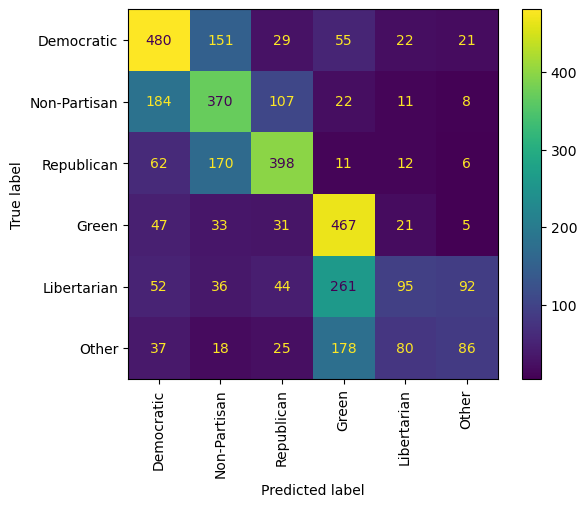

In [306]:
party_names = ['Democratic','Non-Partisan','Republican','Green','Libertarian','Other']
cm = confusion_matrix(y_true_dt, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=party_names)
disp.plot(xticks_rotation='vertical')

The model mostly did well on its accuracy and performance. For Democratic, Non-Partisan, Republican, and Green, they have the highest values in their true predictions. However, the model seems to label Libertarian and Other as Green party more often than their respective parties.

In [307]:
print(classification_report(y_true_dt, y_pred_dt))

              precision    recall  f1-score   support

         0.0       0.56      0.63      0.59       758
         1.0       0.48      0.53      0.50       702
         2.0       0.63      0.60      0.62       659
         3.0       0.47      0.77      0.58       604
         4.0       0.39      0.16      0.23       580
         5.0       0.39      0.20      0.27       424

    accuracy                           0.51      3727
   macro avg       0.49      0.48      0.47      3727
weighted avg       0.50      0.51      0.48      3727



In [308]:
print(DC_dt_cv.bestModel.explainParams().split('\n')[7])

maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 5, current: 15)


We can see that there is a maximum depth of 15 in our tree model.

In [309]:
#feature importance
featureImportances = DC_dt_cv.bestModel.featureImportances.toArray()

In [310]:
print("Feature Importances: ", featureImportances)

Feature Importances:  [0.0199978  0.01135268 0.14156581 0.05571737 0.01215687 0.0136531
 0.00594816 0.00492609 0.00873479 0.01776114 0.01808184 0.00741657
 0.0061894  0.00253527 0.00243522 0.01534165 0.00146989 0.00121523
 0.02728693 0.01076673 0.00217199 0.00547858 0.15461792 0.12043901
 0.0416007  0.10000539 0.00110467 0.         0.0727581  0.
 0.01792488 0.01496531 0.01721991 0.         0.         0.
 0.         0.01462117 0.02337024 0.         0.00067979 0.0089044
 0.00829584 0.         0.01128957 0.         0.         0.
 0.         0.         0.        ]


In [311]:
fittedTest_dt_DC.select('label', 'prediction').distinct().show()

DCfeaturedCols = pd.DataFrame(fittedTest_dt_DC.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
fittedTest_dt_DC.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")
DCfeaturedCols = DCfeaturedCols.set_index('idx')
print(np.array(DCfeaturedCols).transpose())

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       5.0|
|  0.0|       1.0|
|  0.0|       4.0|
|  0.0|       0.0|
|  0.0|       2.0|
|  0.0|       3.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       4.0|
|  1.0|       5.0|
|  1.0|       2.0|
|  1.0|       3.0|
|  2.0|       0.0|
|  2.0|       2.0|
|  2.0|       3.0|
|  2.0|       4.0|
|  2.0|       1.0|
|  2.0|       5.0|
|  3.0|       5.0|
|  3.0|       2.0|
+-----+----------+
only showing top 20 rows

[['Gender_M' 'Gender_F' 'Age' 'Ethnicity_Likely Af-Am (Modeled)'
  'Ethnicity_Other' 'Ethnicity_English/Welsh' 'Ethnicity_Unknown'
  'Ethnicity_Hispanic' 'Ethnicity_German' 'Religion_Unknown'
  'Religion_Protestant' 'Religion_Jewish' 'Religion_Catholic'
  'Religion_Other' 'Religion_Islamic' 'Marital_Status_Not Married'
  'Marital_Status_Married' 'Gun_Owner_No'
  'Home_Owner_Or_Renter_Likely Renter' 'Home_Owner_Or_Renter_Unknown'
  'EGame_Interest_No' 'Interest_in_shooting_No' 'Zip_20001' 'Zip_20037'
  'Zip_20002'

These were the features used in the Washington D.C. dataset for decision tree.

### ALASKA

In [312]:
AK_dt_cv = dt_cv.fit(AK_train)

23/03/22 23:39:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
23/03/22 23:40:22 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1011.7 KiB


In [313]:
fittedTest_dt_AK = AK_dt_cv.transform(AK_test)

In [314]:
print('accuracy: '+ str(evaluator.evaluate(fittedTest_dt_AK, {evaluator.metricName: "accuracy"})))
print('f1: '+ str(evaluator.evaluate(fittedTest_dt_AK, {evaluator.metricName: "f1"})))

accuracy: 0.324537750385208


f1: 0.3097676970864137


After calculating the cross validator for the Alaska model, we can see the accuracy is around 32.45% and the f1 values is around 30.97%. This is much lower compared to Washington D.C. but in this case, there are 9 different labels being classified as opposed to 6. So a drop in percentage is to be expected.

In [315]:
y_true_dt = fittedTest_dt_AK.select(['label']).collect()
y_pred_dt = fittedTest_dt_AK.select(['prediction']).collect()

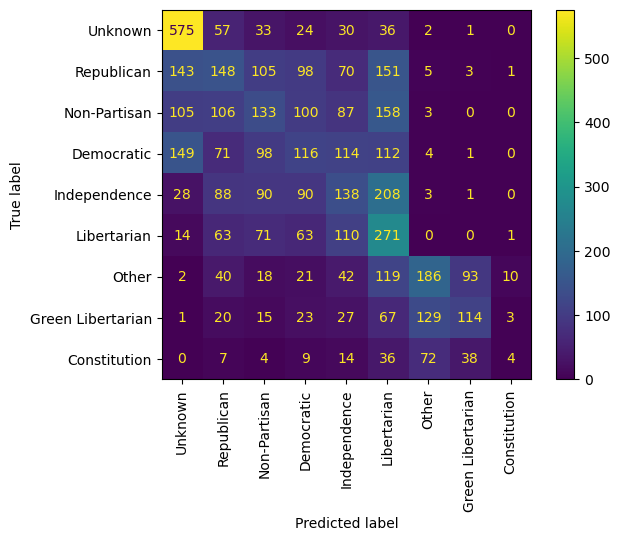

In [316]:
party_names = ['Unknown','Republican','Non-Partisan','Democratic','Independence','Libertarian','Other',
               'Green Libertarian','Constitution']
cm = confusion_matrix(y_true_dt, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=party_names)
disp.plot(xticks_rotation='vertical')

This is where the classification becomes a little more tricky. There seems to be a a lot more confusion in the model in classifying the parties correctly. Unknown seems to be the most accruately labeled party here. Republicans, Non-Partisan, Democrats, Independent, Green, and Constitution have values in other parties that are not the highest in their own party. Only Libertarian and Other have the highest values in their classification. Most parties are labeled as Libertarian.

In [317]:
print(classification_report(y_true_dt, y_pred_dt))

              precision    recall  f1-score   support

         0.0       0.57      0.76      0.65       758
         1.0       0.25      0.20      0.22       724
         2.0       0.23      0.19      0.21       692
         3.0       0.21      0.17      0.19       665
         4.0       0.22      0.21      0.22       646
         5.0       0.23      0.46      0.31       593
         6.0       0.46      0.35      0.40       531
         7.0       0.45      0.29      0.35       399
         8.0       0.21      0.02      0.04       184

    accuracy                           0.32      5192
   macro avg       0.32      0.30      0.29      5192
weighted avg       0.32      0.32      0.31      5192



In [318]:
print(AK_dt_cv.bestModel.explainParams().split('\n')[7])

maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 5, current: 10)


We can see that there is a maximum depth of 10 in our tree model.

In [319]:
featureImportances = AK_dt_cv.bestModel.featureImportances.toArray()

In [320]:
print("Feature Importances: ", featureImportances)

Feature Importances:  [0.02466052 0.00523709 0.14420074 0.02079367 0.01587944 0.00935948
 0.01056436 0.01080246 0.01289925 0.01967566 0.01081237 0.0064723
 0.00222552 0.00388784 0.00454975 0.0156107  0.01042632 0.02123781
 0.0198168  0.01023926 0.00926898 0.02562715 0.24041022 0.10600746
 0.2215137  0.00455875 0.00081576 0.00281592 0.00076453 0.00169413
 0.00082443 0.         0.         0.         0.00271598 0.00063772
 0.         0.0017871  0.         0.00052667 0.         0.
 0.         0.00068017 0.         0.         0.         0.
 0.         0.        ]


In [321]:
fittedTest_dt_AK.select('label', 'prediction').distinct().show()

DCfeaturedCols = pd.DataFrame(fittedTest_dt_AK.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
fittedTest_dt_AK.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")
DCfeaturedCols = DCfeaturedCols.set_index('idx')
print(np.array(DCfeaturedCols).transpose())

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       5.0|
|  0.0|       1.0|
|  0.0|       4.0|
|  0.0|       6.0|
|  0.0|       7.0|
|  0.0|       0.0|
|  0.0|       2.0|
|  0.0|       3.0|
|  1.0|       1.0|
|  1.0|       6.0|
|  1.0|       8.0|
|  1.0|       0.0|
|  1.0|       4.0|
|  1.0|       5.0|
|  1.0|       2.0|
|  1.0|       3.0|
|  1.0|       7.0|
|  2.0|       0.0|
|  2.0|       2.0|
|  2.0|       3.0|
+-----+----------+
only showing top 20 rows

[['Gender_M' 'Gender_F' 'Age' 'Ethnicity_English/Welsh' 'Ethnicity_Other'
  'Ethnicity_Unknown' 'Ethnicity_Hispanic' 'Ethnicity_German'
  'Ethnicity_Irish' 'Religion_Unknown' 'Religion_Protestant'
  'Religion_Catholic' 'Religion_Jewish' 'Religion_Eastern Orthodox'
  'Religion_Other' 'Marital_Status_Not Married' 'Marital_Status_Married'
  'Gun_Owner_No' 'Home_Owner_Or_Renter_Likely Renter'
  'Home_Owner_Or_Renter_Unknown' 'EGame_Interest_No'
  'Interest_in_shooting_No' 'County_ANCHORAGE' 'County_ALEUTIANS WEST'
  

These were the features used in the Alaska dataset for decision tree.

### Random Forest

##### Washington DC

In [322]:
rf_params = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [2, 5, 10]) \
    .addGrid(rf.numTrees,[5,20,50]) \
    .build()

rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_params, evaluator=evaluator, numFolds=3, seed=33)

In [323]:
DC_rf_cv = rf_cv.fit(DC_train)

23/03/22 23:41:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1092.4 KiB
23/03/22 23:41:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1008.2 KiB
23/03/22 23:41:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1350.8 KiB
23/03/22 23:41:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1762.2 KiB
23/03/22 23:42:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/03/22 23:42:02 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1422.1 KiB
23/03/22 23:42:31 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1096.6 KiB
23/03/22 23:42:38 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1310.6 KiB
23/03/22 23:42:39 WARN org.apache.spark.scheduler.DAGScheduler: Broadcastin

In [324]:
fittedTest_rf_DC = DC_rf_cv.transform(DC_test)

In [325]:
print('accuracy: '+ str(evaluator.evaluate(fittedTest_rf_DC, {evaluator.metricName: "accuracy"})))
print('f1: '+ str(evaluator.evaluate(fittedTest_rf_DC, {evaluator.metricName: "f1"})))

accuracy: 0.5376978803327073


f1: 0.5256333333792581


The accuracy of 53.5% and f1 performance of 52.4% are extremely good results, taking into account that we try to classify more than 2 labels

In [326]:
y_true_rf = fittedTest_rf_DC.select(['label']).collect()
y_pred_rf = fittedTest_rf_DC.select(['prediction']).collect()

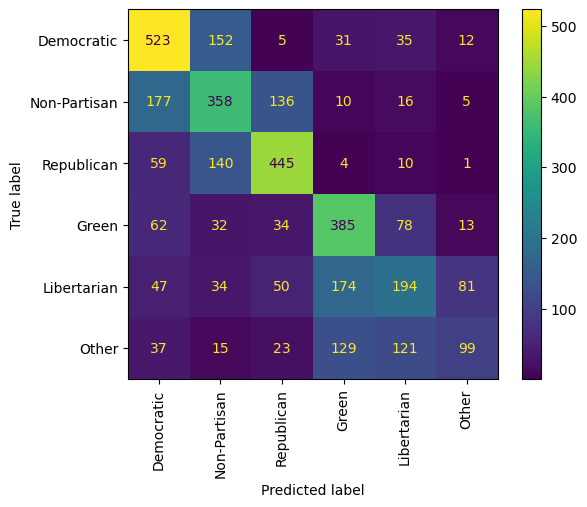

In [327]:
party_names = ['Democratic','Non-Partisan','Republican','Green','Libertarian','Other']
cm = confusion_matrix(y_true_rf, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=party_names)
disp.plot(xticks_rotation='vertical')

The true predictions for each party being the highest value signifies that the model did a good job with fitting the MultiLabel classification

In [328]:
print(DC_rf_cv.bestModel.explainParams().split('\n')[9])
print('\n ')
print(DC_rf_cv.bestModel.explainParams().split('\n')[14])

maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 5, current: 10)

 
numTrees: Number of trees to train (>= 1). (default: 20, current: 20)


In [329]:
print(classification_report(y_true_rf, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.58      0.69      0.63       758
         1.0       0.49      0.51      0.50       702
         2.0       0.64      0.68      0.66       659
         3.0       0.53      0.64      0.58       604
         4.0       0.43      0.33      0.38       580
         5.0       0.47      0.23      0.31       424

    accuracy                           0.54      3727
   macro avg       0.52      0.51      0.51      3727
weighted avg       0.53      0.54      0.53      3727



From here we can notice that people also majorly vote Democratic and Republican, as in Logistic Regression

In [332]:
def get_features_importance(dataset= fittedTest_rf_DC, model=DC_rf_cv):
    """
    Careful! this function is hard-coded inside for feature names. 
    I created earlier `to_encode` and `numerical_cols` lists for Xs names; I'm using that here.
    """
    sparse= model.bestModel.featureImportances
    vals= sparse.values
    idx= sparse.indices
    feature_names=dataset.drop('Party','features','label', 'rawPrediction', 'probability', 'prediction').columns
    importances_df= pd.DataFrame(zip(feature_names, vals), columns=["feature", "value"])
    return importances_df

<BarContainer object of 10 artists>

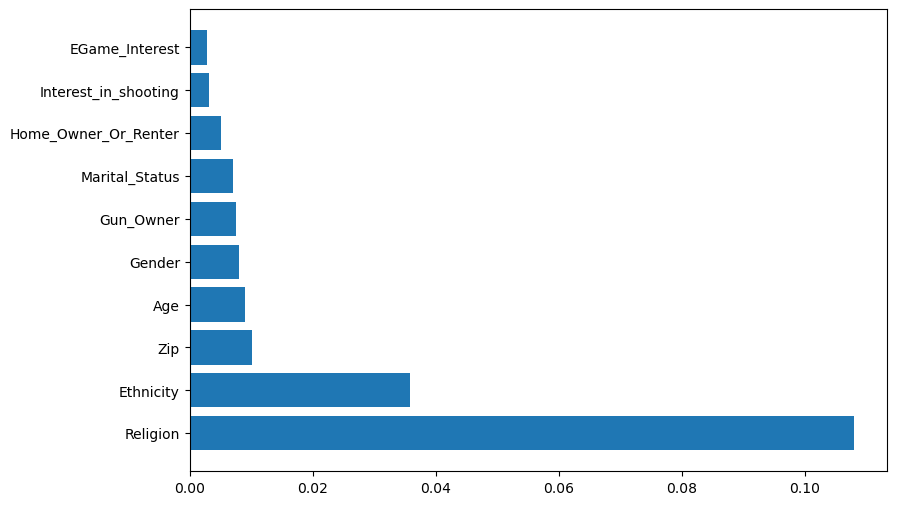

In [333]:
rfc_importance_df= get_features_importance().sort_values(by='value',ascending=False)
rfc_importance_df.head(20)
plt.figure(figsize=(9,6))
plt.barh(rfc_importance_df['feature'][:20],
        rfc_importance_df['value'][:20])

It looks like Religion plays the major role in Party Classification in DC, followed by Ethnicity, Zip, and Age, which is very different from the results shown in Logistic Regression.

##### Alaska

In [334]:
rf_params = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [2, 5, 10]) \
    .addGrid(rf.numTrees,[5,20,50]) \
    .build()

rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_params, evaluator=evaluator, numFolds=3, seed=33)

In [335]:
AK_rf_cv = rf_cv.fit(AK_train)

23/03/22 23:46:27 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1286.6 KiB
23/03/22 23:46:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1671.6 KiB
23/03/22 23:46:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1237.7 KiB
23/03/22 23:46:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1297.1 KiB
23/03/22 23:46:38 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1862.2 KiB
23/03/22 23:46:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
23/03/22 23:46:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.4 MiB
23/03/22 23:46:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/03/22 23:47:27 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting larg

In [336]:
fittedTest_rf_AK = AK_rf_cv.transform(AK_test)

In [337]:
print('accuracy: '+ str(evaluator.evaluate(fittedTest_rf_AK, {evaluator.metricName: "accuracy"})))
print('f1: '+ str(evaluator.evaluate(fittedTest_rf_AK, {evaluator.metricName: "f1"})))

23/03/22 23:49:06 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1323.5 KiB


accuracy: 0.3411016949152542


23/03/22 23:49:10 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1323.5 KiB


f1: 0.3133987682190856


Just like in Logistic Regression, both the accuracy and f1 performance drop significantly, as we try to Classify even more parties. Yet, accuracy being 34% in this scenario is also not bad news.

In [338]:
y_true_AK = fittedTest_rf_AK.select(['label']).collect()
y_pred_AK = fittedTest_rf_AK.select(['prediction']).collect()

23/03/22 23:49:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1310.8 KiB


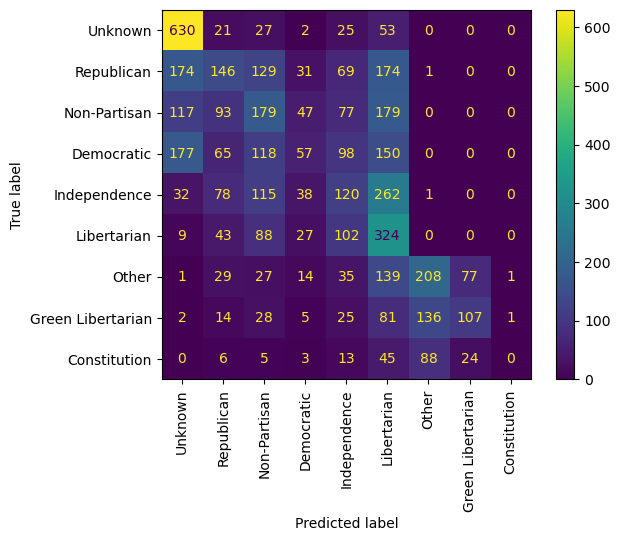

In [339]:
party_names = ['Unknown','Republican','Non-Partisan','Democratic','Independence','Libertarian','Other',
               'Green Libertarian','Constitution']
cm = confusion_matrix(y_true_AK, y_pred_AK)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=party_names)
disp.plot(xticks_rotation='vertical')

As we see here, the model gets lost in classification a little, and clearly struggles with classifying Democratic and Constitution parties (Constitution missing is explained clearly in Logistic Regression section).

In [340]:
print(DC_rf_cv.bestModel.explainParams().split('\n')[9])
print('\n ')
print(DC_rf_cv.bestModel.explainParams().split('\n')[14])

maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 5, current: 10)

 
numTrees: Number of trees to train (>= 1). (default: 20, current: 20)


In [457]:
def get_features_importance(dataset= fittedTest_rf_AK, model=AK_rf_cv):
    """
    Careful! this function is hard-coded inside for feature names. 
    I created earlier `to_encode` and `numerical_cols` lists for Xs names; I'm using that here.
    """
    sparse= model.bestModel.featureImportances
    vals= sparse.values
    idx= sparse.indices
    feature_names=dataset.drop('Party','features','label', 'rawPrediction', 'probability', 'prediction').columns
    importances_df= pd.DataFrame(zip(feature_names, vals), columns=["feature", "value"])
    return importances_df

<BarContainer object of 10 artists>

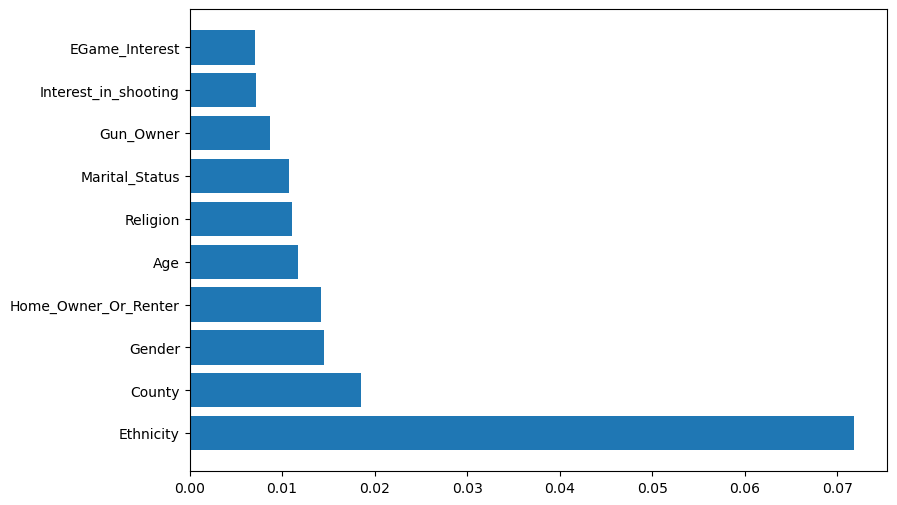

In [458]:
rfc_importance_df= get_features_importance().sort_values(by='value',ascending=False)
rfc_importance_df.head(20)
plt.figure(figsize=(9,6))
plt.barh(rfc_importance_df['feature'][:20],
        rfc_importance_df['value'][:20])

In Alaska, Ethinicity being classified as the most important feature, and then followed by County and Gender.

Due to the nature of Random Forest Classifier, unable to go into more details with Coefficients matrix (because Random Forest doesnt support it) and see which specific Ethnicities,Gender, and Religion, play a bigger role voting for one party or the other. But the accuracy of the prediction being similar to the Logistic Regression, I'd suggest going to that section and obtain the needed information.

### Naive Bayes

In [345]:
nb_params = ParamGridBuilder() \
               .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
               .build()
nb_cv = CrossValidator(estimator=nb, estimatorParamMaps=nb_params, evaluator=evaluator, numFolds=3, seed=33)

The main tuning parameter for the naive bayes model is smoothing, a shrinkage estimator. Smoothing helps handle the problem of zero probability and avoids overflow.

#### Washington D.C.

In [346]:
DC_nb_cv = nb_cv.fit(DC_train)

In [347]:
fittedTest_nb_DC = DC_nb_cv.transform(DC_test)

In [348]:
print('accuracy: '+ str(evaluator.evaluate(fittedTest_nb_DC, {evaluator.metricName: "accuracy"})))
print('f1: '+ str(evaluator.evaluate(fittedTest_nb_DC, {evaluator.metricName: "f1"})))

accuracy: 0.5301851354977194


f1: 0.5192723657044781


The accuracy for the model for Washington D.C. is roughly 0.53 and f1 is roughly 0.52. Although these seem relatively low considering it only classifies party correctly roughly half the time, we have to consider there are 6 different parties being classified, and the third party ones may have little to no distinction. Thus, a confusion matrix would be helpful to visualize where the classsification is differing for this model.

In [349]:
y_true_nb = fittedTest_nb_DC.select(['label']).collect()
y_pred_nb = fittedTest_nb_DC.select(['prediction']).collect()

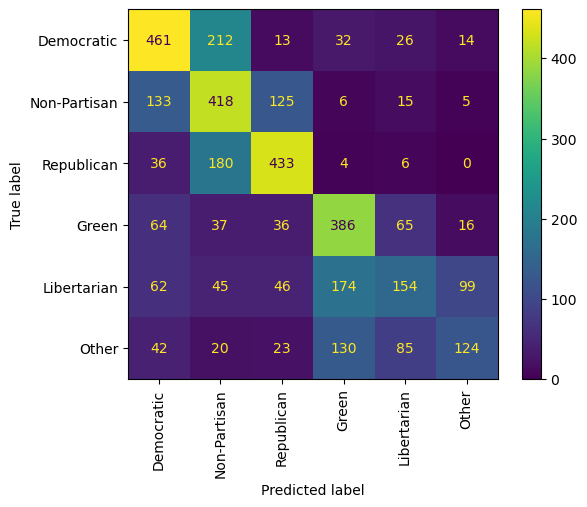

In [350]:
party_names = ['Democratic','Non-Partisan','Republican','Green','Libertarian','Other']
cm = confusion_matrix(y_true_nb, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=party_names)
disp.plot(xticks_rotation='vertical')

It appears that Democrats are pretty accurately predicted, but will get confused with Non-Partisan the most. Similarly, Non-Partisan also may be labeled as Democrat. Republicans are pretty accurately classified and will accidentally be labeled as Republican. This signals more data is likely needed to distinguish Non-Partisan. Green party voters are nearly always classified correctly. Libertarians and Other are surprisingly labeled as Green Party quite frequently.

In [351]:
print(classification_report(y_true_nb, y_pred_nb))

              precision    recall  f1-score   support

         0.0       0.58      0.61      0.59       758
         1.0       0.46      0.60      0.52       702
         2.0       0.64      0.66      0.65       659
         3.0       0.53      0.64      0.58       604
         4.0       0.44      0.27      0.33       580
         5.0       0.48      0.29      0.36       424

    accuracy                           0.53      3727
   macro avg       0.52      0.51      0.51      3727
weighted avg       0.53      0.53      0.52      3727



In [352]:
print(DC_nb_cv.bestModel.explainParams().split('\n')[6])

smoothing: The smoothing parameter, should be >= 0, default is 1.0 (default: 1.0, current: 0.8)


This indicates a smoothing value of 0.8 works best for classification in Washington D.C.

In [384]:
featureImportances = DC_nb_cv.bestModel.theta.toArray().tolist()
featureImportances = featureImportances[0]

In [380]:
fittedTest_nb_DC.select('label', 'prediction').distinct().show()

DCfeaturedCols = pd.DataFrame(fittedTest_nb_DC.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
fittedTest_nb_DC.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")
DCfeaturedCols = DCfeaturedCols.set_index('idx')
keys = np.array(DCfeaturedCols).transpose().tolist()
keys = keys[0]

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       5.0|
|  0.0|       1.0|
|  0.0|       4.0|
|  0.0|       0.0|
|  0.0|       2.0|
|  0.0|       3.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       4.0|
|  1.0|       5.0|
|  1.0|       2.0|
|  1.0|       3.0|
|  2.0|       0.0|
|  2.0|       2.0|
|  2.0|       3.0|
|  2.0|       4.0|
|  2.0|       1.0|
|  3.0|       5.0|
|  3.0|       2.0|
|  3.0|       1.0|
+-----+----------+
only showing top 20 rows



In [398]:
combined = {keys[i]: featureImportances[i] for i in range(len(keys))}
print(sorted(combined.items(), key=lambda x:x[1]))

[('Zip_20037', -11.793061638603955), ('Zip_20052', -11.793061638603955), ('Zip_20057', -11.793061638603955), ('Zip_20059', -11.793061638603955), ('Zip_20004', -11.793061638603955), ('Zip_20500', -11.793061638603955), ('Zip_20373', -11.793061638603955), ('Zip_20422', -11.793061638603955), ('Zip_20431', -11.793061638603955), ('Zip_20012', -10.982131422387626), ('Zip_20018', -10.540298670108587), ('Zip_20015', -10.540298670108587), ('Religion_Other', -10.234917020557404), ('Zip_20007', -10.234917020557404), ('Zip_20008', -10.234917020557404), ('Zip_20006', -10.234917020557404), ('Zip_20036', -10.001302169375899), ('Zip_20005', -10.001302169375899), ('Zip_20020', -9.812060169737371), ('Zip_20016', -9.812060169737371), ('Zip_20017', -9.812060169737371), ('Zip_20032', -9.812060169737371), ('Zip_20024', -9.652995475107684), ('Religion_Islamic', -9.515794353594199), ('Religion_Catholic', -9.101818555818125), ('Zip_20019', -8.945249495126586), ('Zip_20010', -8.809908147256824), ('Zip_20011', -8

#### Alaska

In [399]:
AK_nb_cv = nb_cv.fit(AK_train)

In [400]:
fittedTest_nb_AK = AK_nb_cv.transform(AK_test)

In [401]:
print('accuracy: '+ str(evaluator.evaluate(fittedTest_nb_AK, {evaluator.metricName: "accuracy"})))
print('f1: '+ str(evaluator.evaluate(fittedTest_nb_AK, {evaluator.metricName: "f1"})))

accuracy: 0.32492295839753466


f1: 0.30609501366294944


The accuracy for the model for Alaska is roughly 0.32 and f1 is roughly 0.31. These seem like low metrics considering it only classifies party correctly roughly a third of the time, we have to consider there are 9 different parties being classified, and the third party ones may have little to no distinction and there are lots of unknown values. Thus, a confusion matrix would be helpful to visualize where the classsification is differing for this model.

In [402]:
y_true_nb = fittedTest_nb_AK.select(['label']).collect()
y_pred_nb = fittedTest_nb_AK.select(['prediction']).collect()

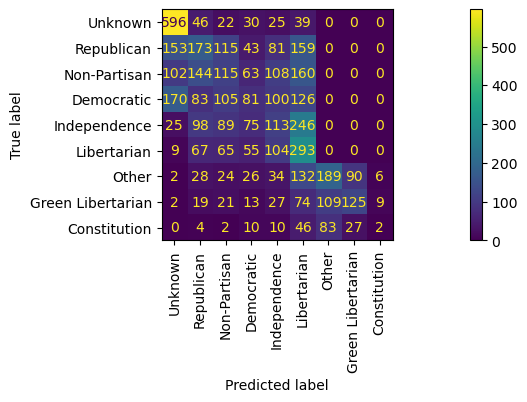

In [403]:
party_names = ['Unknown','Republican','Non-Partisan','Democratic','Independence','Libertarian','Other',
               'Green Libertarian','Constitution']
cm = confusion_matrix(y_true_nb, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=party_names)
disp.plot(xticks_rotation='vertical')

It appears that Unknown voters are very accurately predicted, but a lot of the the other parties are accidentally predicted as unknown. Thus, data either needs to be balanced further or additional voter information is necessary. To continue, Independent, Other, Republican and Non-Partisan voters are interestingly classified as Libertarians quite frequently. Also, Constitution voters are hardly ever classified correctly.

In [404]:
print(classification_report(y_true_nb, y_pred_nb))

              precision    recall  f1-score   support

         0.0       0.56      0.79      0.66       758
         1.0       0.26      0.24      0.25       724
         2.0       0.21      0.17      0.18       692
         3.0       0.20      0.12      0.15       665
         4.0       0.19      0.17      0.18       646
         5.0       0.23      0.49      0.31       593
         6.0       0.50      0.36      0.41       531
         7.0       0.52      0.31      0.39       399
         8.0       0.12      0.01      0.02       184

    accuracy                           0.32      5192
   macro avg       0.31      0.30      0.28      5192
weighted avg       0.32      0.32      0.31      5192



In [405]:
print(AK_nb_cv.bestModel.explainParams().split('\n')[6])

smoothing: The smoothing parameter, should be >= 0, default is 1.0 (default: 1.0, current: 0.4)


Unlike the best naive bayes model for Washington D.C., the optimal smoothing value is 0.4.

In [406]:
featureImportances = AK_nb_cv.bestModel.theta.toArray().tolist()
featureImportances = featureImportances[0]

In [407]:
fittedTest_nb_AK.select('label', 'prediction').distinct().show()

AKfeaturedCols = pd.DataFrame(fittedTest_nb_AK.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
fittedTest_nb_AK.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")
AKfeaturedCols = AKfeaturedCols.set_index('idx')
keys = np.array(AKfeaturedCols).transpose().tolist()
keys = keys[0]

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       5.0|
|  0.0|       1.0|
|  0.0|       4.0|
|  0.0|       0.0|
|  0.0|       2.0|
|  0.0|       3.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       4.0|
|  1.0|       5.0|
|  1.0|       2.0|
|  1.0|       3.0|
|  2.0|       0.0|
|  2.0|       2.0|
|  2.0|       3.0|
|  2.0|       4.0|
|  2.0|       1.0|
|  2.0|       5.0|
|  3.0|       5.0|
|  3.0|       2.0|
+-----+----------+
only showing top 20 rows



In [408]:
combined = {keys[i]: featureImportances[i] for i in range(len(keys))}
print(sorted(combined.items(), key=lambda x:x[1]))

[('County_MATANUSKA SUSITNA', -12.512674602834466), ('County_FAIRBANKS NORTH STAR', -12.512674602834466), ('County_KENAI PENINSULA', -12.512674602834466), ('County_JUNEAU', -12.512674602834466), ('County_BETHEL', -12.512674602834466), ('County_KETCHIKAN GATEWAY', -12.512674602834466), ('County_VALDEZ CORDOVA', -12.512674602834466), ('County_KODIAK ISLAND', -12.512674602834466), ('County_SITKA', -12.512674602834466), ('County_SOUTHEAST FAIRBANKS', -12.512674602834466), ('County_NOME', -12.512674602834466), ('County_KUSILVAK', -12.512674602834466), ('County_NORTHWEST ARCTIC', -12.512674602834466), ('County_PRINCE OF WALES HYDER', -12.512674602834466), ('County_NORTH SLOPE', -12.512674602834466), ('County_HAINES', -12.512674602834466), ('County_YUKON KOYUKUK', -12.512674602834466), ('County_DENALI', -12.512674602834466), ('County_PETERSBURG', -12.512674602834466), ('County_SKAGWAY', -12.512674602834466), ('County_HOONAH ANGOON', -12.512674602834466), ('County_WRANGELL', -12.51267460283446

# Findings & Conclusion

It appears that a majority of the models for Washington D.C. performed roughly above 50% accuracy and the models for Alaska perform roughly above 30% accuracy. This is to be expected considering there are six labels for D.C. and nine labels for Alaska. Furthermore, considering the unbalanced data of Alaska, we retained unknown party values, which generally led to skewed labels towards unknown versus classifying the correct party. Interestingly, the logistic regression model led to a higher accuracy score for D.C. (\~54.2%) but the random forest model led to a higher accuracy score for Alaska (~34.1%). To continue, the model with the lowest accuracy for Washington D.C. was the decision tree model and for Alaska it was tied between the decision tree and naive bayes model. To be fair, there was not too large of a margin of difference amongst models' accuracy. Across states and models, county or zip, religion then ethnicity tended to be the most important features in classification while Age, Egame Interest, Marital Status, Gun ownership, and interest in shooting tended to be least important in determining voter party. Overall, there was not much differentiation of party traits between Alaska and Washington D.C.. Further exploration could lead us to analyze other states in the United States to see if these trends are consistent across the United States or to balance the data set again and rerun our models.